# Visualisation of all TF analysis results (upreg and downreg along invading trophoblast trajectory)

TFs are treated based on the following measures
1. Differential expression calculted with `limma`
2. Differential activity calucated with `DoRothEA`
3. Differential accessibility of binding motif calculated with wilcoxon test within Seurat on `chromVar` scores
4. Presence in MEFISTO enrichment results for factors relevant to a comparison (see details of that translation below & in notebook `./MOFA_MEFISTO/S3_DEG_comparison_to_MEFISTO_factor_translation.ipynb`)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


In [4]:
%%bash

pip freeze

absl-py==0.12.0
aiohttp==3.7.4.post0
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1613901514078/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
anndata2ri==1.0.6
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388751160/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
astunparse==1.6.3
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1616434096000/work
bleach @ file:///home/conda/feedstock_

# Getting to lists of TFs up/down regulated along the trajectory

In [5]:
# reading in results of DoRothEA first

In [6]:
TF_activities = {}

# up and down reg separately
TF_activities_upreg = {}
TF_activities_downreg = {}

comparisons = ['GC_vs_iEVT','iEVT_vs_EVT_2','eEVT_vs_EVT_2',
               'EVT_2_vs_EVT_1','EVT_1_vs_VCT_CCC','VCT_CCC_vs_VCT'
              ]

for comparison in comparisons:
    print(comparison)
    TF_activities[comparison] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_sc_sn_Integrated_analysis/new_scVI_analysis/TF_analysis/results/20211129_TF_activities_' + comparison + '.csv',
                                           sep='\t')
    
    # add a score (A, B, .., F) and TF_name
    TF_activities[comparison]['score'] = [elem.split('_')[1] for elem in TF_activities[comparison]['Regulon']]
    TF_activities[comparison]['TF_name'] = [elem.split('_')[0] for elem in TF_activities[comparison]['Regulon']]
    
    # only taking TFs that are active (NES > 0)
    TF_activities_upreg[comparison] = TF_activities[comparison][TF_activities[comparison]['NES'] > 0]
    # also taking only those that have FDR < 0.05, like in DE
    TF_activities_upreg[comparison] = TF_activities_upreg[comparison][TF_activities_upreg[comparison]['FDR'] < 0.05]
    
    
    # only taking TFs that are active (NES < 0)
    TF_activities_downreg[comparison] = TF_activities[comparison][TF_activities[comparison]['NES'] < 0]
    # also taking only those that have FDR < 0.05, like in DE
    TF_activities_downreg[comparison] = TF_activities_downreg[comparison][TF_activities_downreg[comparison]['FDR'] < 0.05]
        
    print('number of TFs overall:', len(TF_activities[comparison]))
    print('number of significant upreg active TFs:', len(TF_activities_upreg[comparison]),'\n')
    print('number of significant downreg active TFs:', len(TF_activities_downreg[comparison]),'\n')
    

GC_vs_iEVT
number of TFs overall: 1385
number of significant upreg active TFs: 198 

number of significant downreg active TFs: 159 

iEVT_vs_EVT_2
number of TFs overall: 1385
number of significant upreg active TFs: 450 

number of significant downreg active TFs: 130 

eEVT_vs_EVT_2
number of TFs overall: 1385
number of significant upreg active TFs: 546 

number of significant downreg active TFs: 89 

EVT_2_vs_EVT_1
number of TFs overall: 1385
number of significant upreg active TFs: 404 

number of significant downreg active TFs: 314 

EVT_1_vs_VCT_CCC
number of TFs overall: 1385
number of significant upreg active TFs: 97 

number of significant downreg active TFs: 557 

VCT_CCC_vs_VCT
number of TFs overall: 1385
number of significant upreg active TFs: 215 

number of significant downreg active TFs: 452 



/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='NES', ylabel='Density'>

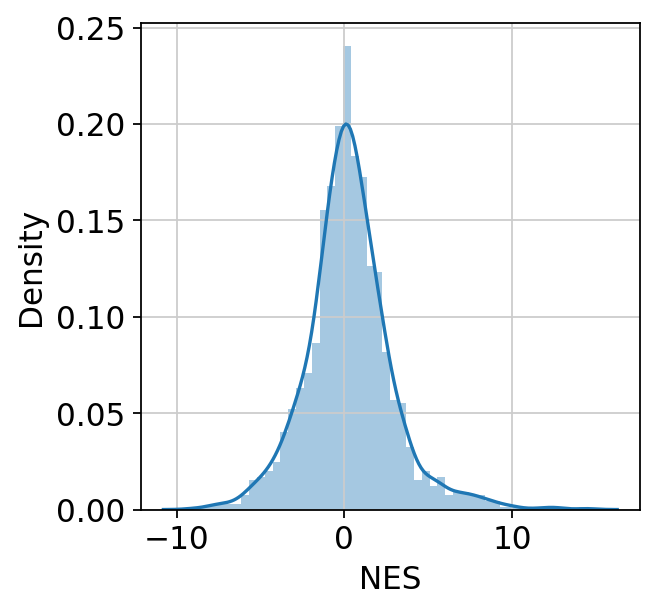

In [8]:
sns.distplot(TF_activities['GC_vs_iEVT']['NES'])

## Adding another layer of evidence: differential expression

In [7]:
# all TF regulons list, same in all tables
TFs_list = list(TF_activities['GC_vs_iEVT']['TF_name'])

In [8]:
len(TFs_list)

1385

In [9]:
# reading in tables of DE for ct-vs-previous_ct comparisons

DEGs = {}

DEGs_significant_upreg = {}

DEGs_significant_upreg_TFs = {} # intersection of significant upreg DEGs with all TFs list

DEGs_significant_downreg = {}

DEGs_significant_downreg_TFs = {} # intersection of significant downreg DEGs with all TFs list

for comparison in comparisons:
    print(comparison)
    DEGs[comparison] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_sc_sn_Integrated_analysis/new_scVI_analysis/CellPhone_analysis/limma_DEGs/20211123/20211123_' + comparison + '_limma_DEGs.csv', 
                                   index_col=0)
    DEGs_significant_upreg[comparison] = DEGs[comparison][DEGs[comparison]['adj.P.Val'] < 0.05]
    DEGs_significant_upreg[comparison] = DEGs_significant_upreg[comparison][DEGs_significant_upreg[comparison]['logFC'] > 0]
    
    DEGs_significant_upreg_TFs[comparison] = DEGs_significant_upreg[comparison].loc[list(set(TFs_list) & set(DEGs_significant_upreg[comparison].index)),:]
    
    
    DEGs_significant_downreg[comparison] = DEGs[comparison][DEGs[comparison]['adj.P.Val'] < 0.05]
    DEGs_significant_downreg[comparison] = DEGs_significant_downreg[comparison][DEGs_significant_downreg[comparison]['logFC'] < 0]
    
    DEGs_significant_downreg_TFs[comparison] = DEGs_significant_downreg[comparison].loc[list(set(TFs_list) & set(DEGs_significant_downreg[comparison].index)),:]
    
    
    print('number of DEGs overall:', len(DEGs[comparison]))
    print('number of significant upreg DEGs:', len(DEGs_significant_upreg[comparison]))
    print('number of significant upreg DEGs that are TFs:', len(DEGs_significant_upreg_TFs[comparison]))
    print('number of significant upreg DEGs:', len(DEGs_significant_downreg[comparison]))
    print('number of significant upreg DEGs that are TFs:', len(DEGs_significant_downreg_TFs[comparison]),'\n')


GC_vs_iEVT
number of DEGs overall: 26527
number of significant upreg DEGs: 560
number of significant upreg DEGs that are TFs: 29
number of significant upreg DEGs: 76
number of significant upreg DEGs that are TFs: 6 

iEVT_vs_EVT_2
number of DEGs overall: 27028
number of significant upreg DEGs: 4876
number of significant upreg DEGs that are TFs: 291
number of significant upreg DEGs: 1807
number of significant upreg DEGs that are TFs: 110 

eEVT_vs_EVT_2
number of DEGs overall: 24648
number of significant upreg DEGs: 2148
number of significant upreg DEGs that are TFs: 129
number of significant upreg DEGs: 89
number of significant upreg DEGs that are TFs: 9 

EVT_2_vs_EVT_1
number of DEGs overall: 26611
number of significant upreg DEGs: 2513
number of significant upreg DEGs that are TFs: 212
number of significant upreg DEGs: 6741
number of significant upreg DEGs that are TFs: 280 

EVT_1_vs_VCT_CCC
number of DEGs overall: 26889
number of significant upreg DEGs: 4603
number of significant 

In [10]:
DEGs_significant_downreg_TFs['EVT_1_vs_VCT_CCC'].loc['ARID5B']

logFC                 -9.144488e-02
P.Value                4.237113e-11
adj.P.Val              2.230457e-10
AveExpr_cluster        6.205820e-01
AveExpr_rest           7.377060e-01
percentExpr_cluster    7.230100e-01
percentExpr_rest       6.605400e-01
Name: ARID5B, dtype: float64

## Adding another layer of evidence: accessibility of binding motif (according to information from ATAC)

In [11]:
# reading in tables of DA TF motifs for ct-vs-previous_ct comparisons
DA_motifs_chromVar_upreg = {}
DA_motifs_chromVar_downreg = {}

outdir = '/lustre/scratch117/cellgen/team292/aa22/with_Stijn/202111_snATAC-seq_data_MFI/multiome_ATAC_samples_analysis/trophoblast_only_analysis/downstream_analysis_custom_clust/'

for comparison in comparisons:
    print(comparison)
    
    if comparison in  ['eEVT_vs_EVT_2','GC_vs_iEVT']:
        # read tables with appropriate downsampled versions of these tests
        DA_motifs_chromVar_upreg[comparison] = pd.read_csv(outdir + 'DA_TF_binding_motifs_' + comparison + '_downsampled.csv', index_col=0)
        DA_motifs_chromVar_downreg[comparison] = pd.read_csv(outdir + 'DA_TF_binding_motifs_' + comparison + '_downsampled.csv', index_col=0)
    
    else:
        DA_motifs_chromVar_upreg[comparison] = pd.read_csv(outdir + 'DA_TF_binding_motifs_' + comparison + '.csv', index_col=0)
        DA_motifs_chromVar_downreg[comparison] = pd.read_csv(outdir + 'DA_TF_binding_motifs_' + comparison + '.csv', index_col=0)
    
    
    # using 0.05 threshold for p_val_adj
    DA_motifs_chromVar_upreg[comparison] = DA_motifs_chromVar_upreg[comparison][DA_motifs_chromVar_upreg[comparison]['p_val_adj'] < 0.05]
    
    # taking only those that are upreg in comparison
    DA_motifs_chromVar_upreg[comparison] = DA_motifs_chromVar_upreg[comparison][DA_motifs_chromVar_upreg[comparison]['avg_log2FC'] > 0]
    
    # get the name of TF - the values in this column may not be unique (evidence for a certain TF may come from different databases) and that's OK
    DA_motifs_chromVar_upreg[comparison]['TF'] = [idx.split('.')[0] for idx in DA_motifs_chromVar_upreg[comparison].index]
    
    
    # using 0.05 threshold for p_val_adj
    DA_motifs_chromVar_downreg[comparison] = DA_motifs_chromVar_downreg[comparison][DA_motifs_chromVar_downreg[comparison]['p_val_adj'] < 0.05]
    
    # taking only those that are upreg in comparison
    DA_motifs_chromVar_downreg[comparison] = DA_motifs_chromVar_downreg[comparison][DA_motifs_chromVar_downreg[comparison]['avg_log2FC'] < 0]
    
    # get the name of TF - the values in this column may not be unique (evidence for a certain TF may come from different databases) and that's OK
    DA_motifs_chromVar_downreg[comparison]['TF'] = [idx.split('.')[0] for idx in DA_motifs_chromVar_downreg[comparison].index]
    
    
    print('significant upreg DA TF motifs:', len(DA_motifs_chromVar_upreg[comparison]))
    print('significant downreg DA TF motifs:', len(DA_motifs_chromVar_downreg[comparison]))
    
    print()
    
    print('\n')

GC_vs_iEVT
significant upreg DA TF motifs: 2
significant downreg DA TF motifs: 31



iEVT_vs_EVT_2
significant upreg DA TF motifs: 137
significant downreg DA TF motifs: 23



eEVT_vs_EVT_2
significant upreg DA TF motifs: 0
significant downreg DA TF motifs: 0



EVT_2_vs_EVT_1
significant upreg DA TF motifs: 10
significant downreg DA TF motifs: 7



EVT_1_vs_VCT_CCC
significant upreg DA TF motifs: 42
significant downreg DA TF motifs: 92



VCT_CCC_vs_VCT
significant upreg DA TF motifs: 33
significant downreg DA TF motifs: 5





## Adding another layer of evidence: presence of Tf binding motif in MEFISTO results

### For this we need a definition of microenvironments based on MEFISTO factors and a translation of those into relevant DE/DA comparisons

This is done in the following notebook:` ./MOFA_MEFISTO/S3_DEG_comparison_to_MEFISTO_factor_translation.ipynb`

#### Reading in TF motifs prioritised with MEFISTO results

In [12]:
# these are results for model trained on 09.02.2022 including VCT population
TFs_MEFISTO_upreg = pd.read_csv('./MOFA_MEFISTO/20220210_MEFISTO_TF_motif_results_upreg.csv', index_col=0)
TFs_MEFISTO_downreg = pd.read_csv('./MOFA_MEFISTO/20220210_MEFISTO_TF_motif_results_downreg.csv', index_col=0)

In [13]:
# for now take all factors and have a look
factors = [str(i+1) for i in range(0,10)]


In [14]:
TFs_MEFISTO_per_factor_upreg = {}

for factor in factors:
    print('Factor' + factor)
    curr_cols = [col for col in TFs_MEFISTO_upreg.columns if col.split('.')[-1] == 'Factor' + factor]
    TFs_MEFISTO_per_factor_upreg['Factor' + factor] = TFs_MEFISTO_upreg.loc[:,curr_cols]
    
    # subset to only results with adj.pval < 0.05
    TFs_MEFISTO_per_factor_upreg['Factor' + factor] = TFs_MEFISTO_per_factor_upreg['Factor' + factor][TFs_MEFISTO_per_factor_upreg['Factor' + factor]['adj.pval.Factor' + factor] < 0.05]
    
    # subset to only results with 'setstats.Factor' + factor > 0
    TFs_MEFISTO_per_factor_upreg['Factor' + factor] = TFs_MEFISTO_per_factor_upreg['Factor' + factor][TFs_MEFISTO_per_factor_upreg['Factor' + factor]['setstats.Factor' + factor] > 0]
    
    
    print('number of significant TFs here:', TFs_MEFISTO_per_factor_upreg['Factor' + factor].shape[0])

Factor1
number of significant TFs here: 269
Factor2
number of significant TFs here: 191
Factor3
number of significant TFs here: 139
Factor4
number of significant TFs here: 0
Factor5
number of significant TFs here: 347
Factor6
number of significant TFs here: 55
Factor7
number of significant TFs here: 18
Factor8
number of significant TFs here: 75
Factor9
number of significant TFs here: 15
Factor10
number of significant TFs here: 51


In [15]:
# factor 5 is technical (non-smooth along pseudotime, ATAC-coverage driven)

In [16]:
TFs_MEFISTO_downreg['setstats.Factor1']

FOXF2          0.000000
FOXD1          0.000000
IRF2           0.000000
MZF1(var.2)    3.704940
MAX::MYC       3.148657
                 ...   
USF1           0.000000
USF2           0.008479
YY2            5.301207
ZNF263         5.119913
CREM           1.539579
Name: setstats.Factor1, Length: 633, dtype: float64

In [17]:
TFs_MEFISTO_per_factor_downreg = {}

for factor in factors:
    print('Factor' + factor)
    curr_cols = [col for col in TFs_MEFISTO_downreg.columns if col.split('.')[-1] == 'Factor' + factor]
    TFs_MEFISTO_per_factor_downreg['Factor' + factor] = TFs_MEFISTO_downreg.loc[:,curr_cols]
    
    # subset to only results with adj.pval < 0.05
    TFs_MEFISTO_per_factor_downreg['Factor' + factor] = TFs_MEFISTO_per_factor_downreg['Factor' + factor][TFs_MEFISTO_per_factor_downreg['Factor' + factor]['adj.pval.Factor' + factor] < 0.05]
    
    # subset to only results with 'setstats.Factor' + factor > 0 - a bit not intuitive but in this table that's the enrichment in negative weights!
    TFs_MEFISTO_per_factor_downreg['Factor' + factor] = TFs_MEFISTO_per_factor_downreg['Factor' + factor][TFs_MEFISTO_per_factor_downreg['Factor' + factor]['setstats.Factor' + factor] > 0]
    
    
    print('number of significant TFs here:', TFs_MEFISTO_per_factor_downreg['Factor' + factor].shape[0])

Factor1
number of significant TFs here: 164
Factor2
number of significant TFs here: 40
Factor3
number of significant TFs here: 0
Factor4
number of significant TFs here: 166
Factor5
number of significant TFs here: 1
Factor6
number of significant TFs here: 7
Factor7
number of significant TFs here: 33
Factor8
number of significant TFs here: 123
Factor9
number of significant TFs here: 28
Factor10
number of significant TFs here: 308


In [18]:
TFs_MEFISTO_per_factor_downreg['Factor1']

pval.Factor1  adj.pval.Factor1  setstats.Factor1
MZF1(var.2)    2.125122e-04      1.149745e-03          3.704940
MAX::MYC       1.644762e-03      6.673939e-03          3.148657
RREB1          5.780883e-06      3.934730e-05          4.536547
REL            3.612878e-05      2.198992e-04          4.132691
RELA           9.556424e-04      4.240528e-03          3.304195
...                     ...               ...               ...
TCF4           1.083092e-06      7.880425e-06          4.878748
TFAP2C(var.2)  3.551417e-11      4.887058e-10          6.628664
TWIST1         1.070700e-02      3.152341e-02          2.552569
YY2            1.173433e-07      9.903775e-07          5.301207
ZNF263         3.110211e-07      2.400931e-06          5.119913

[164 rows x 3 columns]

In [19]:
TFs_MEFISTO_per_factor_downreg['Factor6']

pval.Factor6  adj.pval.Factor6  setstats.Factor6
JDP2             0.000563          0.016981          3.449721
FOS::JUN         0.003190          0.045931          2.949441
FOSL1::JUN       0.003244          0.045931          2.944301
FOSL2::JUN       0.001207          0.028294          3.238130
FOS::JUNB        0.001710          0.033822          3.137291
FOSL1::JUND      0.003232          0.045931          2.945406
ATF4             0.001533          0.031311          3.169112

In [20]:
# here there are some TF motifs that can be both upreg and downreg at the same time, most probably their annotation is not trustworthy so just remove them
ambiguous_TF_motifs = {}

for factor in factors:
    print('Factor' + factor)
    
    curr_ambiguous_TF_motifs = list(set(TFs_MEFISTO_per_factor_upreg['Factor' + factor].index) & set(TFs_MEFISTO_per_factor_downreg['Factor' + factor].index))

    ambiguous_TF_motifs['Factor' + factor] = curr_ambiguous_TF_motifs
    
    print('ambiguous motifs here:', ambiguous_TF_motifs['Factor' + factor], '\n')
    

Factor1
ambiguous motifs here: ['TWIST1', 'VENTX'] 

Factor2
ambiguous motifs here: ['ETS2', 'ELK3', 'FEV', 'JUN::JUNB(var.2)', 'ZBTB7A', 'CREB3L4(var.2)', 'ETV5', 'FLI1', 'ERF', 'ETV3', 'ZNF263', 'ETS1', 'GLI2', 'CREM', 'JUNB(var.2)', 'ELK1', 'ETV6', 'NFIB', 'ELF4', 'ELK4'] 

Factor3
ambiguous motifs here: [] 

Factor4
ambiguous motifs here: [] 

Factor5
ambiguous motifs here: [] 

Factor6
ambiguous motifs here: ['JDP2', 'FOS::JUNB', 'FOS::JUN', 'FOSL1::JUND', 'FOSL1::JUN', 'FOSL2::JUN'] 

Factor7
ambiguous motifs here: [] 

Factor8
ambiguous motifs here: ['MAZ', 'ZNF682', 'INSM1', 'HINFP', 'KLF10', 'SP9', 'SP3', 'ZBTB7A', 'NRF1', 'ELK4', 'GLI3', 'EGR1', 'RARA::RXRG', 'ETV5', 'EGR4', 'ZBTB33', 'TFAP2B(var.2)', 'KLF9', 'TFAP2C(var.2)', 'KLF3', 'ZNF148', 'SP2', 'ZKSCAN5', 'EWSR1-FLI1', 'SP4', 'ZBTB14', 'SP1', 'TFAP2E', 'ZNF460', 'ZIC3', 'TCFL5', 'KLF16', 'YY2', 'ZIC1', 'SP8', 'EGR2', 'KLF11', 'EGR3', 'GLI2', 'RREB1', 'KLF2', 'CTCFL', 'KLF5', 'CTCF', 'TFDP1', 'KLF6', 'ZIC4', 'NR2C2', 'KL

In [21]:
# drop ambiguougs TFs from mefisto tables
for factor in factors:
    print('Factor' + factor)
    
    for TF in ambiguous_TF_motifs['Factor' + factor]:
        print('dropping row for TF motif:', TF)
        TFs_MEFISTO_per_factor_upreg['Factor' + factor].drop(labels=TF, axis=0)
        TFs_MEFISTO_per_factor_downreg['Factor' + factor].drop(labels=TF, axis=0)
    

Factor1
dropping row for TF motif: TWIST1
dropping row for TF motif: VENTX
Factor2
dropping row for TF motif: ETS2
dropping row for TF motif: ELK3
dropping row for TF motif: FEV
dropping row for TF motif: JUN::JUNB(var.2)
dropping row for TF motif: ZBTB7A
dropping row for TF motif: CREB3L4(var.2)
dropping row for TF motif: ETV5
dropping row for TF motif: FLI1
dropping row for TF motif: ERF
dropping row for TF motif: ETV3
dropping row for TF motif: ZNF263
dropping row for TF motif: ETS1
dropping row for TF motif: GLI2
dropping row for TF motif: CREM
dropping row for TF motif: JUNB(var.2)
dropping row for TF motif: ELK1
dropping row for TF motif: ETV6
dropping row for TF motif: NFIB
dropping row for TF motif: ELF4
dropping row for TF motif: ELK4
Factor3
Factor4
Factor5
Factor6
dropping row for TF motif: JDP2
dropping row for TF motif: FOS::JUNB
dropping row for TF motif: FOS::JUN
dropping row for TF motif: FOSL1::JUND
dropping row for TF motif: FOSL1::JUN
dropping row for TF motif: FOSL2

## Marking the union of all the TFs according to the 3 measures

In [22]:
# for translation of DEG comparisons to MEFISTO factors, using results from ./MOFA_MEFISTO/S3_DEG_comparison_to_MEFISTO_factor_translation.ipynb notebook
translation_df_DE_comparisons2factors = pd.read_csv('./MOFA_MEFISTO/20220213_translation_df_comparison2factor.csv', index_col=0)
translation_df_DE_comparisons2factors

MEFISTO_factor contribution
VCT_CCC_vs_VCT     X_mofa_Factor2            +
EVT_1_vs_VCT_CCC   X_mofa_Factor4            +
EVT_2_vs_EVT_1     X_mofa_Factor2            -
eEVT_vs_EVT_2     X_mofa_Factor10            +
iEVT_vs_EVT_2      X_mofa_Factor4            -
GC_vs_iEVT         X_mofa_Factor6            -

In [23]:
translation_df_DE_comparisons2factors.loc['eEVT_vs_EVT_2','MEFISTO_factor'].split('X_mofa_Factor')[1]

'10'

In [24]:
DEGs_significant_downreg_TFs['GC_vs_iEVT']

logFC   P.Value  adj.P.Val  AveExpr_cluster  AveExpr_rest  \
Gene                                                                   
ZNF254 -0.565847  0.000014   0.001375         0.044371      0.453265   
JARID2 -0.662784  0.000156   0.009716         0.899503      1.200099   
FOXN3  -0.834499  0.000059   0.004432         1.004486      1.385099   
CUX1   -0.695141  0.000068   0.004915         2.415243      2.406472   
ARNT   -0.607249  0.000010   0.001033         0.036521      0.516625   
TEAD1  -0.850908  0.000008   0.000878         2.746029      2.833754   

        percentExpr_cluster  percentExpr_rest  
Gene                                           
ZNF254             0.052632          0.424646  
JARID2             0.578947          0.728237  
FOXN3              0.526316          0.720076  
CUX1               0.947368          0.891730  
ARNT               0.052632          0.501904  
TEAD1              0.842105          0.907780

In [25]:
TFs_upregulated_per_comparison = {}

TFs_downregulated_per_comparison = {}

for comparison in comparisons:
    print(comparison)
    
    
    TFs_upregulated_per_comparison[comparison] = pd.DataFrame(index = set(list(DEGs_significant_upreg_TFs[comparison].index) + list(TF_activities_upreg[comparison]['TF_name'])))
    TFs_downregulated_per_comparison[comparison] = pd.DataFrame(index = set(list(DEGs_significant_downreg_TFs[comparison].index) + list(TF_activities_downreg[comparison]['TF_name'])))

    TFs_upregulated_per_comparison[comparison]['Avg_expr'] = ['na']*len(TFs_upregulated_per_comparison[comparison])
    TFs_downregulated_per_comparison[comparison]['Avg_expr'] = ['na']*len(TFs_downregulated_per_comparison[comparison])
    
    TFs_upregulated_per_comparison[comparison]['is_DE_limma'] = ['na']*len(TFs_upregulated_per_comparison[comparison])
    TFs_upregulated_per_comparison[comparison]['is_DA_dorothea'] = ['na']*len(TFs_upregulated_per_comparison[comparison]) # DA for differentially active
    TFs_upregulated_per_comparison[comparison]['is_DA_chromVar'] = ['na']*len(TFs_upregulated_per_comparison[comparison]) # DA for differentially acsessible motif
    TFs_upregulated_per_comparison[comparison]['is_DA_MEFISTO'] = ['na']*len(TFs_upregulated_per_comparison[comparison]) # DA for enriched motif in relevant MEFISTO factors

    TFs_downregulated_per_comparison[comparison]['is_DE_limma'] = ['na']*len(TFs_downregulated_per_comparison[comparison])
    TFs_downregulated_per_comparison[comparison]['is_DA_dorothea'] = ['na']*len(TFs_downregulated_per_comparison[comparison]) # DA for differentially active
    TFs_downregulated_per_comparison[comparison]['is_DA_chromVar'] = ['na']*len(TFs_downregulated_per_comparison[comparison]) # DA for differentially acsessible motif
    TFs_downregulated_per_comparison[comparison]['is_DA_MEFISTO'] = ['na']*len(TFs_downregulated_per_comparison[comparison]) # DA for enriched motif in relevant MEFISTO factors

    
    # add whether TF is coming from limma DE or DoRothEA or both
    TFs_upregulated_per_comparison[comparison]['is_DE_limma'] = ['yes' if TF in list(DEGs_significant_upreg_TFs[comparison].index) else 'no' for TF in TFs_upregulated_per_comparison[comparison].index]
    TFs_upregulated_per_comparison[comparison]['is_DA_dorothea'] = ['yes' if TF in list(TF_activities_upreg[comparison]['TF_name']) else 'no' for TF in TFs_upregulated_per_comparison[comparison].index]
    TFs_upregulated_per_comparison[comparison]['is_DA_chromVar'] = ['yes' if TF in list(DA_motifs_chromVar_upreg[comparison]['TF']) else 'no' for TF in TFs_upregulated_per_comparison[comparison].index]

    # add whether TF is coming from limma DE or DoRothEA or both
    TFs_downregulated_per_comparison[comparison]['is_DE_limma'] = ['yes' if TF in list(DEGs_significant_downreg_TFs[comparison].index) else 'no' for TF in TFs_downregulated_per_comparison[comparison].index]
    TFs_downregulated_per_comparison[comparison]['is_DA_dorothea'] = ['yes' if TF in list(TF_activities_downreg[comparison]['TF_name']) else 'no' for TF in TFs_downregulated_per_comparison[comparison].index]
    TFs_downregulated_per_comparison[comparison]['is_DA_chromVar'] = ['yes' if TF in list(DA_motifs_chromVar_downreg[comparison]['TF']) else 'no' for TF in TFs_downregulated_per_comparison[comparison].index]

    
    # filling in MEFISTO column
    # translating from comparison to factor language for further use of MEFISTO results
    
    # this is a 1-element list in my current design
    mefisto_factor = translation_df_DE_comparisons2factors.loc[comparison,'MEFISTO_factor'].split('X_mofa_Factor')[1]
    
    print('working with factor', mefisto_factor)
    
    # either '+' or '-'
    sign_of_contribution = translation_df_DE_comparisons2factors.loc[comparison,'contribution']
    
    print('sign_of_contribution', sign_of_contribution)
    
    
    # in both of the following cases we care about + and - enriched TFs of a factor, just in different directions
    if sign_of_contribution == '+':
        # fill in relevant info about upreg MEFISTO results, direct connection
        TFs_relevant_for_current_ME_upreg = list(TFs_MEFISTO_per_factor_upreg['Factor' + mefisto_factor].index)
        #TFs_relevant_for_current_ME_upreg = [item for sublist in TFs_relevant_for_current_ME_upreg for item in sublist]
        TFs_relevant_for_current_ME_upreg = list(set(TFs_relevant_for_current_ME_upreg))
        
        TFs_relevant_for_current_ME_downreg = list(TFs_MEFISTO_per_factor_downreg['Factor' + mefisto_factor].index)
        #TFs_relevant_for_current_ME_downreg = [item for sublist in TFs_MEFISTO_per_factor_downreg for item in sublist]
        TFs_relevant_for_current_ME_downreg = list(set(TFs_relevant_for_current_ME_downreg))
        
        #print('TFs_relevant_for_current_ME_upreg',TFs_relevant_for_current_ME_upreg)
        #print('TFs_relevant_for_current_ME_downreg', TFs_relevant_for_current_ME_downreg)

        
    elif sign_of_contribution == '-':
        # fill in relevant info about downreg MEFISTO results, reverse connection      
        TFs_relevant_for_current_ME_upreg = list(TFs_MEFISTO_per_factor_downreg['Factor' + mefisto_factor].index)
        #TFs_relevant_for_current_ME_upreg = [item for sublist in TFs_MEFISTO_per_factor_downreg for item in sublist]
        TFs_relevant_for_current_ME_upreg = list(set(TFs_relevant_for_current_ME_upreg))
        
        TFs_relevant_for_current_ME_downreg = list(TFs_MEFISTO_per_factor_upreg['Factor' + mefisto_factor].index)
        #TFs_relevant_for_current_ME_downreg = [item for sublist in TFs_MEFISTO_per_factor_upreg for item in sublist]
        TFs_relevant_for_current_ME_downreg = list(set(TFs_relevant_for_current_ME_downreg))
        
        #print([item for sublist in TFs_MEFISTO_per_factor_downreg for item in sublist])
        
        #print('TFs_relevant_for_current_ME_upreg',TFs_relevant_for_current_ME_upreg)
        #print('TFs_relevant_for_current_ME_downreg', TFs_relevant_for_current_ME_downreg)

        
    # it will be yes/no for TFs in relevant MEs and remain 'na' for others
    TFs_upregulated_per_comparison[comparison]['is_DA_MEFISTO'] = ['yes' if TF in TFs_relevant_for_current_ME_upreg else 'no' for TF in TFs_upregulated_per_comparison[comparison].index]
    TFs_downregulated_per_comparison[comparison]['is_DA_MEFISTO'] = ['yes' if TF in TFs_relevant_for_current_ME_downreg else 'no' for TF in TFs_downregulated_per_comparison[comparison].index]

    
    
    
    # is the TF DE and DA (by either dorothea or chromvar)
    TFs_upregulated_per_comparison[comparison]['is_DE_and_DA'] = ['yes' if (DE == 'yes' and (DA_dorothea == 'yes' or DA_chromVar == 'yes' or DA_MEFISTO == 'yes')) else 'no' for DE,DA_dorothea,DA_chromVar,DA_MEFISTO in zip(TFs_upregulated_per_comparison[comparison]['is_DE_limma'],
                                                                                                                                                                TFs_upregulated_per_comparison[comparison]['is_DA_dorothea'],
                                                                                                                                                                TFs_upregulated_per_comparison[comparison]['is_DA_chromVar'],
                                                                                                                                                                TFs_upregulated_per_comparison[comparison]['is_DA_MEFISTO'])]
    
    # is the TF DE and DA (by either dorothea or chromvar)
    TFs_downregulated_per_comparison[comparison]['is_DE_and_DA'] = ['yes' if (DE == 'yes' and (DA_dorothea == 'yes' or DA_chromVar == 'yes' or DA_MEFISTO == 'yes')) else 'no' for DE,DA_dorothea,DA_chromVar,DA_MEFISTO in zip(TFs_downregulated_per_comparison[comparison]['is_DE_limma'],
                                                                                                                                                                TFs_downregulated_per_comparison[comparison]['is_DA_dorothea'],
                                                                                                                                                                TFs_downregulated_per_comparison[comparison]['is_DA_chromVar'],
                                                                                                                                                                TFs_downregulated_per_comparison[comparison]['is_DA_MEFISTO'])]
    
    
    print('number of TFs upregulated here:', len(TFs_upregulated_per_comparison[comparison]))
    print('number of TFs downregulated here:', len(TFs_downregulated_per_comparison[comparison]))
    
    # necessary for CellSign
    TFs_upregulated_per_comparison[comparison]['cluster'] = comparison.split('_vs_')[0]
    TFs_upregulated_per_comparison[comparison]['ID'] = [cluster + '_' + TF for cluster,TF in zip(TFs_upregulated_per_comparison[comparison]['cluster'],
                                                                                               TFs_upregulated_per_comparison[comparison].index)]
    
    # necessary for CellSign
    TFs_downregulated_per_comparison[comparison]['cluster'] = comparison.split('_vs_')[0]
    TFs_downregulated_per_comparison[comparison]['ID'] = [cluster + '_' + TF for cluster,TF in zip(TFs_downregulated_per_comparison[comparison]['cluster'],
                                                                                               TFs_downregulated_per_comparison[comparison].index)]
    
    
    print('is_DE_and_DA upreg', np.unique(TFs_upregulated_per_comparison[comparison]['is_DE_and_DA'], return_counts=True), '\n')
    print('is_DE_and_DA downreg', np.unique(TFs_downregulated_per_comparison[comparison]['is_DE_and_DA'], return_counts=True), '\n')
   
    
    for TF in TFs_upregulated_per_comparison[comparison].index:
        #print(TF)
        
        # add average expression from overall unfiltered limma table if it's there
        if TF in DEGs[comparison].index: # if it's expressed enough according to limma
            TFs_upregulated_per_comparison[comparison].loc[TF,'Avg_expr'] = DEGs[comparison].loc[TF,'AveExpr_cluster']
        else:
            TFs_upregulated_per_comparison[comparison].loc[TF,'Avg_expr'] = 'not_enough_cells_expr_limma'
            
    for TF in TFs_downregulated_per_comparison[comparison].index:
        #print(TF)
        
        # add average expression from overall unfiltered limma table if it's there
        if TF in DEGs[comparison].index: # if it's expressed enough according to limma
            TFs_downregulated_per_comparison[comparison].loc[TF,'Avg_expr'] = DEGs[comparison].loc[TF,'AveExpr_cluster']
        else:
            TFs_downregulated_per_comparison[comparison].loc[TF,'Avg_expr'] = 'not_enough_cells_expr_limma'
            
            
            
    
    

GC_vs_iEVT
working with factor 6
sign_of_contribution -
number of TFs upregulated here: 223
number of TFs downregulated here: 164
is_DE_and_DA upreg (array(['no', 'yes'], dtype=object), array([219,   4])) 

is_DE_and_DA downreg (array(['no', 'yes'], dtype=object), array([163,   1])) 

iEVT_vs_EVT_2
working with factor 4
sign_of_contribution -
number of TFs upregulated here: 600
number of TFs downregulated here: 218
is_DE_and_DA upreg (array(['no', 'yes'], dtype=object), array([435, 165])) 

is_DE_and_DA downreg (array(['no', 'yes'], dtype=object), array([195,  23])) 

eEVT_vs_EVT_2
working with factor 10
sign_of_contribution +
number of TFs upregulated here: 623
number of TFs downregulated here: 98
is_DE_and_DA upreg (array(['no', 'yes'], dtype=object), array([569,  54])) 

is_DE_and_DA downreg (array(['no', 'yes'], dtype=object), array([94,  4])) 

EVT_2_vs_EVT_1
working with factor 2
sign_of_contribution -
number of TFs upregulated here: 535
number of TFs downregulated here: 486
is_D

In [26]:
TFs_MEFISTO_per_factor_downreg['Factor4'].loc['MEF2C']

pval.Factor4        1.103707e-09
adj.pval.Factor4    8.625263e-09
setstats.Factor4    6.099106e+00
Name: MEF2C, dtype: float64

In [27]:
TFs_upregulated_per_comparison['GC_vs_iEVT']['is_DE_and_DA'].value_counts()

no     219
yes      4
Name: is_DE_and_DA, dtype: int64

In [28]:
TFs_downregulated_per_comparison['iEVT_vs_EVT_2'].loc['MEF2C']

Avg_expr            0.065036
is_DE_limma              yes
is_DA_dorothea            no
is_DA_chromVar            no
is_DA_MEFISTO             no
is_DE_and_DA              no
cluster                 iEVT
ID                iEVT_MEF2C
Name: MEF2C, dtype: object

In [29]:
TFs_upregulated_per_comparison['GC_vs_iEVT'][TFs_upregulated_per_comparison['GC_vs_iEVT']['is_DE_and_DA'] == 'yes']

Avg_expr is_DE_limma is_DA_dorothea is_DA_chromVar is_DA_MEFISTO  \
BATF2    0.07348         yes            yes             no            no   
THAP7   0.190747         yes            yes             no            no   
EBF2    0.072357         yes            yes             no            no   
ZNF517  0.102592         yes            yes             no            no   

       is_DE_and_DA cluster         ID  
BATF2           yes      GC   GC_BATF2  
THAP7           yes      GC   GC_THAP7  
EBF2            yes      GC    GC_EBF2  
ZNF517          yes      GC  GC_ZNF517

In [30]:
'ATF4' in TFs_downregulated_per_comparison['GC_vs_iEVT'].index

False

In [31]:
TFs_upregulated_per_comparison['eEVT_vs_EVT_2'][TFs_upregulated_per_comparison['eEVT_vs_EVT_2']['is_DE_and_DA'] == 'yes']

Avg_expr is_DE_limma is_DA_dorothea is_DA_chromVar is_DA_MEFISTO  \
ZNF33A   0.792636         yes            yes             no            no   
FOXJ3    2.441269         yes            yes             no            no   
ZSCAN32  0.117342         yes            yes             no            no   
ZNF562   1.325516         yes            yes             no            no   
ZNF260   0.205264         yes            yes             no            no   
ZNF699   0.135793         yes            yes             no            no   
ZNF484    0.20185         yes            yes             no            no   
ZNF571   0.180884         yes            yes             no            no   
MEF2D    0.325915         yes            yes             no           yes   
VAX2     0.022318         yes             no             no           yes   
PRDM15   0.222119         yes            yes             no            no   
ZNF780A  0.301214         yes            yes             no            no   
ZNF420   0.387925         yes            yes             no            no   
ZNF570   0.239831         yes            yes             no            no   
ZNF512   0.289458         yes            yes             no            no   
GCM1     2.208438         yes            yes             no            no   
GRHL1    1.825121         yes            yes             no            no   
PLAGL1   0.987646         yes            yes             no            no   
ZNF426   0.128865         yes            yes             no            no   
ARID3B   0.741599         yes            yes             no            no   
ZNF814   0.705763         yes            yes             no            no   
ZNF121   0.944574         yes            yes             no            no   
NRL      0.081464         yes            yes             no            no   
NFAT5    1.525117         yes            yes             no            no   
ZNF708   0.474493         yes            yes             no            no   
ZNF674   0.124892         yes            yes             no            no   
LRRFIP2  1.227765         yes            yes             no            no   
ZNF552   0.260883         yes            yes             no            no   
ZNF142   0.264097         yes            yes             no            no   
ZNF451    1.39886         yes            yes             no            no   
ZNF441   0.129003         yes            yes             no            no   
ZNF692    0.31409         yes            yes             no            no   
ZNF641   0.095406         yes            yes             no            no   
TFDP2    1.649224         yes            yes             no            no   
ZNF561   0.354768         yes            yes             no            no   
HMGA2    0.269928         yes            yes             no            no   
ZNF569   0.257402         yes            yes             no            no   
ZNF611   0.896305         yes            yes             no            no   
ZNF586   0.537345         yes            yes             no            no   
ZNF345   0.374372         yes            yes             no            no   
ZNF124   0.696275         yes            yes             no            no   
ZNF736   0.495433         yes            yes             no            no   
ZNF846   0.518781         yes            yes             no            no   
ZNF585B  0.077078         yes            yes             no            no   
ZBTB40   0.541899         yes            yes             no            no   
ELF1     1.583648         yes            yes             no            no   
SOX4     1.335623         yes            yes             no            no   
ZNF280C  0.325558         yes            yes             no            no   
BARX2    0.068302         yes             no             no           yes   
ZNF793   0.292027         yes            yes             no            no   
UBP1     0.507999         yes            yes             no            no   
ZNF25

In [32]:
TFs_downregulated_per_comparison['eEVT_vs_EVT_2']

Avg_expr is_DE_limma is_DA_dorothea is_DA_chromVar  \
HIC2                       0.747197          no            yes             no   
NR5A1   not_enough_cells_expr_limma          no            yes             no   
ZNF606                     0.053463          no            yes             no   
HAND1                           0.0          no            yes             no   
RCOR3                      0.259708          no            yes             no   
...                             ...         ...            ...            ...   
FOXM1                           0.0          no            yes             no   
ZBTB7B                     0.098668          no            yes             no   
CREB5                      0.161132         yes             no             no   
RFX2                        0.21434         yes             no             no   
HIF1A                      0.881058          no            yes             no   

       is_DA_MEFISTO is_DE_and_DA cluster           ID  
HIC2             yes           no    eEVT    eEVT_HIC2  
NR5A1            yes           no    eEVT   eEVT_NR5A1  
ZNF606            no           no    eEVT  eEVT_ZNF606  
HAND1             no           no    eEVT   eEVT_HAND1  
RCOR3             no           no    eEVT   eEVT_RCOR3  
...              ...          ...     ...          ...  
FOXM1             no           no    eEVT   eEVT_FOXM1  
ZBTB7B           yes           no    eEVT  eEVT_ZBTB7B  
CREB5             no           no    eEVT   eEVT_CREB5  
RFX2             yes          yes    eEVT    eEVT_RFX2  
HIF1A            yes           no    eEVT   eEVT_HIF1A  

[98 rows x 8 columns]

In [33]:
TFs_upregulated_per_comparison['GC_vs_iEVT'][TFs_upregulated_per_comparison['GC_vs_iEVT']['is_DE_and_DA'] == 'yes']

Avg_expr is_DE_limma is_DA_dorothea is_DA_chromVar is_DA_MEFISTO  \
BATF2    0.07348         yes            yes             no            no   
THAP7   0.190747         yes            yes             no            no   
EBF2    0.072357         yes            yes             no            no   
ZNF517  0.102592         yes            yes             no            no   

       is_DE_and_DA cluster         ID  
BATF2           yes      GC   GC_BATF2  
THAP7           yes      GC   GC_THAP7  
EBF2            yes      GC    GC_EBF2  
ZNF517          yes      GC  GC_ZNF517

In [34]:
TFs_upregulated_per_comparison['eEVT_vs_EVT_2'][TFs_upregulated_per_comparison['eEVT_vs_EVT_2']['is_DE_and_DA'] == 'yes']

Avg_expr is_DE_limma is_DA_dorothea is_DA_chromVar is_DA_MEFISTO  \
ZNF33A   0.792636         yes            yes             no            no   
FOXJ3    2.441269         yes            yes             no            no   
ZSCAN32  0.117342         yes            yes             no            no   
ZNF562   1.325516         yes            yes             no            no   
ZNF260   0.205264         yes            yes             no            no   
ZNF699   0.135793         yes            yes             no            no   
ZNF484    0.20185         yes            yes             no            no   
ZNF571   0.180884         yes            yes             no            no   
MEF2D    0.325915         yes            yes             no           yes   
VAX2     0.022318         yes             no             no           yes   
PRDM15   0.222119         yes            yes             no            no   
ZNF780A  0.301214         yes            yes             no            no   
ZNF420   0.387925         yes            yes             no            no   
ZNF570   0.239831         yes            yes             no            no   
ZNF512   0.289458         yes            yes             no            no   
GCM1     2.208438         yes            yes             no            no   
GRHL1    1.825121         yes            yes             no            no   
PLAGL1   0.987646         yes            yes             no            no   
ZNF426   0.128865         yes            yes             no            no   
ARID3B   0.741599         yes            yes             no            no   
ZNF814   0.705763         yes            yes             no            no   
ZNF121   0.944574         yes            yes             no            no   
NRL      0.081464         yes            yes             no            no   
NFAT5    1.525117         yes            yes             no            no   
ZNF708   0.474493         yes            yes             no            no   
ZNF674   0.124892         yes            yes             no            no   
LRRFIP2  1.227765         yes            yes             no            no   
ZNF552   0.260883         yes            yes             no            no   
ZNF142   0.264097         yes            yes             no            no   
ZNF451    1.39886         yes            yes             no            no   
ZNF441   0.129003         yes            yes             no            no   
ZNF692    0.31409         yes            yes             no            no   
ZNF641   0.095406         yes            yes             no            no   
TFDP2    1.649224         yes            yes             no            no   
ZNF561   0.354768         yes            yes             no            no   
HMGA2    0.269928         yes            yes             no            no   
ZNF569   0.257402         yes            yes             no            no   
ZNF611   0.896305         yes            yes             no            no   
ZNF586   0.537345         yes            yes             no            no   
ZNF345   0.374372         yes            yes             no            no   
ZNF124   0.696275         yes            yes             no            no   
ZNF736   0.495433         yes            yes             no            no   
ZNF846   0.518781         yes            yes             no            no   
ZNF585B  0.077078         yes            yes             no            no   
ZBTB40   0.541899         yes            yes             no            no   
ELF1     1.583648         yes            yes             no            no   
SOX4     1.335623         yes            yes             no            no   
ZNF280C  0.325558         yes            yes             no            no   
BARX2    0.068302         yes             no             no           yes   
ZNF793   0.292027         yes            yes             no            no   
UBP1     0.507999         yes            yes             no            no   
ZNF25

In [35]:
TFs_downregulated_per_comparison['GC_vs_iEVT']['is_DE_and_DA'].value_counts()

no     163
yes      1
Name: is_DE_and_DA, dtype: int64

In [36]:
len(set(TFs_upregulated_per_comparison['GC_vs_iEVT'].index))

223

In [37]:
len(set(TFs_downregulated_per_comparison['GC_vs_iEVT'].index))

164

In [125]:
for comparison in comparisons:
    print(comparison)
    TFs_upregulated_per_comparison[comparison].to_csv('./intermediate_files/20220213_TFs_DE_or_DA_comparison_' + comparison + '_with_MEFISTO_ALL.csv')

GC_vs_iEVT
iEVT_vs_EVT_2
eEVT_vs_EVT_2
EVT_2_vs_EVT_1
EVT_1_vs_VCT_CCC
VCT_CCC_vs_VCT


In [38]:
TFs_upregulated_per_comparison = {}

for comparison in comparisons:
    print(comparison)
    TFs_upregulated_per_comparison[comparison] = pd.read_csv('./intermediate_files/20220213_TFs_DE_or_DA_comparison_' + comparison + '_with_MEFISTO_ALL.csv', index_col=0)

GC_vs_iEVT
iEVT_vs_EVT_2
eEVT_vs_EVT_2
EVT_2_vs_EVT_1
EVT_1_vs_VCT_CCC
VCT_CCC_vs_VCT


In [39]:
TFs_upregulated_per_comparison_both_DA_and_DE = {}
TFs_downregulated_per_comparison_both_DA_and_DE = {}

TFs_to_visualise_upreg = {}
TFs_to_visualise_downreg = {}

for comparison in comparisons:
    print(comparison)
    TFs_upregulated_per_comparison_both_DA_and_DE[comparison] = TFs_upregulated_per_comparison[comparison][TFs_upregulated_per_comparison[comparison]['is_DE_and_DA'] == 'yes']
    print('number of upreg TFs DE and DA:', len(TFs_upregulated_per_comparison_both_DA_and_DE[comparison]))
    
    TFs_to_visualise_upreg[comparison] = list(TFs_upregulated_per_comparison_both_DA_and_DE[comparison].index)
    
    
    TFs_downregulated_per_comparison_both_DA_and_DE[comparison] = TFs_downregulated_per_comparison[comparison][TFs_downregulated_per_comparison[comparison]['is_DE_and_DA'] == 'yes']
    print('number of downreg TFs DE and DA:', len(TFs_downregulated_per_comparison_both_DA_and_DE[comparison]), '\n')
    
    TFs_to_visualise_downreg[comparison] = list(TFs_downregulated_per_comparison_both_DA_and_DE[comparison].index)

GC_vs_iEVT
number of upreg TFs DE and DA: 4
number of downreg TFs DE and DA: 1 

iEVT_vs_EVT_2
number of upreg TFs DE and DA: 165
number of downreg TFs DE and DA: 23 

eEVT_vs_EVT_2
number of upreg TFs DE and DA: 54
number of downreg TFs DE and DA: 4 

EVT_2_vs_EVT_1
number of upreg TFs DE and DA: 88
number of downreg TFs DE and DA: 140 

EVT_1_vs_VCT_CCC
number of upreg TFs DE and DA: 25
number of downreg TFs DE and DA: 282 

VCT_CCC_vs_VCT
number of upreg TFs DE and DA: 84
number of downreg TFs DE and DA: 115 



In [40]:
# flatten and remove duplicates
TFs_to_visualise_union_upreg = [item for sublist in TFs_to_visualise_upreg.values() for item in sublist]
TFs_to_visualise_union_upreg = list(set(TFs_to_visualise_union_upreg))

TFs_to_visualise_union_downreg = [item for sublist in TFs_to_visualise_downreg.values() for item in sublist]
TFs_to_visualise_union_downreg = list(set(TFs_to_visualise_union_downreg))

In [41]:
len(TFs_to_visualise_union_upreg)

341

In [42]:
len(TFs_to_visualise_union_downreg)

481

In [43]:
len(TFs_to_visualise_union_upreg) + len(TFs_to_visualise_union_downreg)

822

In [44]:
# from here let's unite these
TFs_to_visualise_union = list(set(TFs_to_visualise_union_upreg + TFs_to_visualise_union_downreg))
len(TFs_to_visualise_union)

655

In [45]:
TFs_to_visualise_dfs = {}

for comparison in comparisons:
    print(comparison)
    TFs_to_visualise_dfs[comparison] = pd.DataFrame(index=list(set(TFs_to_visualise_upreg[comparison] + TFs_to_visualise_downreg[comparison])),
                                                    columns = comparisons)
    print(TFs_to_visualise_dfs[comparison].shape)

GC_vs_iEVT
(5, 6)
iEVT_vs_EVT_2
(188, 6)
eEVT_vs_EVT_2
(58, 6)
EVT_2_vs_EVT_1
(228, 6)
EVT_1_vs_VCT_CCC
(307, 6)
VCT_CCC_vs_VCT
(199, 6)


In [46]:
for comparison_key_table in comparisons:
    for TF in TFs_to_visualise_dfs[comparison_key_table].index:
        for comparison_col in comparisons:
        
            if TF in DEGs[comparison_col].index:
                TFs_to_visualise_dfs[comparison_key_table].loc[TF,comparison_col] = DEGs[comparison_col].loc[TF,'AveExpr_cluster'] # take from limma
            else:
                TFs_to_visualise_dfs[comparison_key_table].loc[TF,comparison_col] = 0
    TFs_to_visualise_dfs[comparison_key_table] = TFs_to_visualise_dfs[comparison_key_table].astype(np.float64)

In [47]:
TFs_to_visualise_dfs['eEVT_vs_EVT_2'].shape

(58, 6)

# 08.02.2022 change here: now not scaling values, just taking norm + log transformed, will take a z-score later for visualisation purposes

In [48]:
# visualising scaled gene expression
# raw values in .X, all filtered genes
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202111_MFI_sc_sn_new_scVI_analysis/'
adata_in_vivo_raw = sc.read(save_path + 'adata_raw_filtered.h5ad')

In [49]:
# read in final annotations
final_annot = pd.read_csv(save_path + 'final_annotation_all_cells_and_nulcei_20211123.csv', index_col=0)
adata_in_vivo_raw = adata_in_vivo_raw[final_annot.index,:]
adata_in_vivo_raw.obs['cell_type'] = final_annot.loc[adata_in_vivo_raw.obs_names,'cell_type']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [50]:
adata_in_vivo_raw.obs['cell_type'].value_counts()

dS2               65746
dS1               42586
SCT               28177
VCT               23472
uSMC              17043
dEpi_secretory    16834
dM1               14099
dS3               13197
dNK2              12487
HOFB              10733
dNK1              10450
fF1               10420
PV                 9980
dT_cells           9740
dM2                9221
Endo_M             6877
VCT_p              6679
EVT_1              5289
NK                 5187
iEVT               3676
VCT_CCC            3373
MO                 3050
dNK3               2952
ILC3               2511
EVT_2              2358
T_cells            2126
VCT_fusing         1971
dT_regs            1862
Endo_L             1761
Endo_F             1466
fF2                1396
M3                 1299
B_cells             774
DC                  697
dDC                 694
Plasma              255
Granulocytes        195
dEpi_lumenal        135
eEVT                 28
GC                   19
Name: cell_type, dtype: int64

In [51]:
# unite VCT and VCT_p
adata_in_vivo_raw.obs['cell_type'] = ['VCT' if ct in ['VCT','VCT_p'] else ct for ct in adata_in_vivo_raw.obs['cell_type']]
adata_in_vivo_raw.obs['cell_type'].value_counts()

dS2               65746
dS1               42586
VCT               30151
SCT               28177
uSMC              17043
dEpi_secretory    16834
dM1               14099
dS3               13197
dNK2              12487
HOFB              10733
dNK1              10450
fF1               10420
PV                 9980
dT_cells           9740
dM2                9221
Endo_M             6877
EVT_1              5289
NK                 5187
iEVT               3676
VCT_CCC            3373
MO                 3050
dNK3               2952
ILC3               2511
EVT_2              2358
T_cells            2126
VCT_fusing         1971
dT_regs            1862
Endo_L             1761
Endo_F             1466
fF2                1396
M3                 1299
B_cells             774
DC                  697
dDC                 694
Plasma              255
Granulocytes        195
dEpi_lumenal        135
eEVT                 28
GC                   19
Name: cell_type, dtype: int64

In [52]:
# subset to only populations of interest
# NEW: also preseving VCT here (which are VCT and VCT_p united as is in all comparisons)
adata_in_vivo_raw = adata_in_vivo_raw[adata_in_vivo_raw.obs['cell_type'].isin([ 'VCT', # now including this population for plotting
                                                                                'VCT_CCC','EVT_1','EVT_2',
                                                                                'eEVT','iEVT','GC'])]
adata_in_vivo_raw

View of AnnData object with n_obs × n_vars = 44894 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-1

In [53]:
# normalise and log transform the data
adata_in_vivo_normlog = adata_in_vivo_raw.copy()
sc.pp.normalize_per_cell(adata_in_vivo_normlog, counts_per_cell_after=1e4)
sc.pp.log1p(adata_in_vivo_normlog)

# saving normalised and log transformed values into the raw attribute to later be able to plot
adata_in_vivo_normlog.raw = adata_in_vivo_normlog.copy()

adata_in_vivo_normlog.var_names_make_unique()
adata_in_vivo_normlog.obs_names_make_unique()

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [54]:
# subset only to genes of interest (TFs here)
adata_in_vivo_normlog = adata_in_vivo_normlog[:,TFs_to_visualise_union]
adata_in_vivo_normlog

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 44894 × 655
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-19'

In [55]:
np.unique(adata_in_vivo_normlog.obs['cell_type'])

array(['EVT_1', 'EVT_2', 'GC', 'VCT', 'VCT_CCC', 'eEVT', 'iEVT'],
      dtype=object)

In [56]:
# scaling expression - NOT DOING ANY MORE!!!
#sc.pp.scale(adata_in_vivo_normlog, max_value=10)

In [57]:
# just checking smth - this gene ARID5B should be downreg upon VCT_CCC -> EVT_1 transition
np.mean(adata_in_vivo_normlog[adata_in_vivo_normlog.obs['cell_type'] == 'EVT_1', 'ARID5B'].X)

0.6205823

In [58]:
# just checking smth
np.mean(adata_in_vivo_normlog[adata_in_vivo_normlog.obs['cell_type'] == 'VCT_CCC', 'ARID5B'].X)

0.73770607

In [59]:
adata_in_vivo_normlog

View of AnnData object with n_obs × n_vars = 44894 × 655
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-19'

In [60]:
np.unique(adata_in_vivo_normlog.obs['cell_type'])

array(['EVT_1', 'EVT_2', 'GC', 'VCT', 'VCT_CCC', 'eEVT', 'iEVT'],
      dtype=object)

In [61]:
adata_in_vivo_normlog.X.shape

(44894, 655)

In [62]:
adata_in_vivo_normlog.var_names.shape

(655,)

In [63]:
adata_in_vivo_normlog.obs_names.shape

(44894,)

In [64]:
adata_in_vivo_normlog.X

<44894x655 sparse matrix of type '<class 'numpy.float32'>'
	with 5527488 stored elements in Compressed Sparse Row format>

In [65]:
df_expr = pd.DataFrame(adata_in_vivo_normlog.X.todense(),
                      columns = adata_in_vivo_normlog.var_names,
                      index = adata_in_vivo_normlog.obs_names
                      )

In [66]:
# producing table of avr expression
df_avg_expr = pd.DataFrame(index = adata_in_vivo_normlog.var_names,
                           columns=list(np.unique(adata_in_vivo_normlog.obs['cell_type'])))

In [67]:
df_avg_expr

EVT_1 EVT_2   GC  VCT VCT_CCC eEVT iEVT
E2F5      NaN   NaN  NaN  NaN     NaN  NaN  NaN
ZXDB      NaN   NaN  NaN  NaN     NaN  NaN  NaN
NFXL1     NaN   NaN  NaN  NaN     NaN  NaN  NaN
ZKSCAN8   NaN   NaN  NaN  NaN     NaN  NaN  NaN
ZNF773    NaN   NaN  NaN  NaN     NaN  NaN  NaN
...       ...   ...  ...  ...     ...  ...  ...
NR1H2     NaN   NaN  NaN  NaN     NaN  NaN  NaN
RFX2      NaN   NaN  NaN  NaN     NaN  NaN  NaN
ZNF600    NaN   NaN  NaN  NaN     NaN  NaN  NaN
GLI4      NaN   NaN  NaN  NaN     NaN  NaN  NaN
ZSCAN4    NaN   NaN  NaN  NaN     NaN  NaN  NaN

[655 rows x 7 columns]

In [68]:
%%time
# takes a few minutes

i = 0
for gene in df_avg_expr.index:
    if i%100 == 0:
        print(i)
    for ct in df_avg_expr.columns:
        curr_obs_names = list(adata_in_vivo_normlog[adata_in_vivo_normlog.obs['cell_type'] == ct].obs_names)
        df_avg_expr.loc[gene,ct] = np.mean(df_expr.loc[curr_obs_names,gene])
    i += 1

0


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


100
200
300
400
500
600
CPU times: user 7min 13s, sys: 1min 38s, total: 8min 51s
Wall time: 8min 51s


In [69]:
df_avg_expr.loc['BNC1']

EVT_1      0.000135
EVT_2      0.002214
GC         0.036521
VCT        0.000385
VCT_CCC    0.000569
eEVT            0.0
iEVT       0.008833
Name: BNC1, dtype: object

In [70]:
scipy.stats.zscore(list(df_avg_expr.loc['BNC1']))

array([-0.5489569 , -0.38157982,  2.3817422 , -0.52883273, -0.514061  ,
       -0.5598695 ,  0.1515579 ], dtype=float32)

In [71]:
# save to read in later
# already done
df_avg_expr.to_csv('./intermediate_files/20220216_df_avg_normlog_expr_TFs_union_with_MEFISTO_ALL.csv')

In [72]:
# reading from file
df_avg_expr = pd.read_csv('./intermediate_files/20220216_df_avg_normlog_expr_TFs_union_with_MEFISTO_ALL.csv', index_col = 0)

In [73]:
df_avg_expr

EVT_1     EVT_2        GC       VCT   VCT_CCC      eEVT      iEVT
E2F5     0.006190  0.009003  0.000000  0.070878  0.037402  0.000000  0.009205
ZXDB     0.006584  0.009812  0.000000  0.018253  0.013845  0.000000  0.009511
NFXL1    0.180225  0.268164  0.522368  0.169894  0.202229  0.472460  0.487293
ZKSCAN8  0.024351  0.046459  0.100643  0.077146  0.038575  0.091528  0.075226
ZNF773   0.004349  0.011353  0.000000  0.018080  0.012327  0.011312  0.007140
...           ...       ...       ...       ...       ...       ...       ...
NR1H2    0.214117  0.144676  0.000000  0.242035  0.214816  0.190664  0.179672
RFX2     0.138207  0.365962  0.362829  0.113597  0.122324  0.214340  0.439729
ZNF600   0.065079  0.090698  0.063615  0.091355  0.100799  0.275973  0.130498
GLI4     0.017052  0.025178  0.000000  0.027114  0.024689  0.058709  0.045198
ZSCAN4   0.002031  0.005300  0.000000  0.006738  0.005265  0.000000  0.016567

[655 rows x 7 columns]

In [74]:
# need to make a subset of this table to then take z-scores separately (from table for visualisation with VCT) and use it to do clustering on
df_avg_expr_for_clustering_genes = df_avg_expr.loc[:,['EVT_1','EVT_2','GC','VCT_CCC','eEVT','iEVT']]
df_avg_expr_for_clustering_genes

EVT_1     EVT_2        GC   VCT_CCC      eEVT      iEVT
E2F5     0.006190  0.009003  0.000000  0.037402  0.000000  0.009205
ZXDB     0.006584  0.009812  0.000000  0.013845  0.000000  0.009511
NFXL1    0.180225  0.268164  0.522368  0.202229  0.472460  0.487293
ZKSCAN8  0.024351  0.046459  0.100643  0.038575  0.091528  0.075226
ZNF773   0.004349  0.011353  0.000000  0.012327  0.011312  0.007140
...           ...       ...       ...       ...       ...       ...
NR1H2    0.214117  0.144676  0.000000  0.214816  0.190664  0.179672
RFX2     0.138207  0.365962  0.362829  0.122324  0.214340  0.439729
ZNF600   0.065079  0.090698  0.063615  0.100799  0.275973  0.130498
GLI4     0.017052  0.025178  0.000000  0.024689  0.058709  0.045198
ZSCAN4   0.002031  0.005300  0.000000  0.005265  0.000000  0.016567

[655 rows x 6 columns]

In [75]:
# need to take per TF z-score for visualisation purposes
df_avg_expr_zscores = df_avg_expr.copy()

for TF in df_avg_expr_zscores.index:
    df_avg_expr_zscores.loc[TF,:] = scipy.stats.zscore(list(df_avg_expr.loc[TF,:]))

In [76]:
df_avg_expr_zscores

EVT_1     EVT_2        GC       VCT   VCT_CCC      eEVT      iEVT
E2F5    -0.526632 -0.410583 -0.782040  2.142370  0.761160 -0.782040 -0.402234
ZXDB    -0.272019  0.243674 -1.323751  1.592216  0.888019 -1.323751  0.195613
NFXL1   -1.015127 -0.414884  1.320214 -1.085640 -0.864936  0.979565  1.080809
ZKSCAN8 -1.527410 -0.693535  1.350161  0.463886 -0.990917  1.006350  0.391464
ZNF773  -0.889534  0.388802 -1.683333  1.616519  0.566470  0.381281 -0.380205
...           ...       ...       ...       ...       ...       ...       ...
NR1H2    0.597191 -0.330718 -2.263949  0.970240  0.606525  0.283794  0.136916
RFX2    -0.896329  0.913594  0.888695 -1.091903 -1.022553 -0.291314  1.499810
ZNF600  -0.758617 -0.383290 -0.780073 -0.373657 -0.235305  2.331129  0.199813
GLI4    -0.638761 -0.176344 -1.609064 -0.066172 -0.204180  1.731650  0.962871
ZSCAN4  -0.585929  0.032472 -0.970061  0.304421  0.025767 -0.970061  2.163391

[655 rows x 7 columns]

In [77]:
df_avg_expr_zscores.loc['BNC1']

EVT_1     -0.548957
EVT_2     -0.381580
GC         2.381742
VCT       -0.528833
VCT_CCC   -0.514061
eEVT      -0.559870
iEVT       0.151558
Name: BNC1, dtype: float64

In [78]:
# need to take per TF z-score for visualisation purposes

# this matrix will be used in clustering the TFs + L/Rs

df_avg_expr_zscores_no_VCT = df_avg_expr_for_clustering_genes.copy()

for TF in df_avg_expr_zscores_no_VCT.index:
    df_avg_expr_zscores_no_VCT.loc[TF,:] = scipy.stats.zscore(list(df_avg_expr_for_clustering_genes.loc[TF,:]))


In [79]:
df_avg_expr_zscores_no_VCT.loc['BNC1'] # without VCT

EVT_1     -0.604082
EVT_2     -0.445379
GC         2.174752
VCT_CCC   -0.570995
eEVT      -0.614430
iEVT       0.060133
Name: BNC1, dtype: float64

In [80]:
TFs_to_visualise_dfs_scaled = {}

for comparison in comparisons:
    print(comparison)
    TFs_to_visualise_dfs_scaled[comparison] = TFs_to_visualise_dfs[comparison]
    
    for TF in TFs_to_visualise_dfs_scaled[comparison].index:
        #print(TF)
        for comparison_col in TFs_to_visualise_dfs_scaled[comparison].columns:
            #print(comparison_col)
            # ignore if not enough cells are expressing it from limma tables
            if TF in DEGs[comparison_col].index:
                ct_in_df_avg_expr = comparison_col.split('_vs_')[0]
                TFs_to_visualise_dfs_scaled[comparison].loc[TF,comparison_col] = df_avg_expr_zscores.loc[TF,ct_in_df_avg_expr] #df_avg_expr.loc[TF,ct_in_df_avg_expr]
            else:
                TFs_to_visualise_dfs_scaled[comparison].loc[TF,comparison_col] = 0
    
    TFs_to_visualise_dfs_scaled[comparison] = TFs_to_visualise_dfs_scaled[comparison].astype(np.float64)
    
    # change order of columns
    TFs_to_visualise_dfs_scaled[comparison] = TFs_to_visualise_dfs_scaled[comparison][['VCT_CCC_vs_VCT', 'EVT_1_vs_VCT_CCC',
                                                                                       'EVT_2_vs_EVT_1', 'eEVT_vs_EVT_2',
                                                                                       'iEVT_vs_EVT_2', 'GC_vs_iEVT']]
    print('TFs to visualise:', len(TFs_to_visualise_dfs_scaled[comparison]))
    print('\n')

GC_vs_iEVT
TFs to visualise: 5


iEVT_vs_EVT_2
TFs to visualise: 188


eEVT_vs_EVT_2
TFs to visualise: 58


EVT_2_vs_EVT_1
TFs to visualise: 228


EVT_1_vs_VCT_CCC
TFs to visualise: 307


VCT_CCC_vs_VCT
TFs to visualise: 199




In [81]:
def plot_heatmap(data_table, abs_color_lim = None, 
                 save_name = None, # optional, full path with extension to where to save the figure
                 dim_y_scaling_factor = 2.5
                ):
    
    dim_y = int(len(data_table) / dim_y_scaling_factor)
    
    if abs_color_lim != None:
        min_color_lim = -abs_color_lim
        max_color_lim = abs_color_lim
        
    plt.figure(figsize=(5,dim_y))
    sns.heatmap(data_table, cmap='coolwarm', 
                center = 0
               )
    
    if save_name != None:
        plt.savefig(save_name, bbox_inches = 'tight')
    
    

In [82]:
# which TFs in each comparison have made it to final lists AND have MEFISTO evidence from relevant factors?

for comparison in comparisons:
    print(comparison)
    
    print('upreg TFs that have MEFISTO evidence from relevant factors:', list(TFs_upregulated_per_comparison[comparison][(TFs_upregulated_per_comparison[comparison]['is_DA_MEFISTO'] == 'yes')
                                                                                                                  & (TFs_upregulated_per_comparison[comparison]['is_DE_and_DA'] == 'yes')].index))

    print('downreg TFs that have MEFISTO evidence from relevant factors:', list(TFs_downregulated_per_comparison[comparison][(TFs_downregulated_per_comparison[comparison]['is_DA_MEFISTO'] == 'yes')
                                                                                                                  & (TFs_downregulated_per_comparison[comparison]['is_DE_and_DA'] == 'yes')].index))

    print('\n')

GC_vs_iEVT
upreg TFs that have MEFISTO evidence from relevant factors: []
downreg TFs that have MEFISTO evidence from relevant factors: []


iEVT_vs_EVT_2
upreg TFs that have MEFISTO evidence from relevant factors: ['POU6F2', 'MGA', 'TEAD1', 'RARA', 'NFIL3', 'TCF7L1', 'JUNB', 'MAFG', 'MAFK', 'FOS', 'GATA3', 'FOXP1', 'SREBF2', 'ZSCAN4', 'JUN', 'ZBTB18', 'MEF2A', 'CEBPD', 'GATA2', 'BACH1', 'TBX1', 'JUND', 'NR3C1', 'MXI1', 'FOXC1', 'NFE2L1']
downreg TFs that have MEFISTO evidence from relevant factors: []


eEVT_vs_EVT_2
upreg TFs that have MEFISTO evidence from relevant factors: ['BARX2', 'MEF2D', 'VAX2']
downreg TFs that have MEFISTO evidence from relevant factors: ['GLIS3', 'ETS2', 'GLI3', 'RFX2']


EVT_2_vs_EVT_1
upreg TFs that have MEFISTO evidence from relevant factors: ['FLI1', 'ETS2', 'TBX3', 'ETS1', 'ZBTB7A', 'ZBED1', 'ZNF384', 'ETV3', 'ERF', 'MXI1']
downreg TFs that have MEFISTO evidence from relevant factors: ['TFAP2A', 'E2F4', 'ESR2', 'ZNF148', 'E2F2', 'MLX', 'E2F1', 'RBPJ', '

In [83]:
TFs_upregulated_per_comparison_both_DA_and_DE['GC_vs_iEVT']

Avg_expr is_DE_limma is_DA_dorothea is_DA_chromVar is_DA_MEFISTO  \
EBF2    0.072357         yes            yes             no            no   
BATF2    0.07348         yes            yes             no            no   
ZNF517  0.102592         yes            yes             no            no   
THAP7   0.190747         yes            yes             no            no   

       is_DE_and_DA cluster         ID  
EBF2            yes      GC    GC_EBF2  
BATF2           yes      GC   GC_BATF2  
ZNF517          yes      GC  GC_ZNF517  
THAP7           yes      GC   GC_THAP7

In [84]:
TFs_downregulated_per_comparison['GC_vs_iEVT']['is_DA_MEFISTO'].value_counts()

no     163
yes      1
Name: is_DA_MEFISTO, dtype: int64

In [85]:
# looking at TFs unique to each comparison
TFs_to_visualise_dfs_scaled_unique = {}

for comparison in comparisons:
    print(comparison)
    curr_TFs = list(TFs_to_visualise_dfs_scaled[comparison].index)
    
    other_comparisons = list(set(comparisons) - {comparison})
    other_comparisons_TFs = [list(TFs_to_visualise_dfs_scaled[comparison_other].index) for comparison_other in other_comparisons]
    other_comparisons_TFs = [item for sublist in other_comparisons_TFs for item in sublist]
    other_comparisons_TFs = list(set(other_comparisons_TFs))
    
    curr_TFs_unique = list(set(curr_TFs) - set(other_comparisons_TFs))
    print('uinque TFs here:', len(curr_TFs_unique))
    print('\n')
    
    TFs_to_visualise_dfs_scaled_unique[comparison] = TFs_to_visualise_dfs_scaled[comparison].loc[curr_TFs_unique,:]

GC_vs_iEVT
uinque TFs here: 2


iEVT_vs_EVT_2
uinque TFs here: 61


eEVT_vs_EVT_2
uinque TFs here: 23


EVT_2_vs_EVT_1
uinque TFs here: 98


EVT_1_vs_VCT_CCC
uinque TFs here: 148


VCT_CCC_vs_VCT
uinque TFs here: 70




In [86]:
# which TFs in each comparison have made it to final lists AND have MEFISTO evidence from relevant factors?

for comparison in comparisons:
    print(comparison)
    
    curr_TF_overlap = list(TFs_upregulated_per_comparison[comparison][(TFs_upregulated_per_comparison[comparison]['is_DA_MEFISTO'] == 'yes')
                                                                                                                  & (TFs_upregulated_per_comparison[comparison]['is_DE_and_DA'] == 'yes')].index)
    
    print('upreg TFs that have MEFISTO evidence from relevant factors:', curr_TF_overlap)
    print('are they unique to this comparison?', np.unique([TF in TFs_to_visualise_dfs_scaled_unique[comparison] for TF in curr_TF_overlap]))
    
    curr_TF_overlap = list(TFs_downregulated_per_comparison[comparison][(TFs_downregulated_per_comparison[comparison]['is_DA_MEFISTO'] == 'yes')
                                                                                                                  & (TFs_downregulated_per_comparison[comparison]['is_DE_and_DA'] == 'yes')].index)
    
    print('downreg TFs that have MEFISTO evidence from relevant factors:', curr_TF_overlap)
    print('are they unique to this comparison?', np.unique([TF in TFs_to_visualise_dfs_scaled_unique[comparison] for TF in curr_TF_overlap]))
    
    
    
    print('\n')

GC_vs_iEVT
upreg TFs that have MEFISTO evidence from relevant factors: []
are they unique to this comparison? []
downreg TFs that have MEFISTO evidence from relevant factors: []
are they unique to this comparison? []


iEVT_vs_EVT_2
upreg TFs that have MEFISTO evidence from relevant factors: ['POU6F2', 'MGA', 'TEAD1', 'RARA', 'NFIL3', 'TCF7L1', 'JUNB', 'MAFG', 'MAFK', 'FOS', 'GATA3', 'FOXP1', 'SREBF2', 'ZSCAN4', 'JUN', 'ZBTB18', 'MEF2A', 'CEBPD', 'GATA2', 'BACH1', 'TBX1', 'JUND', 'NR3C1', 'MXI1', 'FOXC1', 'NFE2L1']
are they unique to this comparison? [False]
downreg TFs that have MEFISTO evidence from relevant factors: []
are they unique to this comparison? []


eEVT_vs_EVT_2
upreg TFs that have MEFISTO evidence from relevant factors: ['BARX2', 'MEF2D', 'VAX2']
are they unique to this comparison? [False]
downreg TFs that have MEFISTO evidence from relevant factors: ['GLIS3', 'ETS2', 'GLI3', 'RFX2']
are they unique to this comparison? [False]


EVT_2_vs_EVT_1
upreg TFs that have MEFISTO

# so the uniqueness filter gets rid of all TFs that have MEFISTO evidence for relevant factors

## let's not do it and instead look at the final lists by eye to select interesting TFs

In [87]:
TFs_to_visualise_dfs_scaled['GC_vs_iEVT']

VCT_CCC_vs_VCT  EVT_1_vs_VCT_CCC  EVT_2_vs_EVT_1  eEVT_vs_EVT_2  \
ZNF517       -0.361721         -0.441100       -0.443603      -0.553256   
EBF2         -0.448731         -0.420639       -0.373231      -0.487139   
ZNF254       -0.535956         -0.423113        0.038730       2.126477   
BATF2        -0.514535         -0.371524       -0.276448      -0.553458   
THAP7         0.647873          0.380136       -0.642139      -1.545362   

        iEVT_vs_EVT_2  GC_vs_iEVT  
ZNF517      -0.334473    2.442310  
EBF2        -0.321965    2.446537  
ZNF254       0.507336   -1.234185  
BATF2       -0.215257    2.432468  
THAP7       -0.929399    1.587473

In [88]:
# for ease of inspection: mark TFs unique for a certain comparison AND mark those that have MEFISTO evidence

TFs_to_visualise_dfs_scaled_marked = {}

for comparison in comparisons:
    print(comparison)
    TFs_to_visualise_dfs_scaled_marked[comparison] = TFs_to_visualise_dfs_scaled[comparison]
    
    curr_comparison_TFs = list(TFs_to_visualise_dfs_scaled_marked[comparison].index)
    curr_comparison_TFs_marked = []
    
    curr_comparison_TFs_unique = list(TFs_to_visualise_dfs_scaled_unique[comparison].index)
    
    curr_TF_overlap_with_mefisto = list(TFs_upregulated_per_comparison[comparison][(TFs_upregulated_per_comparison[comparison]['is_DA_MEFISTO'] == 'yes')
                                                                                                                  & (TFs_upregulated_per_comparison[comparison]['is_DE_and_DA'] == 'yes')].index)

    for TF in curr_comparison_TFs:
        print(TF)
        if (TF in curr_comparison_TFs_unique) & (TF in curr_TF_overlap_with_mefisto):
            print('both unique and has mefisto evidence')
            curr_comparison_TFs_marked.append('u-MEF-' + TF)
        elif (TF in curr_comparison_TFs_unique) & (TF not in curr_TF_overlap_with_mefisto):
            print('only unique')
            curr_comparison_TFs_marked.append('u-' + TF)
        elif (TF not in curr_comparison_TFs_unique) & (TF in curr_TF_overlap_with_mefisto):
            print('only has mefisto evidence')
            curr_comparison_TFs_marked.append('MEF-' + TF)
        else:
            print("not unique and doesn't have mefisto evidence")
            curr_comparison_TFs_marked.append(TF)
            
    print(len(curr_comparison_TFs_marked))
            
    TFs_to_visualise_dfs_scaled_marked[comparison].index = curr_comparison_TFs_marked
    

GC_vs_iEVT
ZNF517
only unique
EBF2
only unique
ZNF254
not unique and doesn't have mefisto evidence
BATF2
not unique and doesn't have mefisto evidence
THAP7
not unique and doesn't have mefisto evidence
5
iEVT_vs_EVT_2
MIER1
only unique
NFAT5
not unique and doesn't have mefisto evidence
NFXL1
only unique
MGA
only has mefisto evidence
ZNF714
not unique and doesn't have mefisto evidence
ZKSCAN8
not unique and doesn't have mefisto evidence
ARID4B
only unique
ZNF652
not unique and doesn't have mefisto evidence
FOXO3
not unique and doesn't have mefisto evidence
ZNF34
not unique and doesn't have mefisto evidence
NR3C1
both unique and has mefisto evidence
ERG
only unique
NPAS2
not unique and doesn't have mefisto evidence
ZFAT
not unique and doesn't have mefisto evidence
ZFP91
not unique and doesn't have mefisto evidence
ZNF674
not unique and doesn't have mefisto evidence
TBX19
only unique
ZNF277
not unique and doesn't have mefisto evidence
GTF3A
not unique and doesn't have mefisto evidence
CREB

# In this part, instead of defining patterns manually, let's cluster genes (TFs in this case) based on their z-score(normlog expression) in the 6 cell types of interest here

In [91]:
df_avg_expr_zscores_no_VCT

EVT_1     EVT_2        GC   VCT_CCC      eEVT      iEVT
E2F5    -0.323821 -0.102207 -0.811561  2.135413 -0.811561 -0.086263
ZXDB    -0.008101  0.620176 -1.289444  1.405192 -1.289444  0.561622
NFXL1   -1.235299 -0.615367  1.176642 -1.080181  0.824820  0.929384
ZKSCAN8 -1.367270 -0.581024  1.345942 -0.861420  1.021769  0.442003
ZNF773  -0.764143  0.811102 -1.742312  1.030035  0.801834 -0.136517
...           ...       ...       ...       ...       ...       ...
NR1H2    0.765189 -0.170412 -2.119671  0.774601  0.449194  0.301099
RFX2    -1.115260  0.756678  0.730926 -1.245809 -0.489515  1.362980
ZNF600  -0.769000 -0.417399 -0.789099 -0.278769  2.125424  0.128842
GLI4    -0.601808 -0.173537 -1.500462 -0.199317  1.593568  0.881556
ZSCAN4  -0.499363  0.077638 -0.857779  0.071383 -0.857779  2.065900

[655 rows x 6 columns]

In [92]:
# trying using z-scores(normlog expression)

In [175]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

#X, _ = make_blobs(n_samples=10, centers=3, n_features=4)

df = df_avg_expr_zscores.copy()

kmeans = KMeans(n_clusters=8)

y = kmeans.fit_predict(df[['EVT_1','EVT_2','GC','VCT_CCC','eEVT','iEVT']])

df['Cluster'] = y

print(df.head())

           EVT_1     EVT_2        GC   VCT_CCC      eEVT      iEVT  Cluster
LYAR    1.021151 -0.657155 -0.116851  1.643430 -0.836322 -1.054252        7
POGZ   -1.558127 -0.429963  0.374405 -0.593459  1.582767  0.624377        3
SNAI1   1.574587 -0.246314  1.150085 -0.904895 -0.987457 -0.586006        6
FLI1   -1.088273 -0.426650  1.418318 -0.806357  1.335824 -0.432862        3
ARID1A -1.711462 -0.076096  0.500712 -0.359524  1.638621  0.007749        3


In [176]:
df['Cluster'].value_counts()

5    130
3    112
0     80
6     77
1     73
7     70
2     59
4     54
Name: Cluster, dtype: int64

In [177]:
df = df.astype(float)

In [178]:
ct_in_order = ['VCT_CCC','EVT_1','EVT_2','eEVT','iEVT','GC']

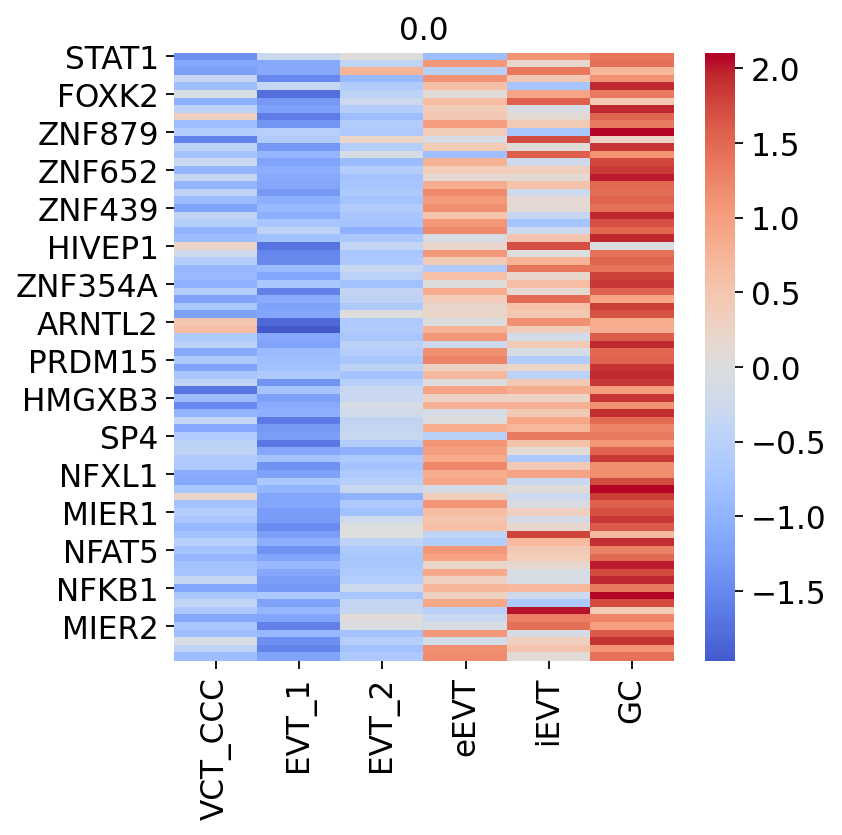

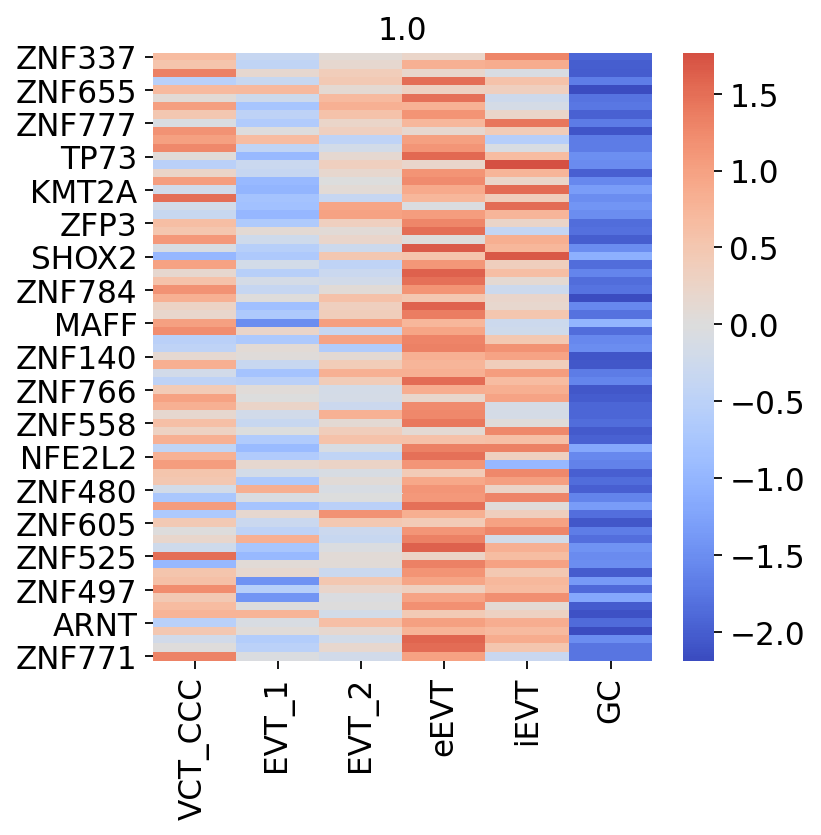

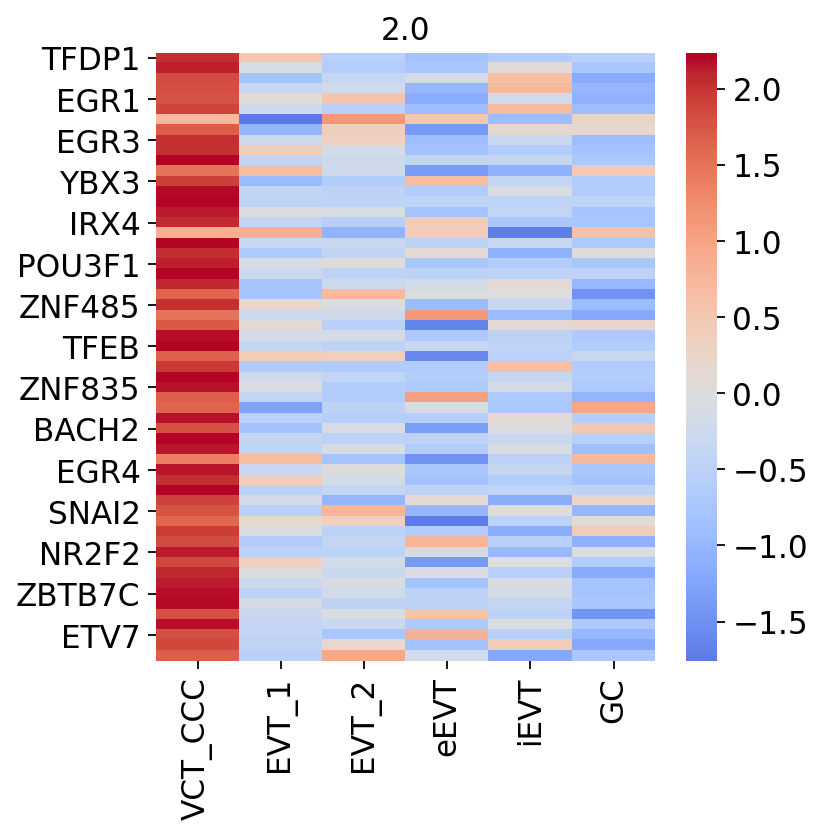

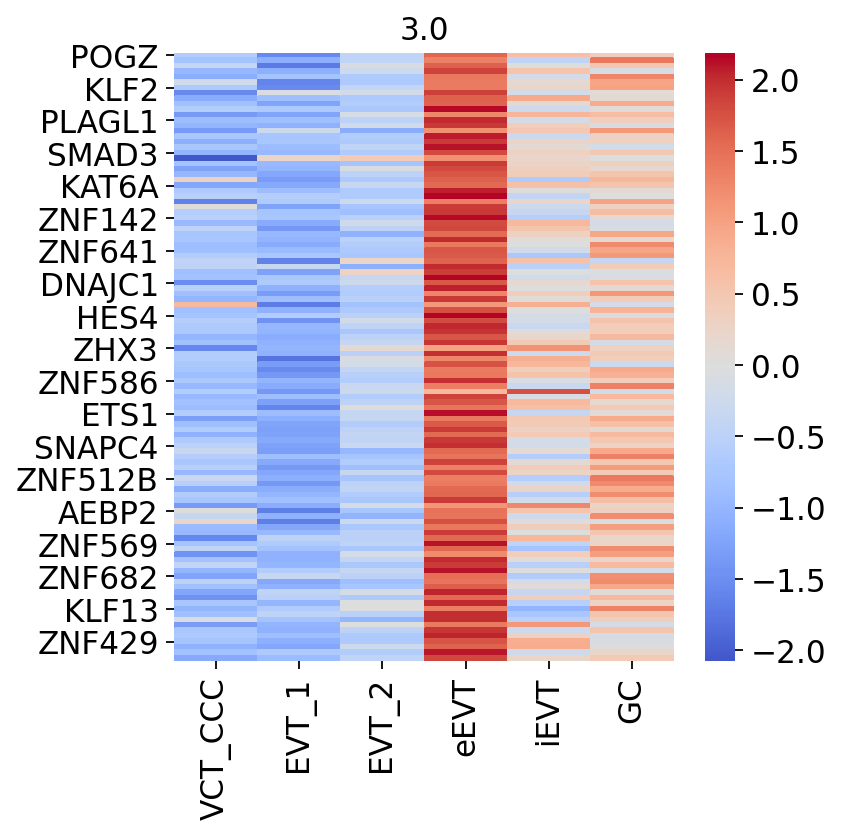

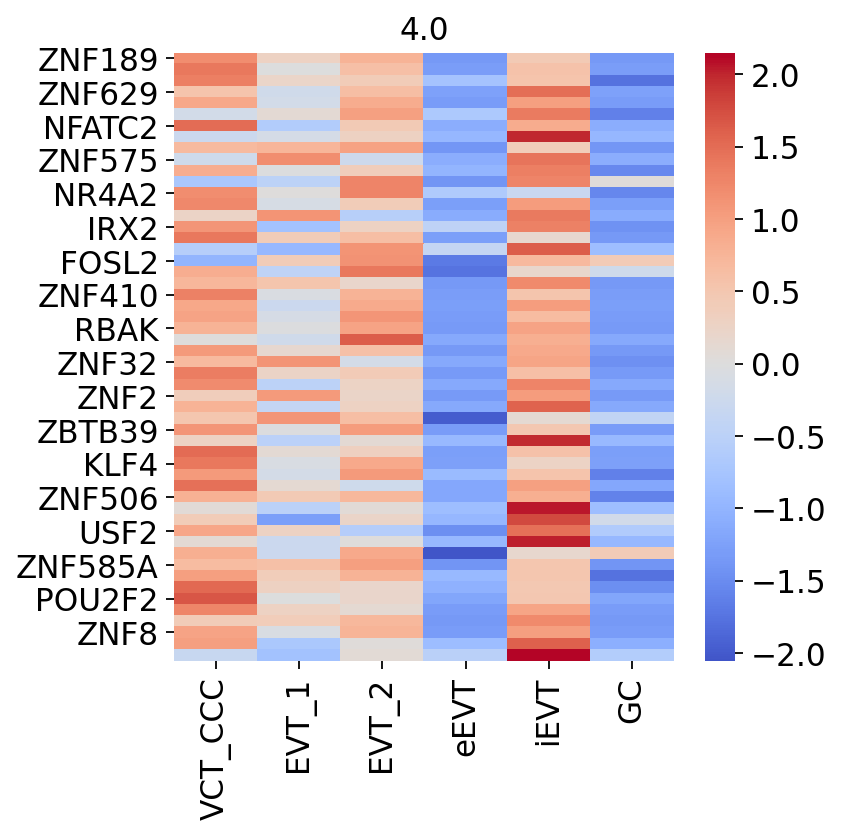

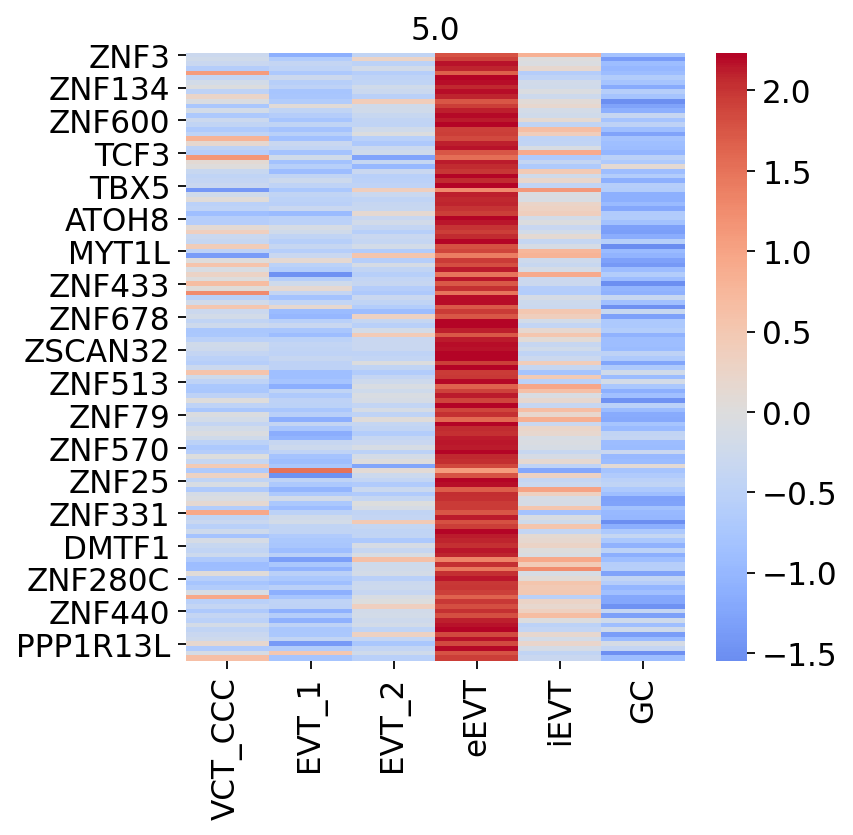

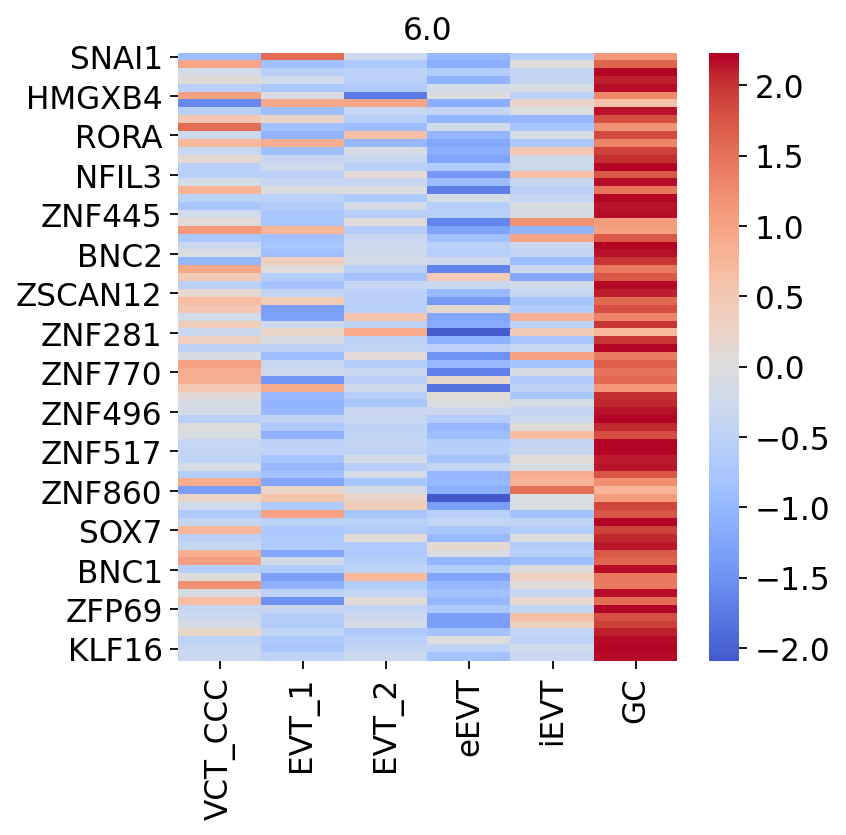

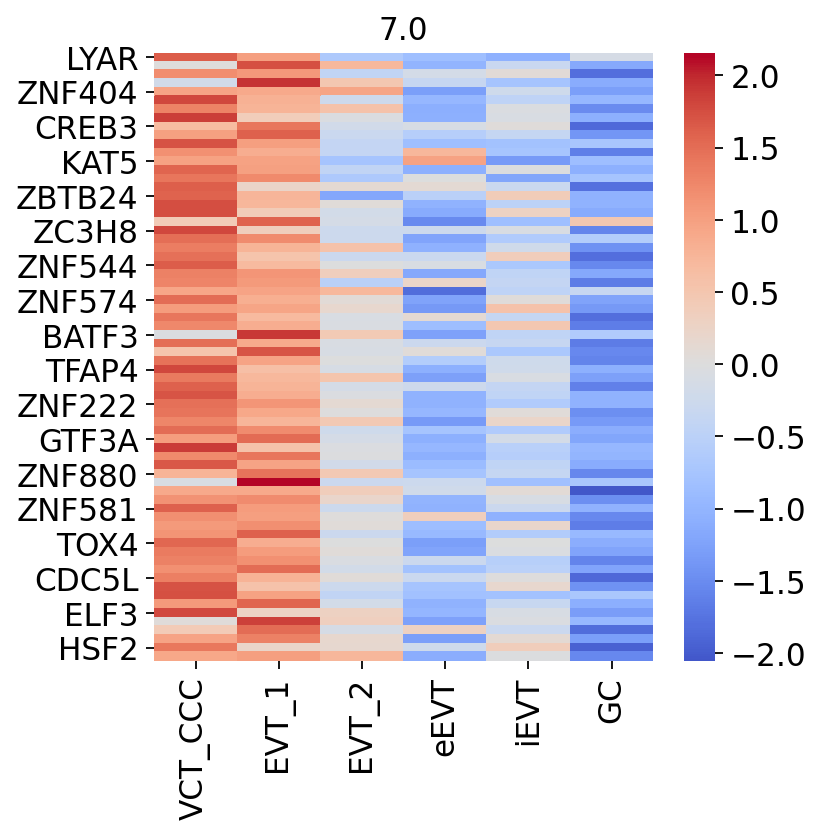

In [179]:
# with 8 clusters - looks better than with k=4
for cluster in np.unique(df['Cluster']):
    plt.figure(figsize=(5,5))
    plt.title(cluster)
    sns.heatmap(df[df['Cluster'] == cluster].loc[:,ct_in_order], 
                center=0, cmap='coolwarm')

In [180]:
# out of curiosity - doing the same for all L/Rs 

df_LR_fetus_simple = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_sc_sn_Integrated_analysis/new_scVI_analysis/CellPhone_analysis/20220211_LR_fetus_simple_df_avg_expr_for_pattern_selection.csv',
                         index_col=0)
df_LR_fetus_complex = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_sc_sn_Integrated_analysis/new_scVI_analysis/CellPhone_analysis/20220211_LR_fetus_complex_df_avg_expr_for_pattern_selection.csv',
                         index_col=0)


In [181]:
df_LR_fetus_simple

SEMA4A      DLL4      XCL1     TGFB3     WNT5B      VASN    PTGER3  \
VCT_CCC  0.007080  0.004031  0.013881  0.006319  0.016526  0.080618  0.009742   
EVT_1    0.003030  0.002353  0.009313  0.003636  0.013420  0.028642  0.044153   
EVT_2    0.004539  0.002590  0.014577  0.006157  0.026536  0.038029  0.097395   
eEVT     0.000000  0.000000  0.048809  0.050545  0.042114  0.105045  0.778033   
iEVT     0.007207  0.003908  0.012189  0.010906  0.022068  0.071830  0.356003   
GC       0.000000  0.000000  0.000000  0.000000  0.057874  0.063885  0.684442   

            NTRK2      POMC     EFNB1  ...     S1PR2    CLEC4M     DSCAM  \
VCT_CCC  0.005715  0.003865  0.127440  ...  0.181413  0.000944  0.041803   
EVT_1    0.002445  0.021216  0.301914  ...  0.046627  0.000989  0.022624   
EVT_2    0.005420  0.041358  0.371058  ...  0.051504  0.002293  0.036561   
eEVT     0.000000  0.063498  0.155254  ...  0.000000  0.000000  0.520678   
iEVT     0.006637  0.117697  0.540273  ...  0.082986  0.001923  0.053515   
GC       0.000000  0.092182  0.680914  ...  0.000000  0.000000  0.157037   

             FRZB     EFNA5     PTGES      FGF2      EPOR   KIR2DL3      NTN4  
VCT_CCC  0.028765  0.202185  0.737331  0.022429  0.027605  0.003598  0.035489  
EVT_1    0.017559  0.070949  0.810284  0.003671  0.077668  0.001796  0.059319  
EVT_2    0.039816  0.143571  0.581261  0.011031  0.128597  0.002286  0.170363  
eEVT     0.013063  0.175232  0.035521  0.000000  0.292352  0.000000  0.926812  
iEVT     0.036015  0.125094  0.837888  0.010810  0.259144  0.001312  0.620948  
GC       0.000000  0.434634  0.894891  0.000000  0.147391  0.000000  0.549769  

[6 rows x 331 columns]

In [182]:
df_LR_fetus_complex

ITGA5     RAMP2   COL27A1      WNT6      LRP5      NRP1     ITGB2  \
VCT_CCC  0.353980  0.010056  0.164259  0.090338  0.234399  0.617197  0.016418   
EVT_1    1.200004  0.010044  0.805337  0.003632  0.019873  0.083166  0.010619   
EVT_2    1.713490  0.009377  1.692027  0.003739  0.025958  0.145223  0.020412   
eEVT     1.302134  0.000000  1.448324  0.000000  0.049713  0.042119  0.000000   
iEVT     1.827544  0.011360  1.806485  0.004794  0.027692  0.140429  0.024790   
GC       2.188430  0.000000  1.209462  0.000000  0.071027  0.414164  0.063885   

           SEMA6D      FZD6      JAM2  ...    ITGA11      CD47   COL11A1  \
VCT_CCC  0.506556  0.139578  0.015504  ...  0.004212  0.543816  0.015790   
EVT_1    0.160409  0.049452  0.041256  ...  0.002384  0.329133  0.033307   
EVT_2    0.350891  0.066785  0.102457  ...  0.004547  0.235068  0.041160   
eEVT     2.774941  0.059044  0.000000  ...  0.000000  0.240616  0.000000   
iEVT     0.854799  0.089705  0.399135  ...  0.006221  0.263946  0.186866   
GC       1.456230  0.000000  0.437881  ...  0.000000  0.246838  0.099163   

          COL26A1   COL17A1   CYSLTR2      FZD7     WNT7A      IL7R    TYROBP  
VCT_CCC  0.008304  0.304794  0.011487  0.011485  0.280082  0.001183  0.070191  
EVT_1    0.014348  0.068460  0.038790  0.004891  0.458609  0.000695  0.049702  
EVT_2    0.050053  0.168078  0.053957  0.008979  0.287918  0.002673  0.050780  
eEVT     0.279212  0.000000  0.572736  0.000000  0.147024  0.000000  0.044125  
iEVT     0.073588  0.219918  0.018362  0.005036  0.140864  0.002569  0.066138  
GC       0.093011  0.077556  0.064122  0.000000  0.215745  0.000000  0.167125  

[6 rows x 114 columns]

In [183]:
# uniting the simple and complex expression tables
df_LR_fetus = pd.concat([df_LR_fetus_simple, df_LR_fetus_complex], axis=1, copy=False)
# making columns unique
#df_LR_fetus = df_LR_fetus.loc[:,list(set(df_LR_fetus.columns))]

In [184]:
df_LR_fetus.shape

(6, 445)

In [185]:
len(set(df_LR_fetus.columns))

414

In [186]:
df_LR_fetus

SEMA4A      DLL4      XCL1     TGFB3     WNT5B      VASN    PTGER3  \
VCT_CCC  0.007080  0.004031  0.013881  0.006319  0.016526  0.080618  0.009742   
EVT_1    0.003030  0.002353  0.009313  0.003636  0.013420  0.028642  0.044153   
EVT_2    0.004539  0.002590  0.014577  0.006157  0.026536  0.038029  0.097395   
eEVT     0.000000  0.000000  0.048809  0.050545  0.042114  0.105045  0.778033   
iEVT     0.007207  0.003908  0.012189  0.010906  0.022068  0.071830  0.356003   
GC       0.000000  0.000000  0.000000  0.000000  0.057874  0.063885  0.684442   

            NTRK2      POMC     EFNB1  ...    ITGA11      CD47   COL11A1  \
VCT_CCC  0.005715  0.003865  0.127440  ...  0.004212  0.543816  0.015790   
EVT_1    0.002445  0.021216  0.301914  ...  0.002384  0.329133  0.033307   
EVT_2    0.005420  0.041358  0.371058  ...  0.004547  0.235068  0.041160   
eEVT     0.000000  0.063498  0.155254  ...  0.000000  0.240616  0.000000   
iEVT     0.006637  0.117697  0.540273  ...  0.006221  0.263946  0.186866   
GC       0.000000  0.092182  0.680914  ...  0.000000  0.246838  0.099163   

          COL26A1   COL17A1   CYSLTR2      FZD7     WNT7A      IL7R    TYROBP  
VCT_CCC  0.008304  0.304794  0.011487  0.011485  0.280082  0.001183  0.070191  
EVT_1    0.014348  0.068460  0.038790  0.004891  0.458609  0.000695  0.049702  
EVT_2    0.050053  0.168078  0.053957  0.008979  0.287918  0.002673  0.050780  
eEVT     0.279212  0.000000  0.572736  0.000000  0.147024  0.000000  0.044125  
iEVT     0.073588  0.219918  0.018362  0.005036  0.140864  0.002569  0.066138  
GC       0.093011  0.077556  0.064122  0.000000  0.215745  0.000000  0.167125  

[6 rows x 445 columns]

In [187]:
df_LR_fetus = df_LR_fetus.loc[:,~df_LR_fetus.columns.duplicated()]

In [188]:
df_LR_fetus

SEMA4A      DLL4      XCL1     TGFB3     WNT5B      VASN    PTGER3  \
VCT_CCC  0.007080  0.004031  0.013881  0.006319  0.016526  0.080618  0.009742   
EVT_1    0.003030  0.002353  0.009313  0.003636  0.013420  0.028642  0.044153   
EVT_2    0.004539  0.002590  0.014577  0.006157  0.026536  0.038029  0.097395   
eEVT     0.000000  0.000000  0.048809  0.050545  0.042114  0.105045  0.778033   
iEVT     0.007207  0.003908  0.012189  0.010906  0.022068  0.071830  0.356003   
GC       0.000000  0.000000  0.000000  0.000000  0.057874  0.063885  0.684442   

            NTRK2      POMC     EFNB1  ...   ALOX5AP     GDF11       FN1  \
VCT_CCC  0.005715  0.003865  0.127440  ...  0.010962  0.029863  2.088778   
EVT_1    0.002445  0.021216  0.301914  ...  0.014247  0.028990  2.561947   
EVT_2    0.005420  0.041358  0.371058  ...  0.011408  0.032606  4.148648   
eEVT     0.000000  0.063498  0.155254  ...  0.000000  0.127533  2.528535   
iEVT     0.006637  0.117697  0.540273  ...  0.011496  0.024256  4.787817   
GC       0.000000  0.092182  0.680914  ...  0.036521  0.000000  5.390869   

           ITGA11   COL11A1   COL26A1   COL17A1   CYSLTR2      FZD7    TYROBP  
VCT_CCC  0.004212  0.015790  0.008304  0.304794  0.011487  0.011485  0.070191  
EVT_1    0.002384  0.033307  0.014348  0.068460  0.038790  0.004891  0.049702  
EVT_2    0.004547  0.041160  0.050053  0.168078  0.053957  0.008979  0.050780  
eEVT     0.000000  0.000000  0.279212  0.000000  0.572736  0.000000  0.044125  
iEVT     0.006221  0.186866  0.073588  0.219918  0.018362  0.005036  0.066138  
GC       0.000000  0.099163  0.093011  0.077556  0.064122  0.000000  0.167125  

[6 rows x 414 columns]

In [189]:
# assign z-scores

for gene in df_LR_fetus.columns:
    df_LR_fetus.loc[:,gene] = scipy.stats.zscore(df_LR_fetus.loc[:, gene])


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [190]:
df_LR_fetus

SEMA4A      DLL4      XCL1     TGFB3     WNT5B      VASN    PTGER3  \
VCT_CCC  1.165016  1.149927 -0.169101 -0.385592 -0.849703  0.621838 -1.037717   
EVT_1   -0.207710  0.125704 -0.468486 -0.542178 -1.049138 -1.405389 -0.925619   
EVT_2    0.303852  0.270147 -0.123487 -0.395036 -0.206797 -1.039281 -0.752179   
eEVT    -1.234541 -1.310287  2.119979  2.195083  0.793643  1.574569  1.465067   
iEVT     1.207925  1.074795 -0.280046 -0.117953 -0.493789  0.279070  0.090263   
GC      -1.234541 -1.310287 -1.078860 -0.754324  1.805783 -0.030806  1.160185   

            NTRK2      POMC     EFNB1  ...   ALOX5AP     GDF11       FN1  \
VCT_CCC  0.866592 -1.339531 -1.189454  ... -0.285873 -0.264393 -1.193215   
EVT_1   -0.341518 -0.899104 -0.307738  ...  0.012819 -0.286009 -0.815726   
EVT_2    0.757604 -0.387822  0.041689  ... -0.245370 -0.196488  0.450125   
eEVT    -1.245076  0.174197 -1.048894  ... -1.282866  2.153937 -0.842382   
iEVT     1.207473  1.549958  0.896826  ... -0.237301 -0.403229  0.960046   
GC      -1.245076  0.902302  1.607570  ...  2.038590 -1.003818  1.441153   

           ITGA11   COL11A1   COL26A1   COL17A1   CYSLTR2      FZD7    TYROBP  
VCT_CCC  0.565803 -0.738773 -0.855745  1.610814 -0.574376  1.514009 -0.105883  
EVT_1   -0.219041 -0.462980 -0.789537 -0.696496 -0.438113 -0.041057 -0.589532  
EVT_2    0.709849 -0.339341 -0.398389  0.276067 -0.362416  0.923098 -0.564101  
eEVT    -1.242509 -0.987362  2.112024 -1.364866  2.226654 -1.194558 -0.721186  
iEVT     1.428407  1.954621 -0.140568  0.782179 -0.540062 -0.006934 -0.201566  
GC      -1.242509  0.573835  0.072216 -0.607697 -0.311686 -1.194558  2.182268  

[6 rows x 414 columns]

In [191]:
df_LR_fetus_copy = df_LR_fetus.T.copy()

kmeans = KMeans(n_clusters=8)

y = kmeans.fit_predict(df_LR_fetus_copy)

df_LR_fetus_copy['Cluster'] = y

print(df_LR_fetus_copy.head())

         VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC  Cluster
SEMA4A  1.165016 -0.207710  0.303852 -1.234541  1.207925 -1.234541        0
DLL4    1.149927  0.125704  0.270147 -1.310287  1.074795 -1.310287        0
XCL1   -0.169101 -0.468486 -0.123487  2.119979 -0.280046 -1.078860        3
TGFB3  -0.385592 -0.542178 -0.395036  2.195083 -0.117953 -0.754324        3
WNT5B  -0.849703 -1.049138 -0.206797  0.793643 -0.493789  1.805783        6


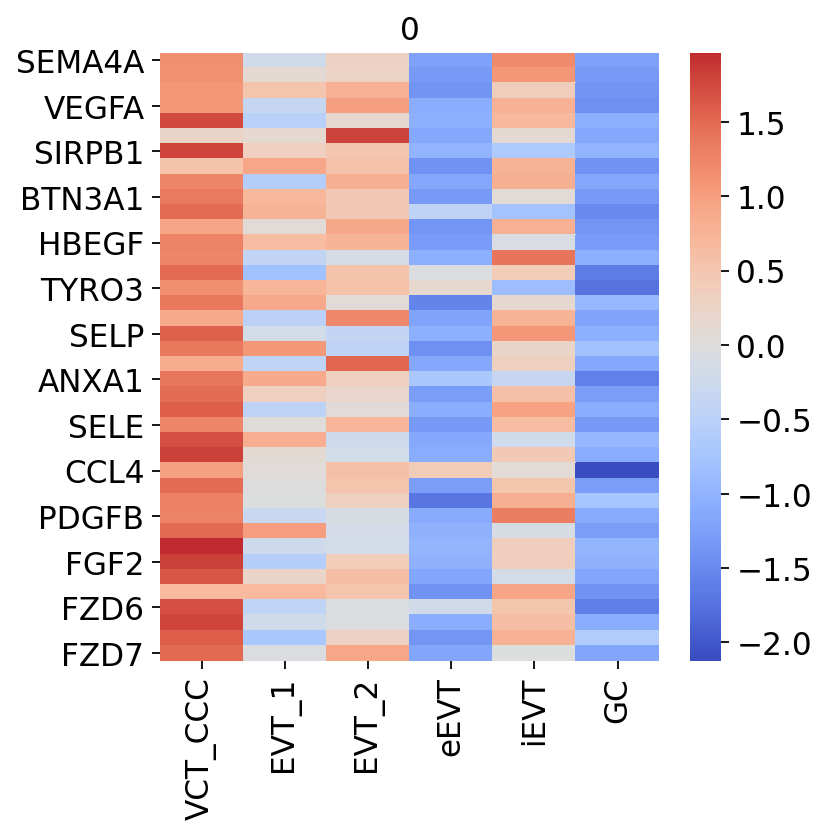

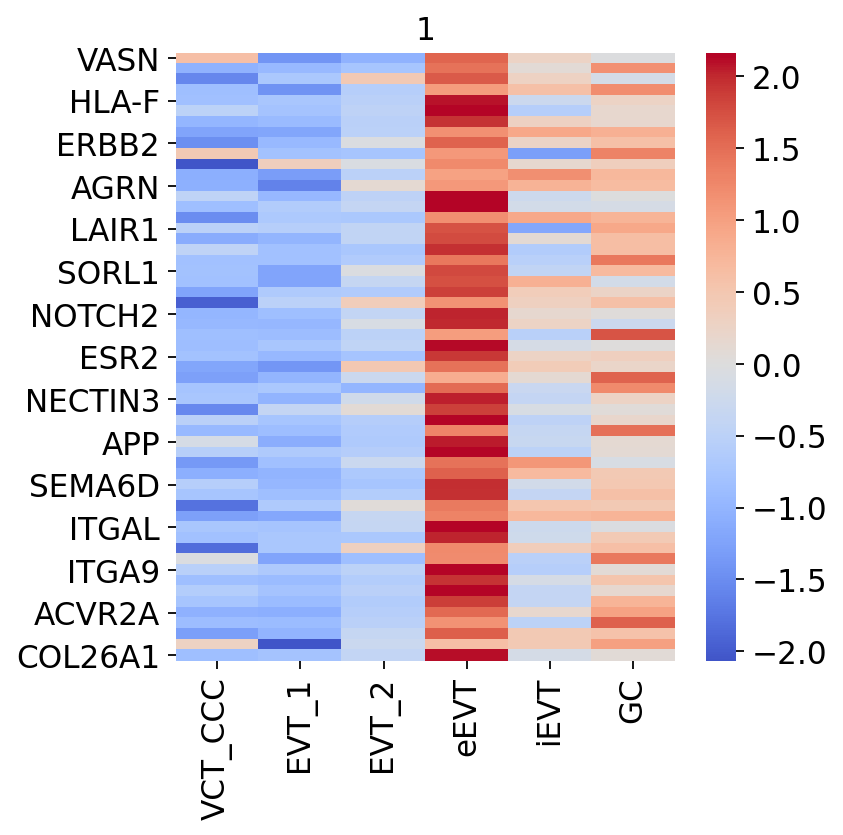

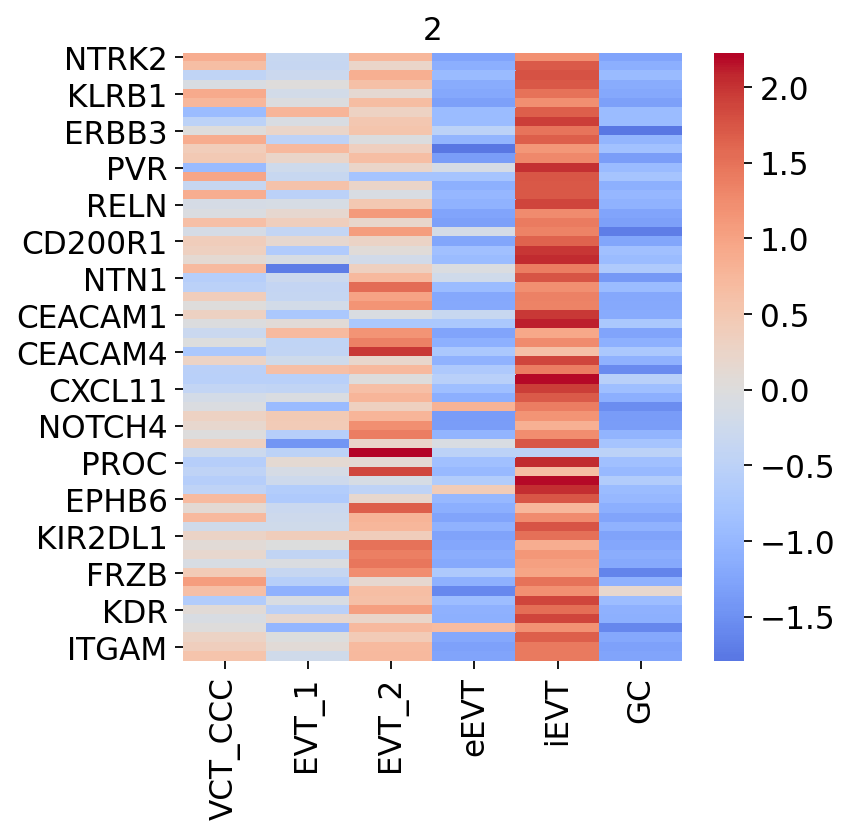

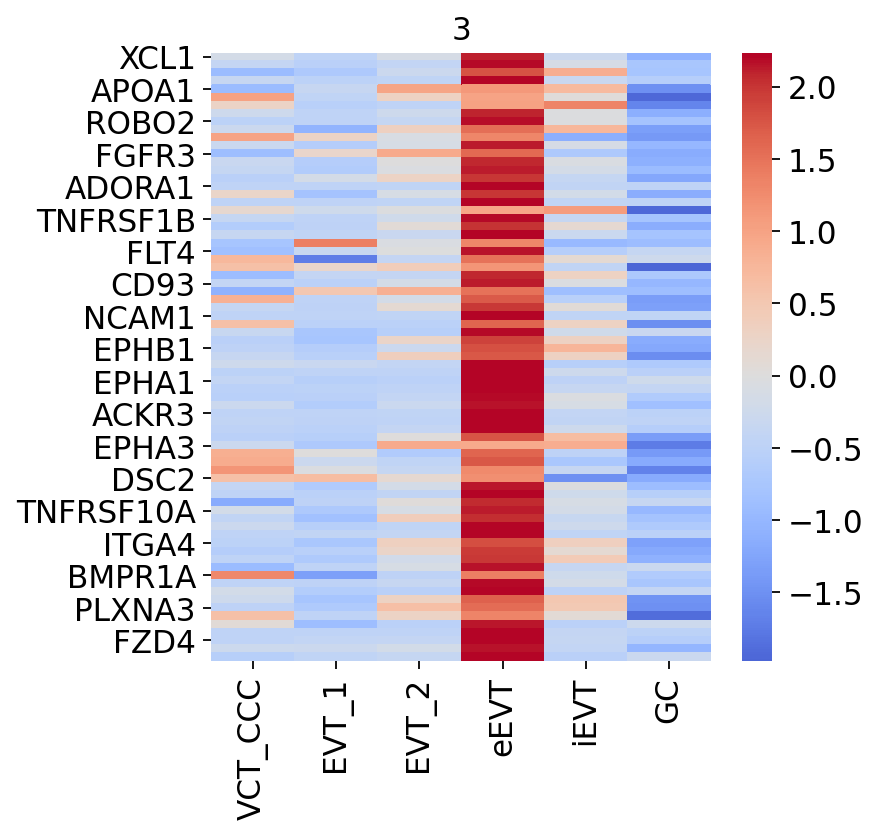

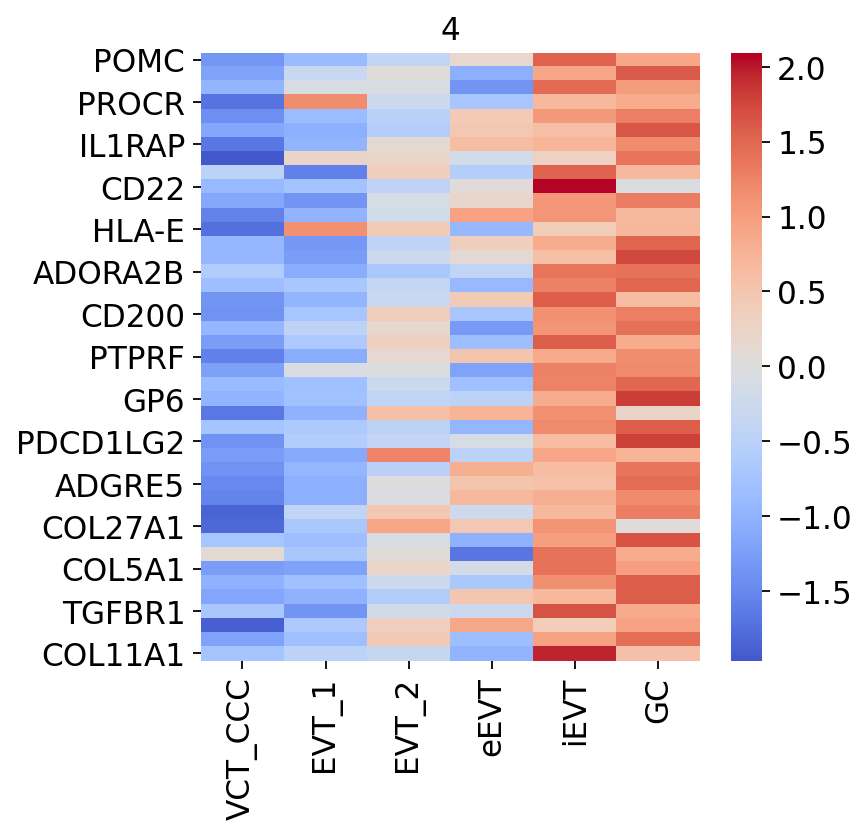

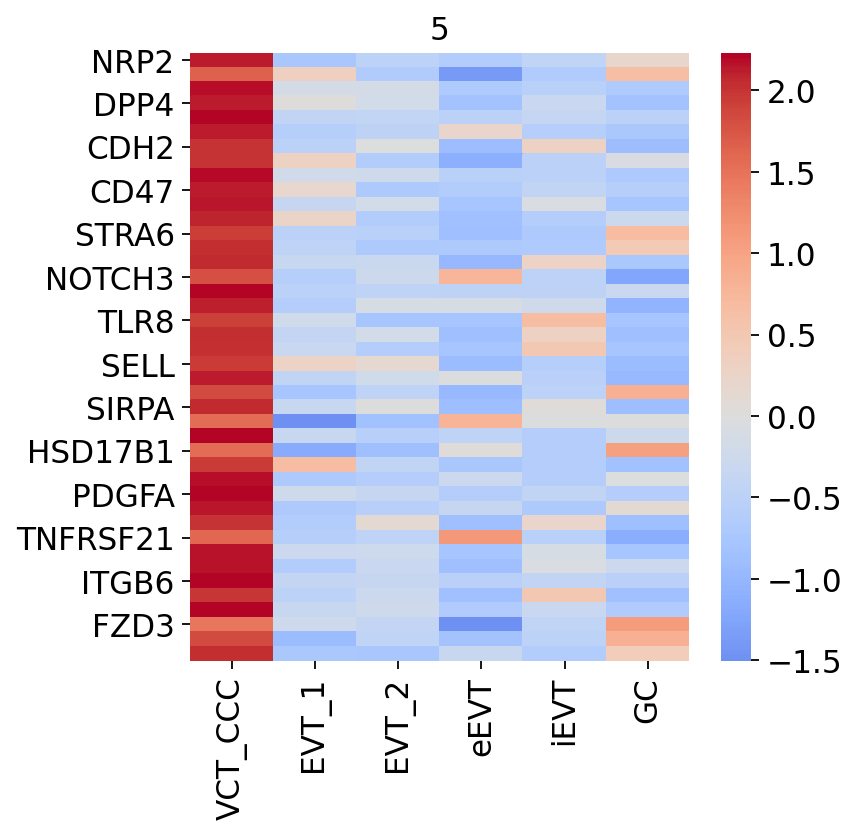

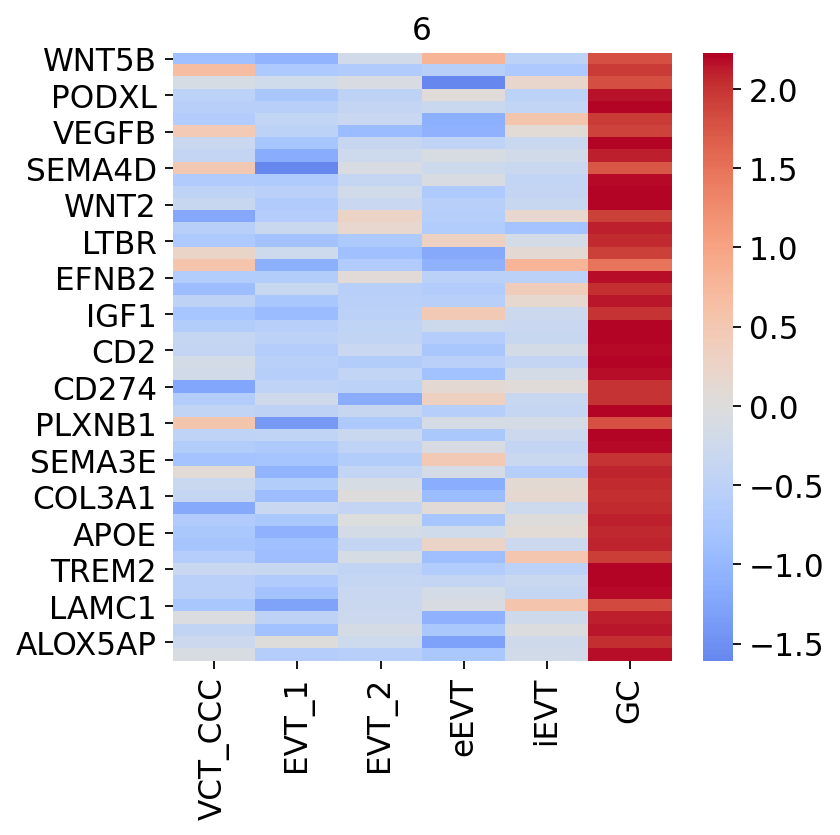

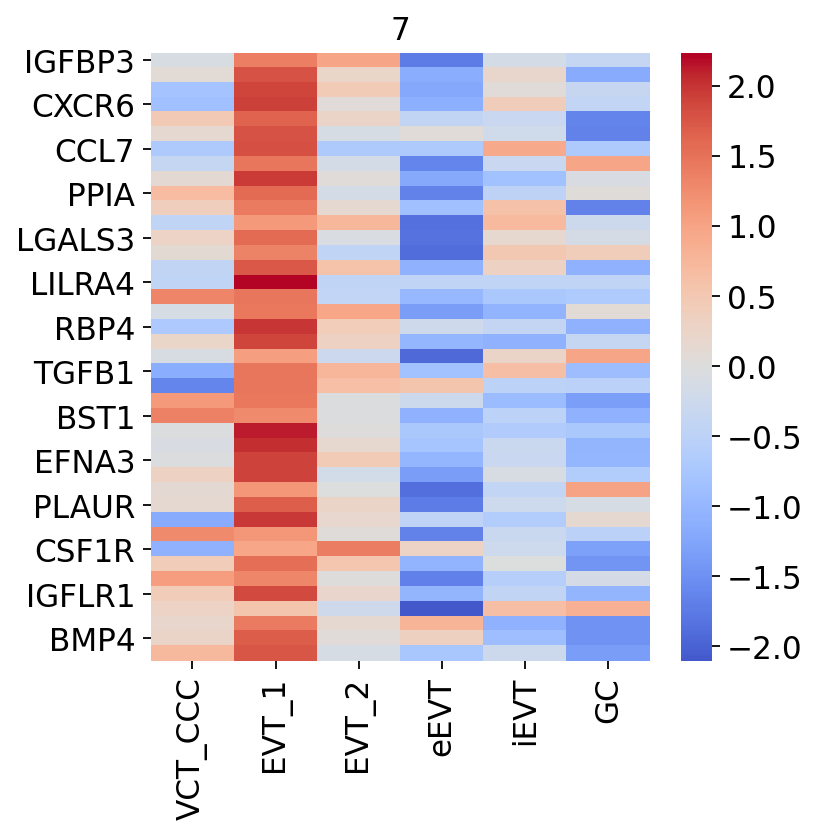

In [192]:
# with 8 clusters - looks better than with k=4
for cluster in np.unique(df_LR_fetus_copy['Cluster']):
    plt.figure(figsize=(5,5))
    plt.title(cluster)
    sns.heatmap(df_LR_fetus_copy[df_LR_fetus_copy['Cluster'] == cluster].loc[:,ct_in_order], 
                center=0, cmap='coolwarm')

In [193]:
# TF patterns and LR patterns look fairly similar - let's try and cluster them altogether!

df_LR_fetus = df_LR_fetus.T # L/Rs

In [194]:
df_LR_fetus

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC
SEMA4A   1.165016 -0.207710  0.303852 -1.234541  1.207925 -1.234541
DLL4     1.149927  0.125704  0.270147 -1.310287  1.074795 -1.310287
XCL1    -0.169101 -0.468486 -0.123487  2.119979 -0.280046 -1.078860
TGFB3   -0.385592 -0.542178 -0.395036  2.195083 -0.117953 -0.754324
WNT5B   -0.849703 -1.049138 -0.206797  0.793643 -0.493789  1.805783
...           ...       ...       ...       ...       ...       ...
COL26A1 -0.855745 -0.789537 -0.398389  2.112024 -0.140568  0.072216
COL17A1  1.610814 -0.696496  0.276067 -1.364866  0.782179 -0.607697
CYSLTR2 -0.574376 -0.438113 -0.362416  2.226654 -0.540062 -0.311686
FZD7     1.514009 -0.041057  0.923098 -1.194558 -0.006934 -1.194558
TYROBP  -0.105883 -0.589532 -0.564101 -0.721186 -0.201566  2.182268

[414 rows x 6 columns]

In [195]:
df_avg_expr_zscores = df_avg_expr_zscores[ct_in_order] # TFs
df_avg_expr_zscores

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC
LYAR    1.643430  1.021151 -0.657155 -0.836322 -1.054252 -0.116851
POGZ   -0.593459 -1.558127 -0.429963  1.582767  0.624377  0.374405
SNAI1  -0.904895  1.574587 -0.246314 -0.987457 -0.586006  1.150085
FLI1   -0.806357 -1.088273 -0.426650  1.335824 -0.432862  1.418318
ARID1A -0.359524 -1.711462 -0.076096  1.638621  0.007749  0.500712
...          ...       ...       ...       ...       ...       ...
ZNF771  1.317249 -0.051083 -0.207716  1.010766 -0.307758 -1.761459
PSPC1  -1.159083 -0.919882 -0.430680  1.837743  0.231464  0.440438
CNOT4  -0.880752 -1.175233 -0.635385  1.190311  0.081216  1.419842
ZNF226  0.915251  1.020987  0.732247 -1.099553 -0.028183 -1.540748
JDP2    1.682442 -0.530254  0.947180 -0.180855 -1.202170 -0.716343

[655 rows x 6 columns]

In [196]:
TFs_and_LR = pd.concat([df_LR_fetus, df_avg_expr_zscores], axis=0)

In [197]:
TFs_and_LR

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC
SEMA4A  1.165016 -0.207710  0.303852 -1.234541  1.207925 -1.234541
DLL4    1.149927  0.125704  0.270147 -1.310287  1.074795 -1.310287
XCL1   -0.169101 -0.468486 -0.123487  2.119979 -0.280046 -1.078860
TGFB3  -0.385592 -0.542178 -0.395036  2.195083 -0.117953 -0.754324
WNT5B  -0.849703 -1.049138 -0.206797  0.793643 -0.493789  1.805783
...          ...       ...       ...       ...       ...       ...
ZNF771  1.317249 -0.051083 -0.207716  1.010766 -0.307758 -1.761459
PSPC1  -1.159083 -0.919882 -0.430680  1.837743  0.231464  0.440438
CNOT4  -0.880752 -1.175233 -0.635385  1.190311  0.081216  1.419842
ZNF226  0.915251  1.020987  0.732247 -1.099553 -0.028183 -1.540748
JDP2    1.682442 -0.530254  0.947180 -0.180855 -1.202170 -0.716343

[1069 rows x 6 columns]

In [198]:
len(set(TFs_and_LR.index))

1068

In [199]:
df_all2cluster = TFs_and_LR.copy()

kmeans = KMeans(n_clusters=8)

y = kmeans.fit_predict(df_all2cluster)

df_all2cluster['Cluster'] = y

print(df_all2cluster.head())

         VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC  Cluster
SEMA4A  1.165016 -0.207710  0.303852 -1.234541  1.207925 -1.234541        3
DLL4    1.149927  0.125704  0.270147 -1.310287  1.074795 -1.310287        3
XCL1   -0.169101 -0.468486 -0.123487  2.119979 -0.280046 -1.078860        1
TGFB3  -0.385592 -0.542178 -0.395036  2.195083 -0.117953 -0.754324        1
WNT5B  -0.849703 -1.049138 -0.206797  0.793643 -0.493789  1.805783        6


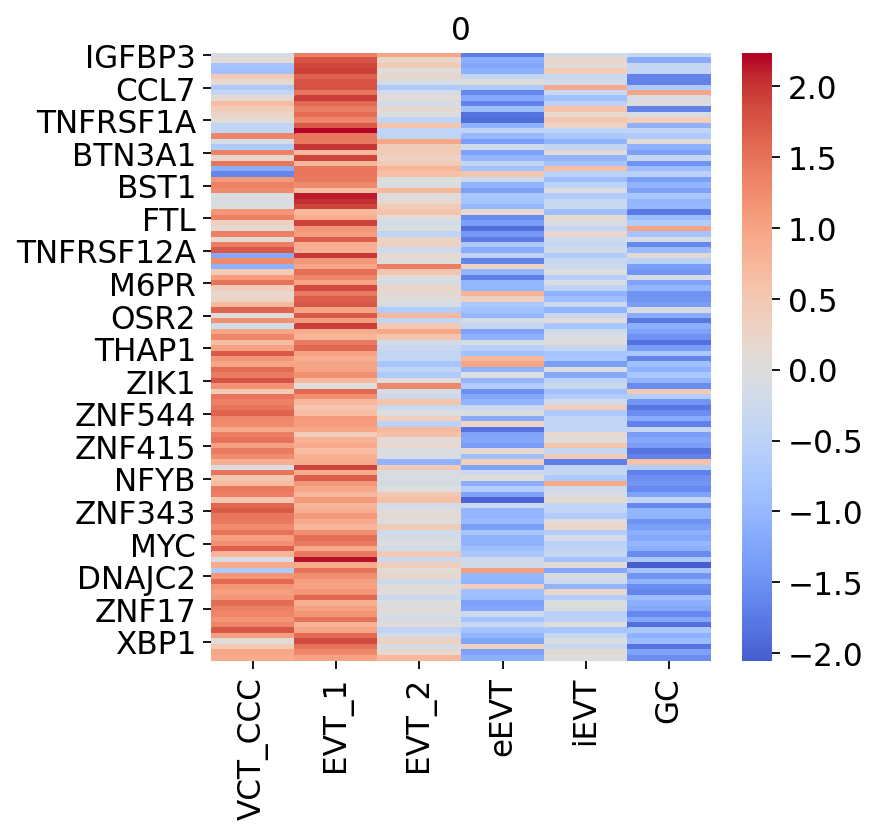

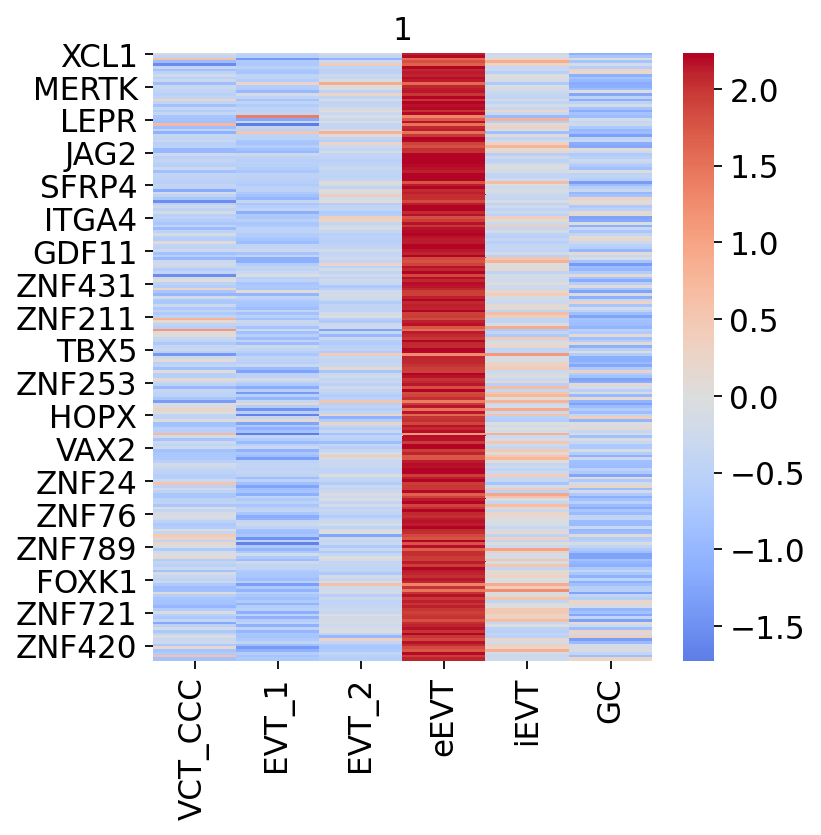

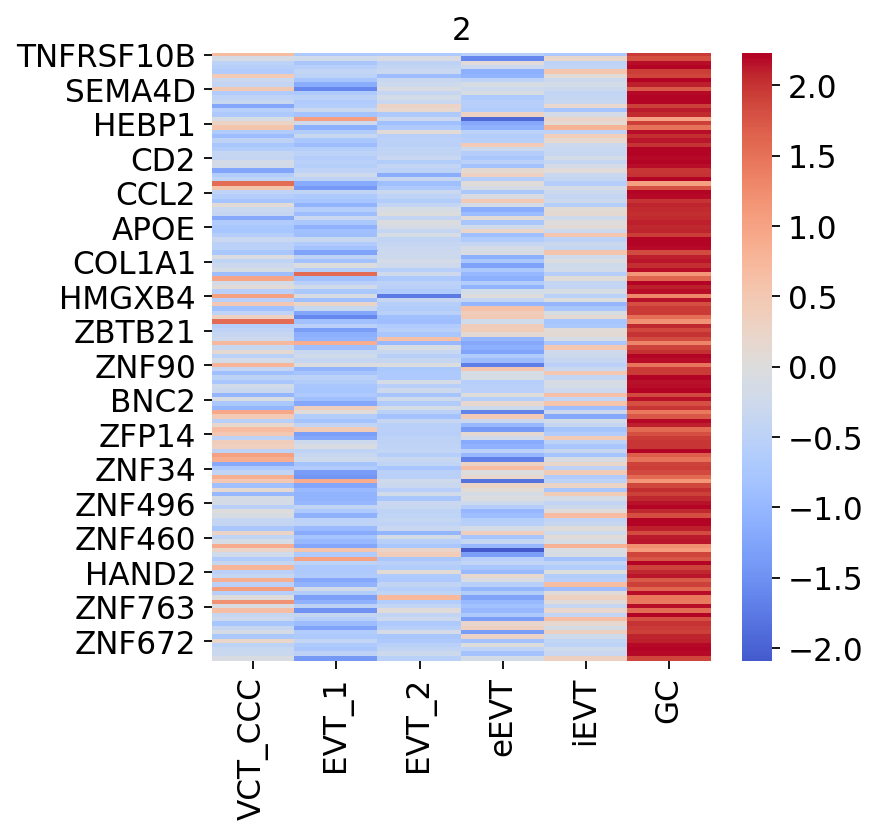

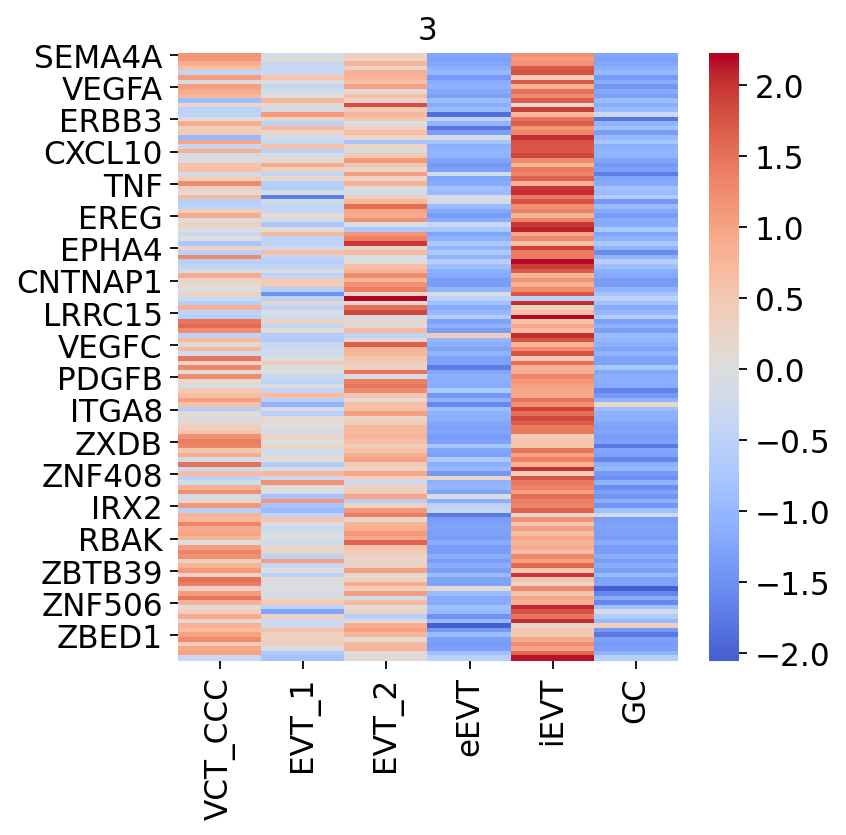

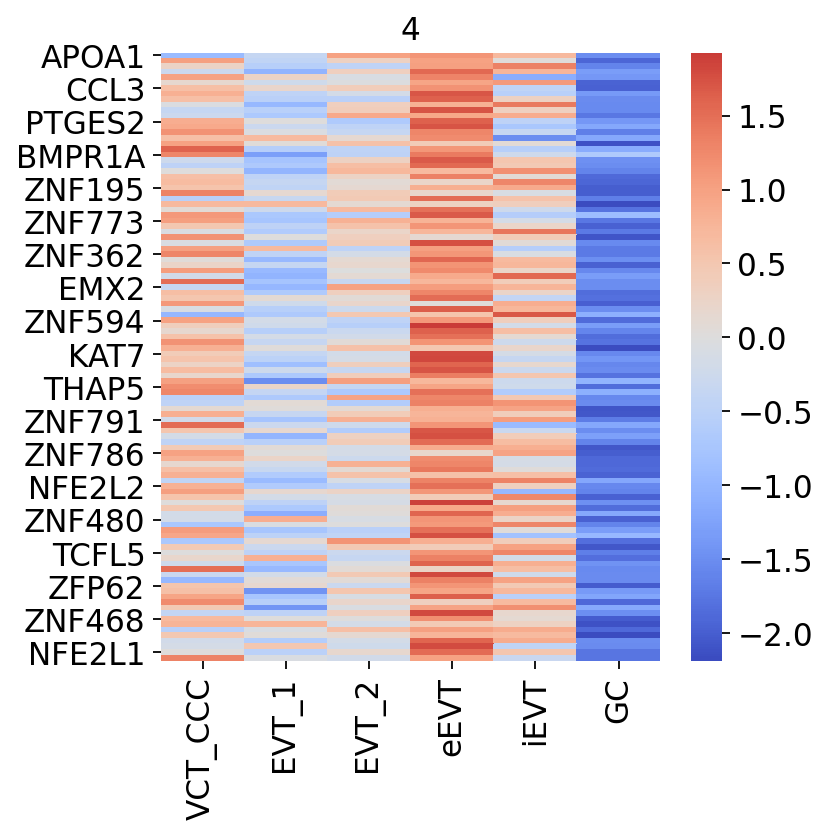

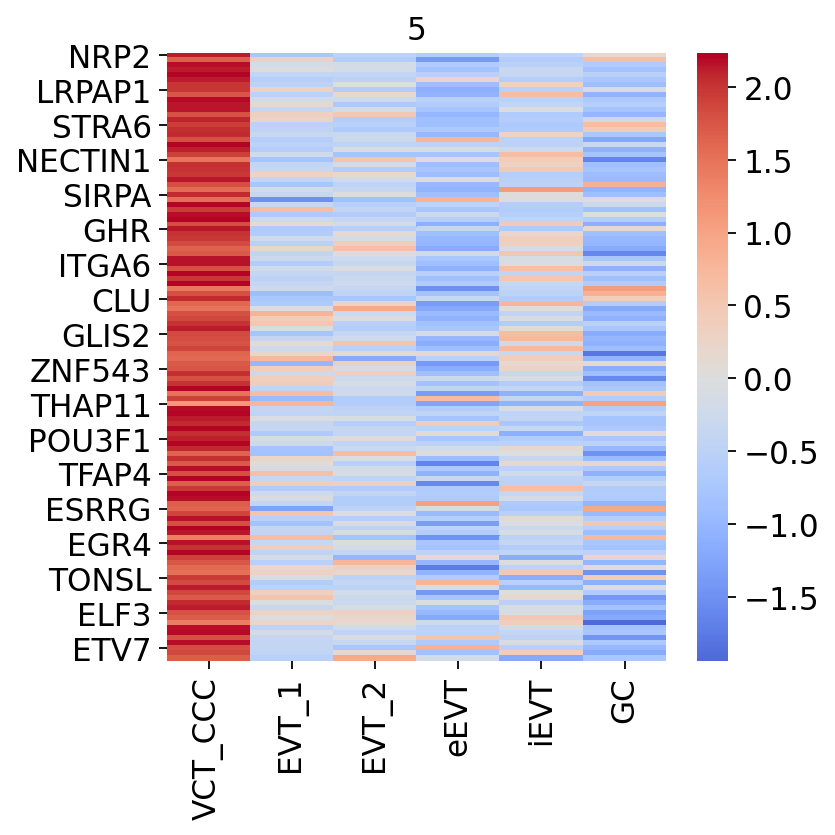

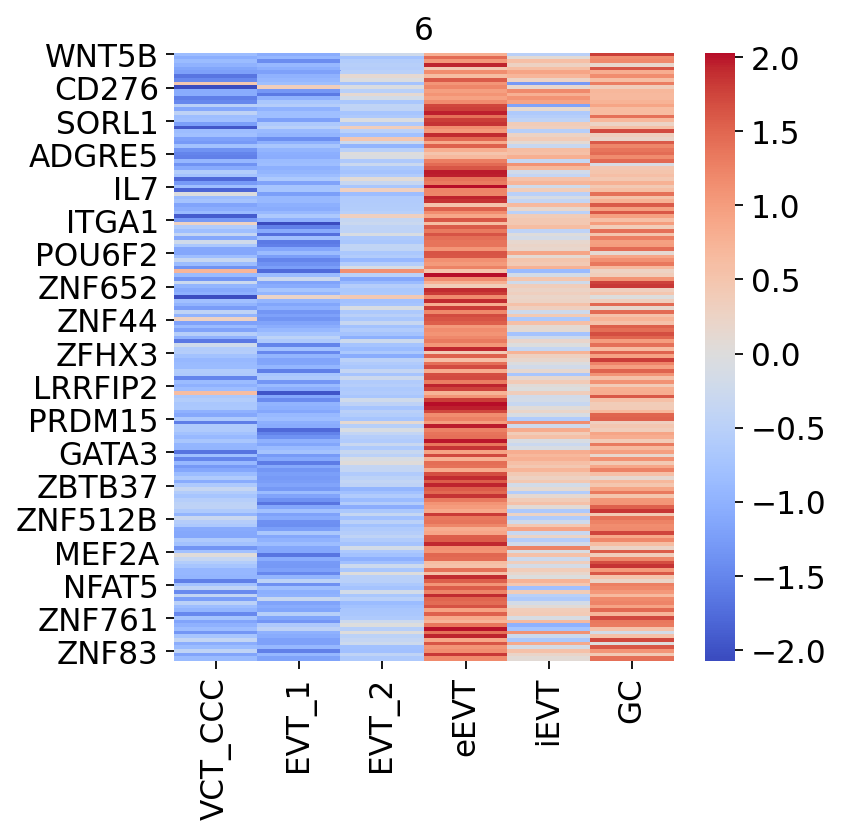

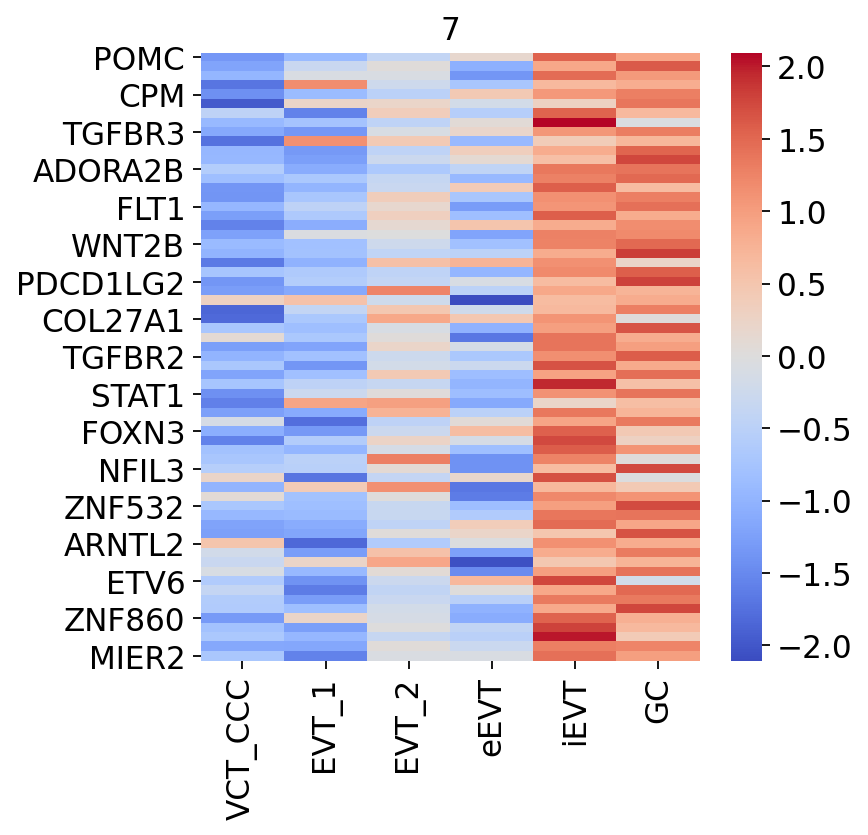

In [200]:
# with 8 clusters - looks better than with k=4
for cluster in np.unique(df_all2cluster['Cluster']):
    plt.figure(figsize=(5,5))
    plt.title(cluster)
    sns.heatmap(df_all2cluster[df_all2cluster['Cluster'] == cluster].loc[:,ct_in_order], 
                center=0, cmap='coolwarm')

In [201]:
# save for late
df_all2cluster.to_csv('./20220213_df_all_relevant_TFs_and_LRs_clusters.csv')

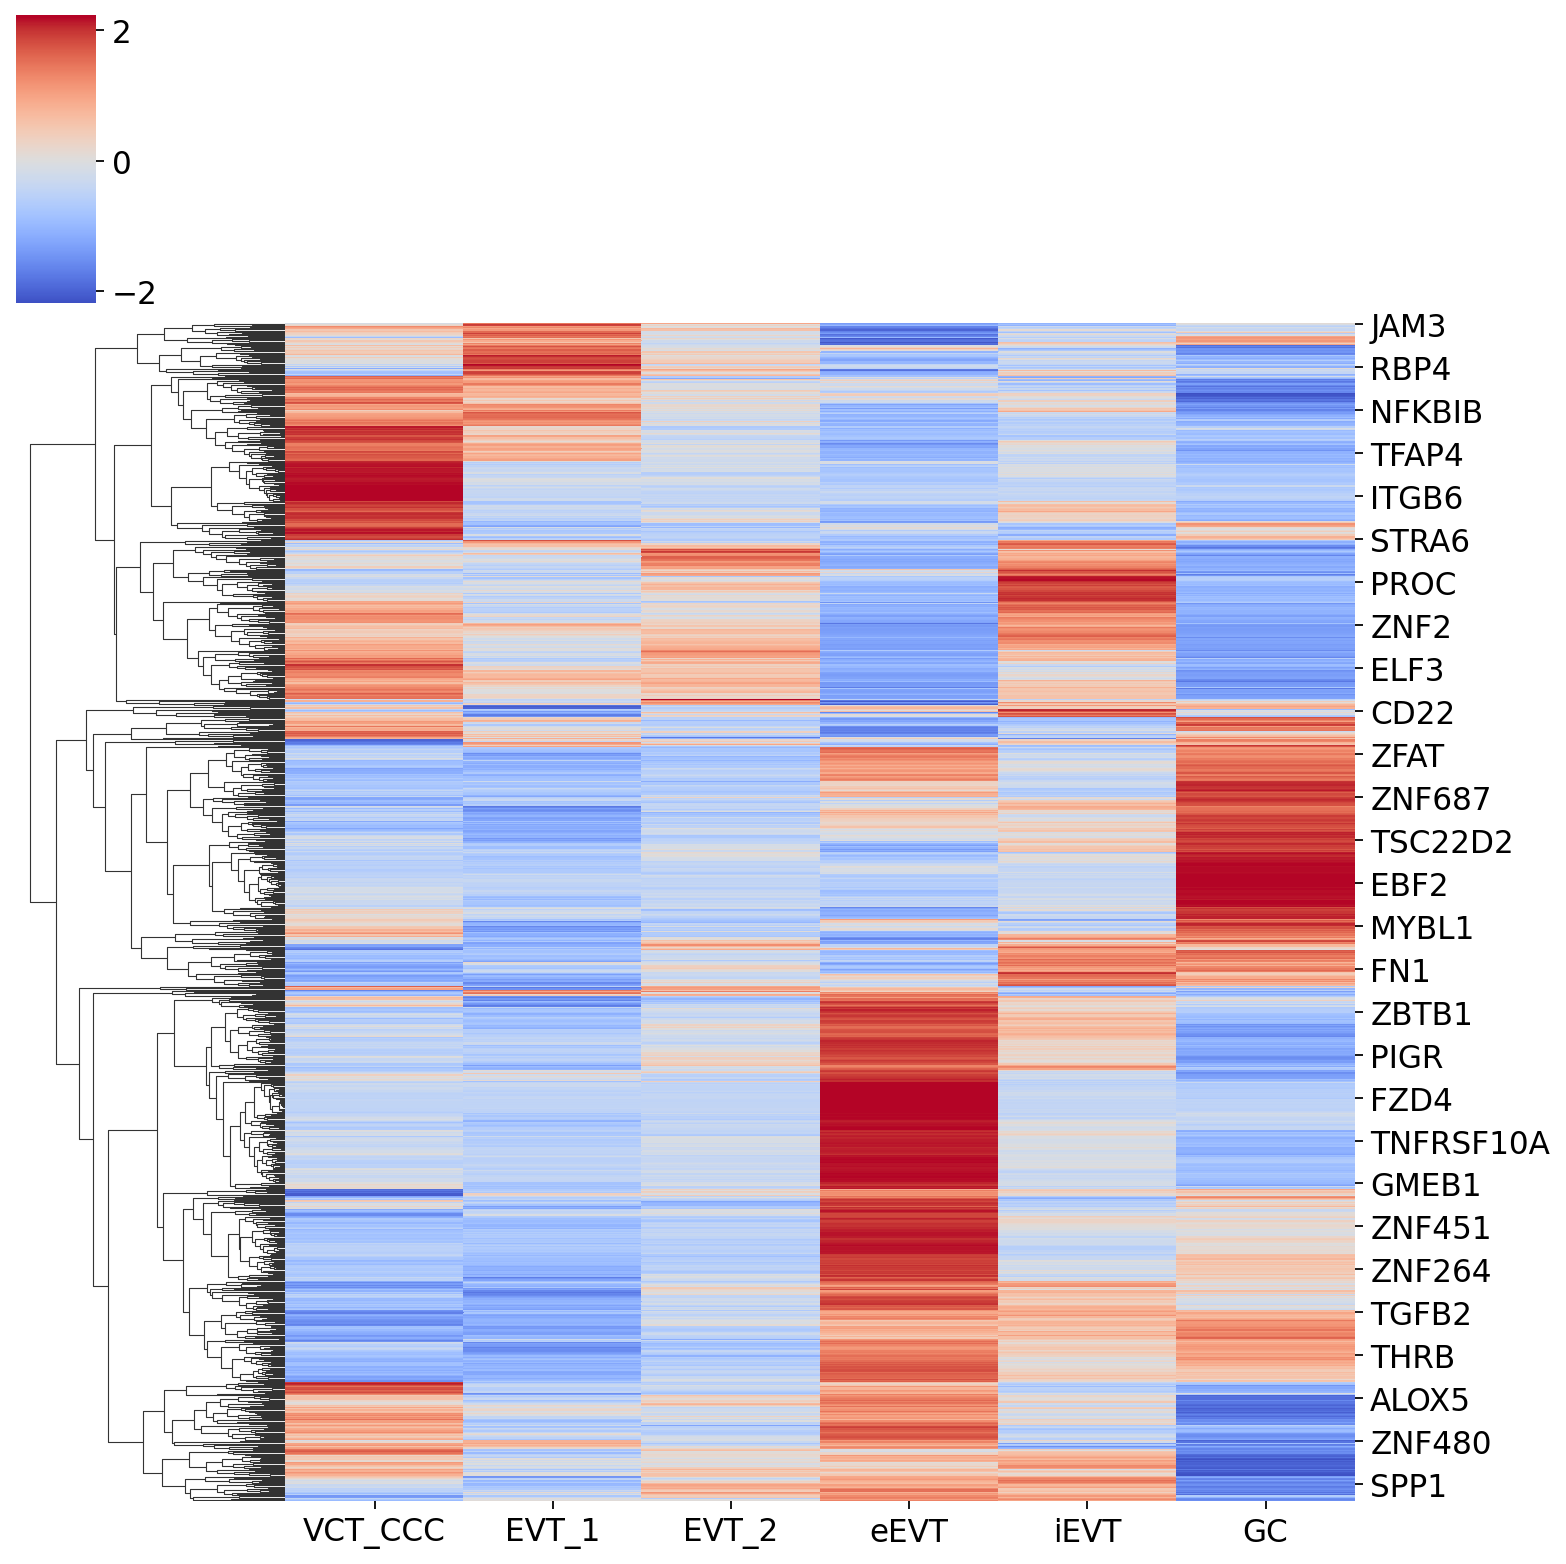

In [202]:
sns.clustermap(TFs_and_LR, center=0, cmap='coolwarm', 
               col_cluster=False
              )

In [81]:
#df.to_csv('./intermediate_files/20220208_df_zscore_of_avg_normlog_expr_TFs_union_with_MEFISTO_ALL_and_clustering.csv')

# continue with the best clustering of TFs and produce heatmaps per ME

In [93]:
df_avg_expr_zscores

EVT_1     EVT_2        GC       VCT   VCT_CCC      eEVT      iEVT
E2F5    -0.526632 -0.410583 -0.782040  2.142370  0.761160 -0.782040 -0.402234
ZXDB    -0.272019  0.243674 -1.323751  1.592216  0.888019 -1.323751  0.195613
NFXL1   -1.015127 -0.414884  1.320214 -1.085640 -0.864936  0.979565  1.080809
ZKSCAN8 -1.527410 -0.693535  1.350161  0.463886 -0.990917  1.006350  0.391464
ZNF773  -0.889534  0.388802 -1.683333  1.616519  0.566470  0.381281 -0.380205
...           ...       ...       ...       ...       ...       ...       ...
NR1H2    0.597191 -0.330718 -2.263949  0.970240  0.606525  0.283794  0.136916
RFX2    -0.896329  0.913594  0.888695 -1.091903 -1.022553 -0.291314  1.499810
ZNF600  -0.758617 -0.383290 -0.780073 -0.373657 -0.235305  2.331129  0.199813
GLI4    -0.638761 -0.176344 -1.609064 -0.066172 -0.204180  1.731650  0.962871
ZSCAN4  -0.585929  0.032472 -0.970061  0.304421  0.025767 -0.970061  2.163391

[655 rows x 7 columns]

In [94]:
df_TF_clusters = pd.read_csv('./20220213_df_all_relevant_TFs_and_LRs_clusters.csv',
                            index_col=0)

In [95]:
len(df_TF_clusters.index)

1069

In [96]:
len(set(df_TF_clusters.index))

1068

In [97]:
# ESR2 is duplicated = need to drop one of the rows
df_TF_clusters.loc['ESR2']

VCT_CCC    EVT_1    EVT_2      eEVT     iEVT       GC  Cluster
ESR2 -0.797078 -0.95139 -0.77419  1.916777  0.26706  0.33882        6
ESR2 -0.797078 -0.95139 -0.77419  1.916777  0.26706  0.33882        6

In [98]:
df_TF_clusters['gene'] = df_TF_clusters.index

In [99]:
df_TF_clusters = df_TF_clusters.drop_duplicates(subset = 'gene')
df_TF_clusters = df_TF_clusters.drop('gene',axis=1)
df_TF_clusters

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC  Cluster
SEMA4A  1.165016 -0.207710  0.303852 -1.234541  1.207925 -1.234541        3
DLL4    1.149927  0.125704  0.270147 -1.310287  1.074795 -1.310287        3
XCL1   -0.169101 -0.468486 -0.123487  2.119979 -0.280046 -1.078860        1
TGFB3  -0.385592 -0.542178 -0.395036  2.195083 -0.117953 -0.754324        1
WNT5B  -0.849703 -1.049138 -0.206797  0.793643 -0.493789  1.805783        6
...          ...       ...       ...       ...       ...       ...      ...
ZNF771  1.317249 -0.051083 -0.207716  1.010766 -0.307758 -1.761459        4
PSPC1  -1.159083 -0.919882 -0.430680  1.837743  0.231464  0.440438        6
CNOT4  -0.880752 -1.175233 -0.635385  1.190311  0.081216  1.419842        6
ZNF226  0.915251  1.020987  0.732247 -1.099553 -0.028183 -1.540748        0
JDP2    1.682442 -0.530254  0.947180 -0.180855 -1.202170 -0.716343        5

[1068 rows x 7 columns]

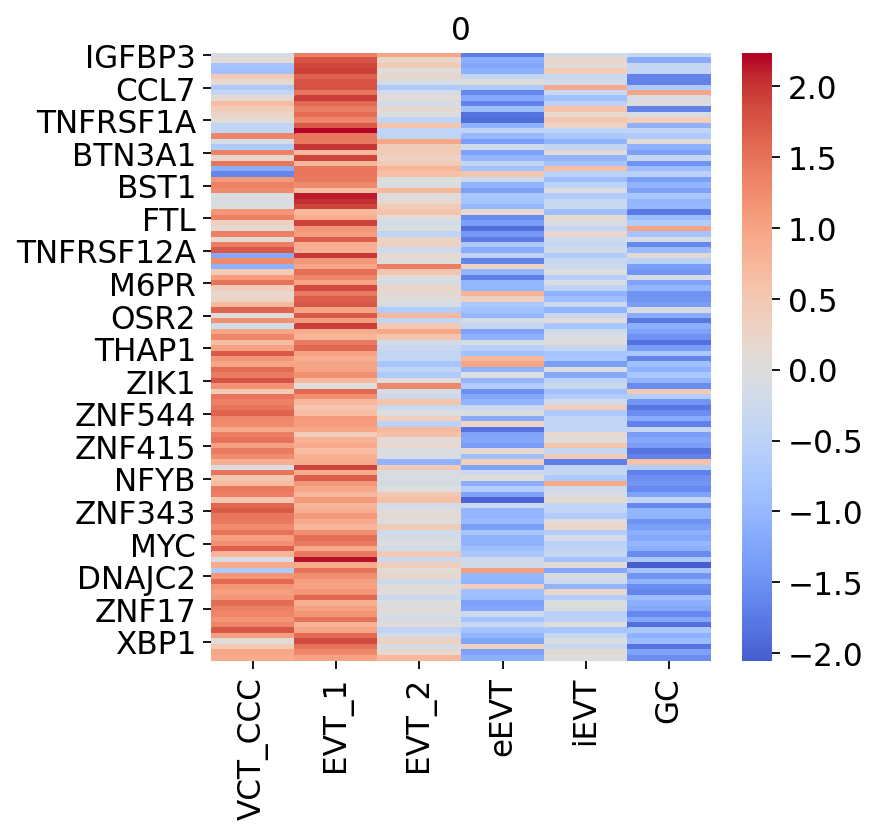

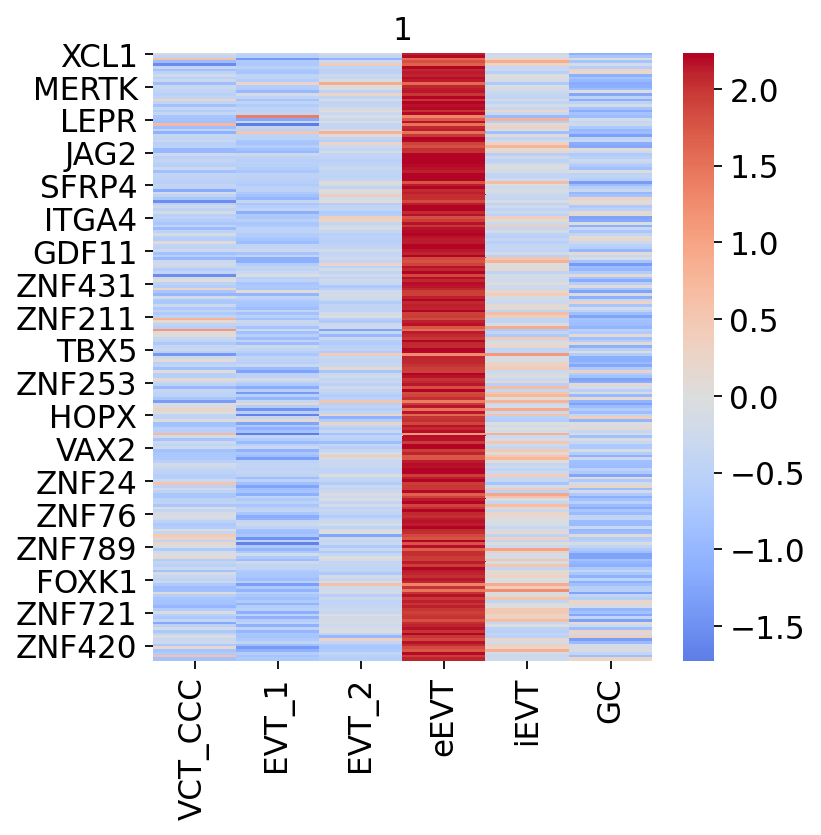

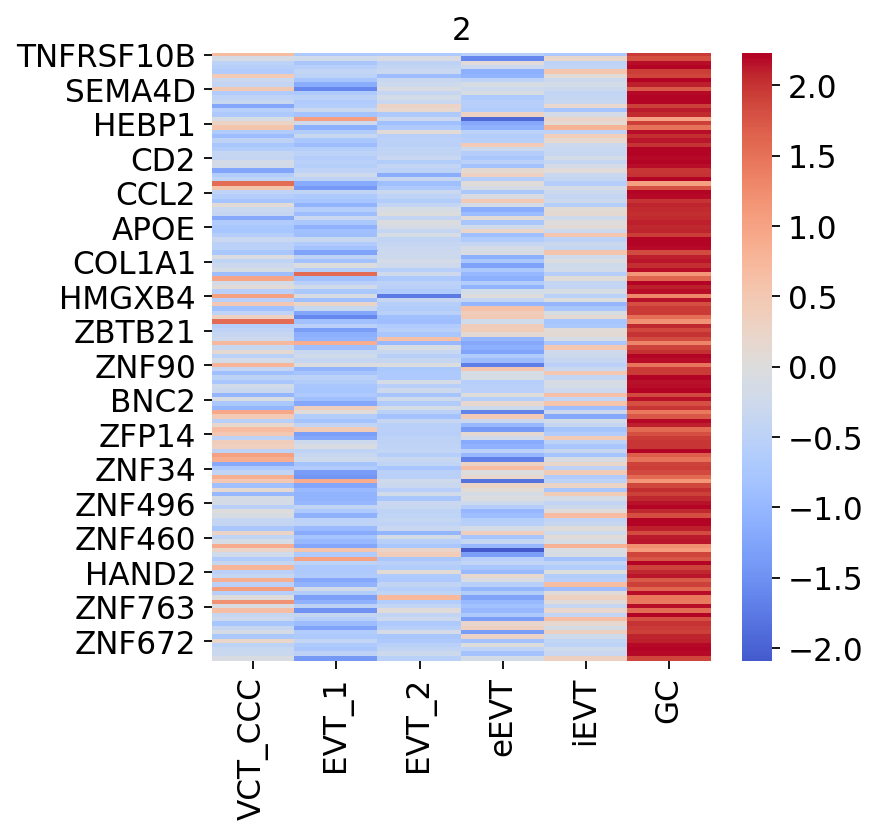

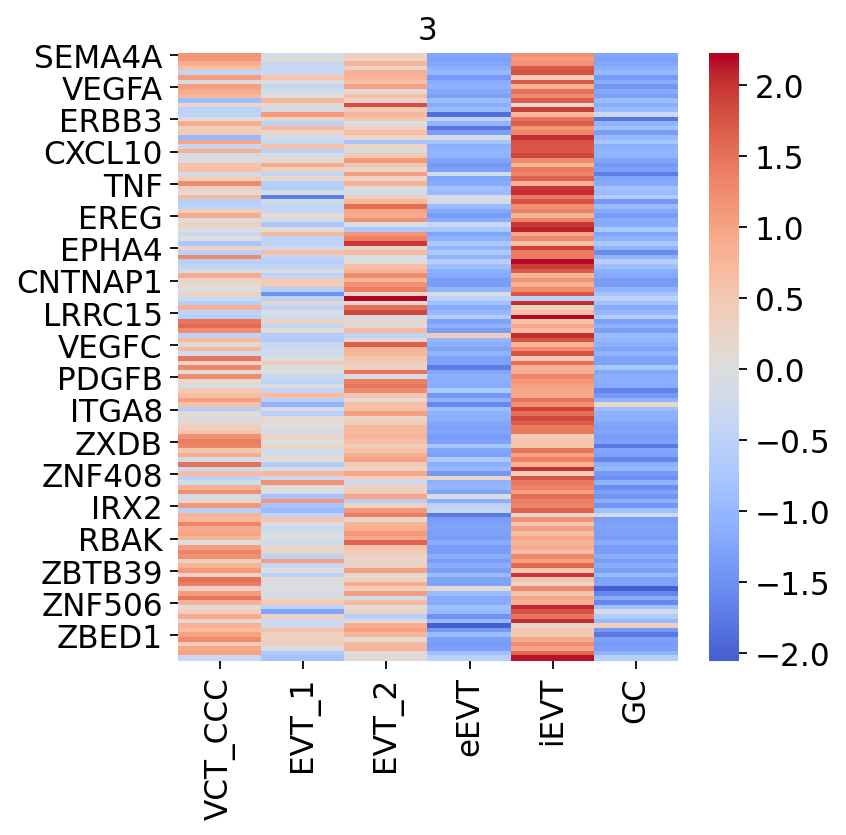

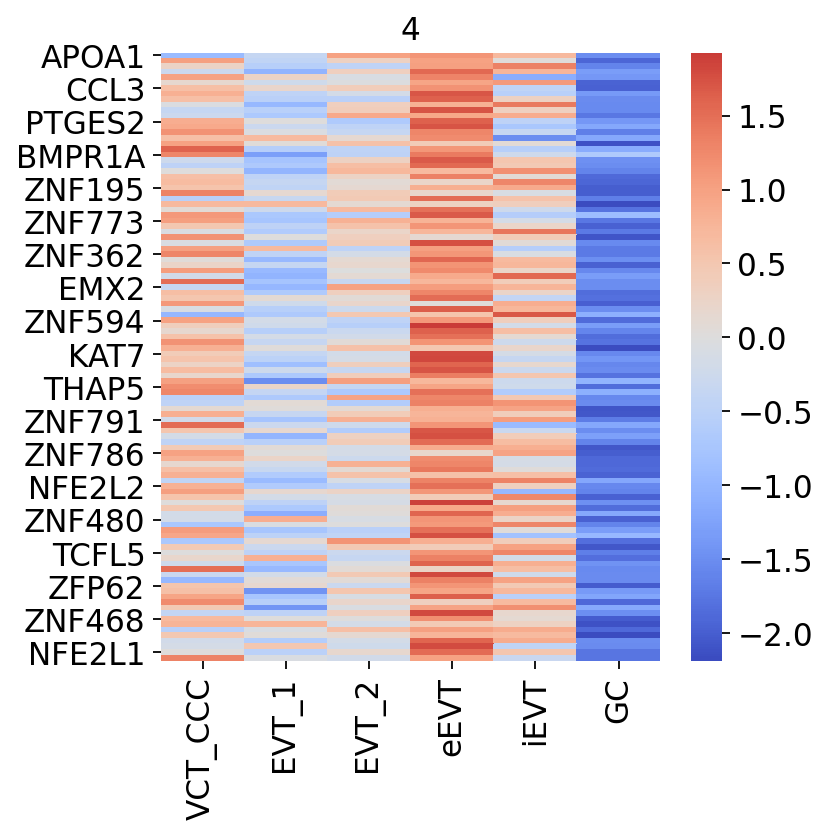

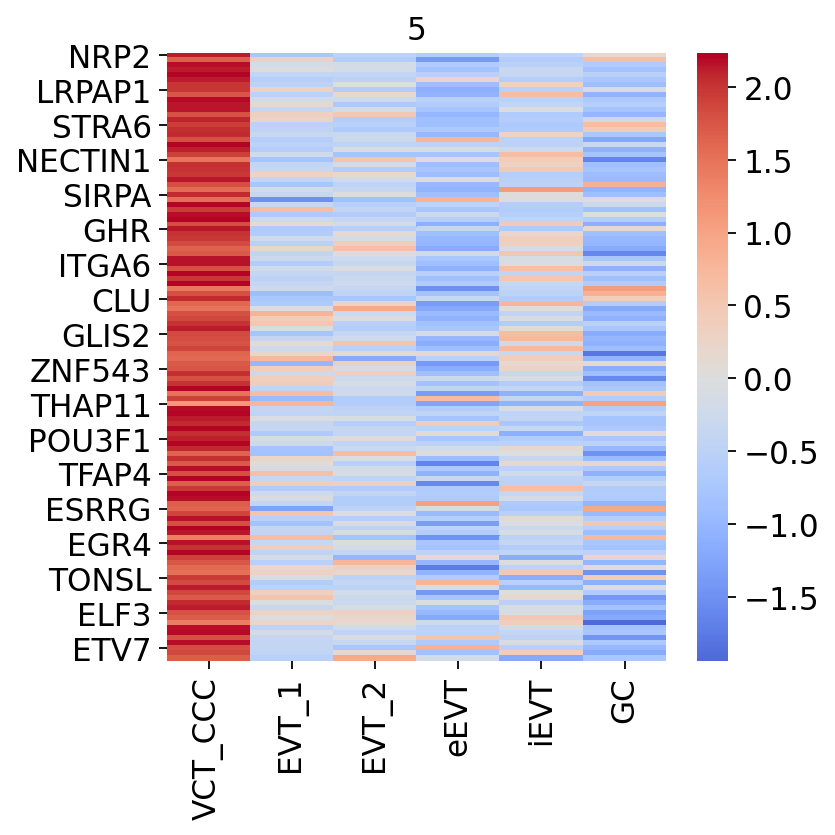

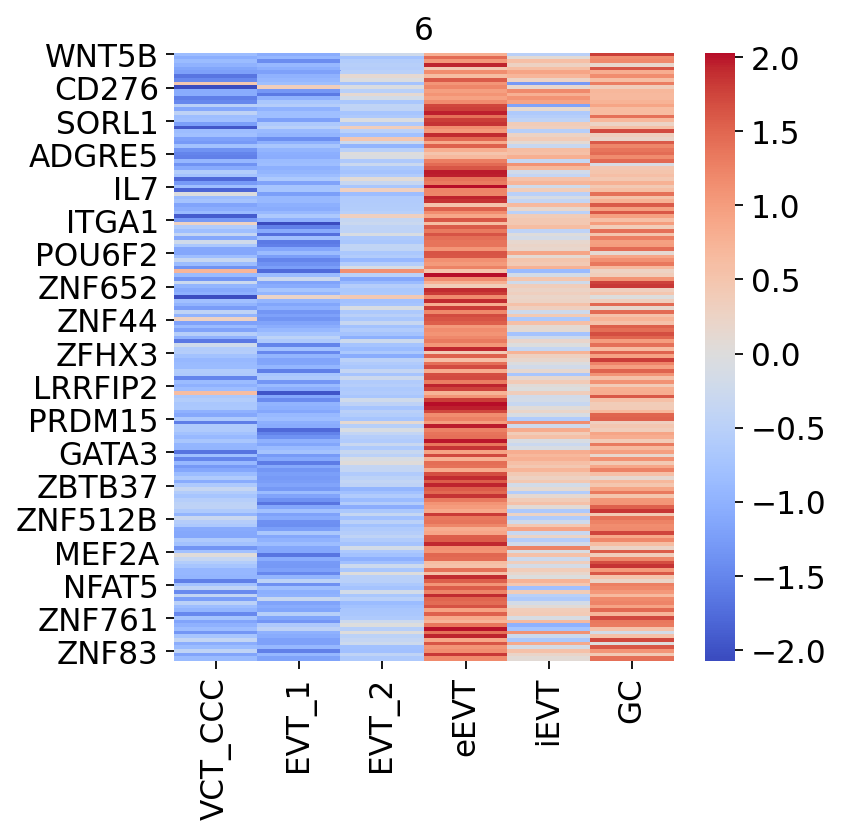

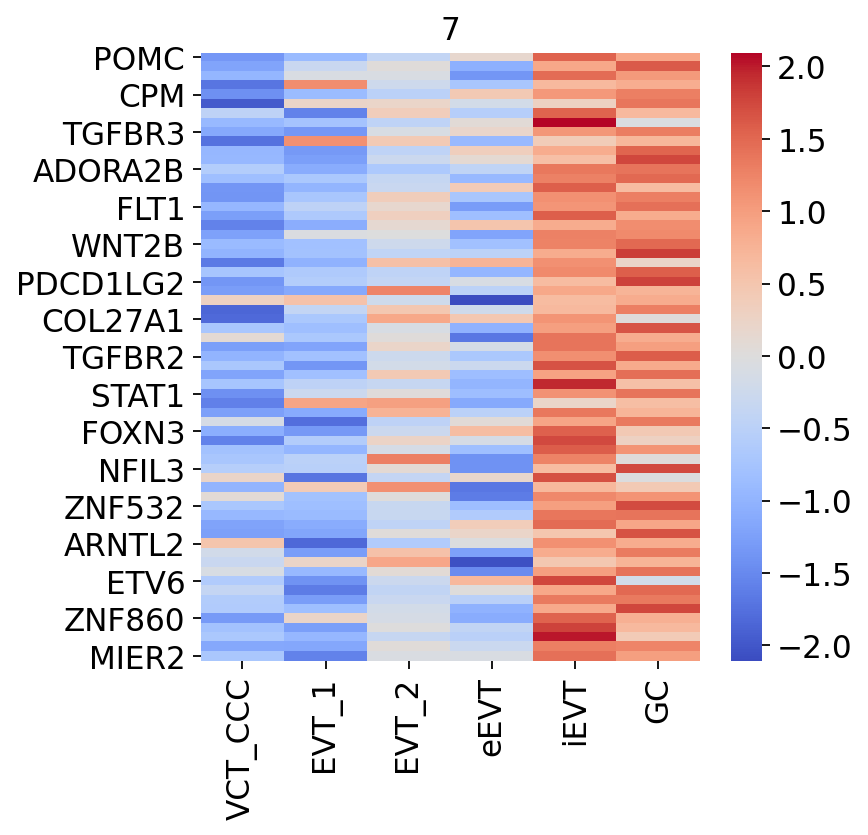

In [205]:
# with 8 clusters - looks better than with k=4
for cluster in np.unique(df_TF_clusters['Cluster']):
    plt.figure(figsize=(5,5))
    plt.title(cluster)
    sns.heatmap(df_TF_clusters[df_TF_clusters['Cluster'] == cluster].loc[:,ct_in_order], 
                center=0, cmap='coolwarm')

# cluster 6 here is ambiguous - going to disregard those genes since they are not specific to either eEVT or GC branches of the trajectory

In [100]:
# assignment of clusters to MEs upon visual inspection
cluster2ME = {}

cluster2ME[0.0] = 'ME_1_early_inv_column' 
cluster2ME[1.0] = 'ME_4_artery_remodelling'
cluster2ME[2.0] = 'ME_3_fusion'
cluster2ME[3.0] = 'ME_2_inv_front'
cluster2ME[4.0] = 'ME_2_inv_front'
cluster2ME[5.0] = 'ME_1_early_inv_column'
cluster2ME[6.0] = 'ambiguous'
cluster2ME[7.0] = 'ME_3_fusion'

In [101]:
MEs = ['ME_1_early_inv_column','ME_2_inv_front','ME_3_fusion','ME_4_artery_remodelling']

In [115]:
df_avg_expr_zscores

EVT_1     EVT_2        GC       VCT   VCT_CCC      eEVT      iEVT
E2F5    -0.526632 -0.410583 -0.782040  2.142370  0.761160 -0.782040 -0.402234
ZXDB    -0.272019  0.243674 -1.323751  1.592216  0.888019 -1.323751  0.195613
NFXL1   -1.015127 -0.414884  1.320214 -1.085640 -0.864936  0.979565  1.080809
ZKSCAN8 -1.527410 -0.693535  1.350161  0.463886 -0.990917  1.006350  0.391464
ZNF773  -0.889534  0.388802 -1.683333  1.616519  0.566470  0.381281 -0.380205
...           ...       ...       ...       ...       ...       ...       ...
NR1H2    0.597191 -0.330718 -2.263949  0.970240  0.606525  0.283794  0.136916
RFX2    -0.896329  0.913594  0.888695 -1.091903 -1.022553 -0.291314  1.499810
ZNF600  -0.758617 -0.383290 -0.780073 -0.373657 -0.235305  2.331129  0.199813
GLI4    -0.638761 -0.176344 -1.609064 -0.066172 -0.204180  1.731650  0.962871
ZSCAN4  -0.585929  0.032472 -0.970061  0.304421  0.025767 -0.970061  2.163391

[655 rows x 7 columns]

In [116]:
df_avg_expr_zscores_no_VCT

EVT_1     EVT_2        GC   VCT_CCC      eEVT      iEVT
E2F5    -0.323821 -0.102207 -0.811561  2.135413 -0.811561 -0.086263
ZXDB    -0.008101  0.620176 -1.289444  1.405192 -1.289444  0.561622
NFXL1   -1.235299 -0.615367  1.176642 -1.080181  0.824820  0.929384
ZKSCAN8 -1.367270 -0.581024  1.345942 -0.861420  1.021769  0.442003
ZNF773  -0.764143  0.811102 -1.742312  1.030035  0.801834 -0.136517
...           ...       ...       ...       ...       ...       ...
NR1H2    0.765189 -0.170412 -2.119671  0.774601  0.449194  0.301099
RFX2    -1.115260  0.756678  0.730926 -1.245809 -0.489515  1.362980
ZNF600  -0.769000 -0.417399 -0.789099 -0.278769  2.125424  0.128842
GLI4    -0.601808 -0.173537 -1.500462 -0.199317  1.593568  0.881556
ZSCAN4  -0.499363  0.077638 -0.857779  0.071383 -0.857779  2.065900

[655 rows x 6 columns]

In [127]:
# lists of TFs corresponding to patterns of expression in MEs
MEs_TFs = {}

# through EVT_1?
alt_eEVT_route = []

# through EVT_2
main_eEVT_route = []

patterns = []

for ME in MEs:
    print(ME)
    MEs_TFs[ME] = []
    
    for TF in list(df_avg_expr_zscores_no_VCT.index):
        curr_pattern = str(list(df_avg_expr_zscores_no_VCT.loc[TF][df_avg_expr_zscores_no_VCT.loc[TF] > 0].index))
        
        patterns.append(curr_pattern)
        #print('curr_pattern', curr_pattern)
        
        if curr_pattern in ["['EVT_1', 'eEVT']","['VCT_CCC', 'EVT_1', 'eEVT']"]:
            alt_eEVT_route.append(TF)
        elif curr_pattern in [
            # 2-ct chunks of eEVT streak
            "['EVT_2', 'eEVT']",
            # 3-ct chunks of eEVT streak
            "['EVT_1', 'EVT_2', 'eEVT']",
            # 4-ct chunks of eEVT streak
            "['VCT_CCC', 'EVT_1', 'EVT_2', 'eEVT']",]:
            main_eEVT_route.append(TF)
        
        curr_TF_cluster = df_TF_clusters.loc[TF,'Cluster']
        
        print(type(curr_TF_cluster))
        
        ME_from_curr_TF_cluster = cluster2ME[curr_TF_cluster]
        
        if ME_from_curr_TF_cluster == ME:
            print(TF)
            # which comparison is this TF coming from?
            for comparison in comparisons:
                #print(comparison)
                curr_comparison_TFs = [elem.split('-')[-1] for elem in list(TFs_to_visualise_dfs_scaled[comparison].index)]
                if TF in curr_comparison_TFs:
                    curr_comparison = comparison

            print('this TF is coming from comparison:', curr_comparison)

            print('appending current TF to ME', )
            MEs_TFs[ME].append(TF)
            
    print('here picking up', len(MEs_TFs[ME]), 'TFs')
    print('\n')

ME_1_early_inv_column
<class 'numpy.int64'>
E2F5
this TF is coming from comparison: EVT_1_vs_VCT_CCC
appending current TF to ME
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
ZFP91
this TF is coming from comparison: VCT_CCC_vs_VCT
appending current TF to ME
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
ZNF548
this TF is coming from comparison: VCT_CCC_vs_VCT
appending current TF to ME
<class 'numpy.int64'>
<class 'numpy.int64'>
ZNF691
this TF is coming from comparison: VCT_CCC_vs_VCT
appending current TF to ME
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
ZNF59

In [128]:
alt_eEVT_route = list(set(alt_eEVT_route))
len(alt_eEVT_route)

1

In [130]:
alt_eEVT_route

['TCF25']

In [129]:
main_eEVT_route = list(set(main_eEVT_route))
len(main_eEVT_route)

2

In [131]:
main_eEVT_route

['ID3', 'ID4']

In [132]:
MEs_TFs['ME_1_early_inv_column']

['E2F5',
 'ZFP91',
 'ZNF548',
 'ZNF691',
 'ZNF599',
 'YBX3',
 'ZNF146',
 'TGIF2',
 'E2F4',
 'ZC3H8',
 'ZBTB7C',
 'ESRRG',
 'NFKBIB',
 'PEG3',
 'POU4F1',
 'ID2',
 'E2F2',
 'NR4A2',
 'JUNB',
 'TP63',
 'SSRP1',
 'DNAJC2',
 'MYC',
 'GRHL3',
 'NFYB',
 'ZNF32',
 'SALL2',
 'POU2F2',
 'ATF5',
 'ZNF835',
 'IRX4',
 'ZNF17',
 'E2F7',
 'HOXA7',
 'ZNF22',
 'EGR1',
 'KAT5',
 'ZBTB24',
 'CREM',
 'E2F3',
 'TFEB',
 'ZNF232',
 'POU3F1',
 'PHF5A',
 'TP53',
 'CREB3',
 'FOS',
 'TBPL1',
 'ARID5B',
 'ID3',
 'ZNF574',
 'IRF6',
 'CEBPA',
 'TEAD4',
 'NONO',
 'THAP11',
 'DUXA',
 'NFKBIL1',
 'ATF3',
 'ZNF580',
 'ZNF404',
 'SMARCE1',
 'ZNF226',
 'TFAM',
 'ZNF175',
 'BATF3',
 'OSR2',
 'ZFP42',
 'HEY1',
 'TFDP1',
 'ETV7',
 'ZIK1',
 'TONSL',
 'POU2F3',
 'ERF',
 'TEF',
 'ZNF799',
 'BHLHE40',
 'ZNF544',
 'ZNF343',
 'KAT8',
 'FOXN1',
 'YBX1',
 'NR2F2',
 'ZNF816',
 'ZNF689',
 'EGR3',
 'NFE2L3',
 'SOX15',
 'ZFP69B',
 'ZNF511',
 'ELF3',
 'CREB3L4',
 'CDC5L',
 'LYAR',
 'ZNF626',
 'TOX4',
 'SNAI2',
 'ZNF880',
 'GTF3A',
 'ZNF

In [133]:
for i in range(len(np.unique(patterns, return_counts=True)[0])):
    print(np.unique(patterns, return_counts=True)[0][i], np.unique(patterns, return_counts=True)[1][i])

['EVT_1', 'EVT_2', 'GC', 'VCT_CCC'] 8
['EVT_1', 'EVT_2', 'GC', 'iEVT'] 12
['EVT_1', 'EVT_2', 'VCT_CCC', 'eEVT', 'iEVT'] 24
['EVT_1', 'EVT_2', 'VCT_CCC', 'eEVT'] 20
['EVT_1', 'EVT_2', 'VCT_CCC', 'iEVT'] 100
['EVT_1', 'EVT_2', 'VCT_CCC'] 72
['EVT_1', 'EVT_2', 'eEVT', 'iEVT'] 12
['EVT_1', 'EVT_2', 'eEVT'] 4
['EVT_1', 'EVT_2', 'iEVT'] 4
['EVT_1', 'EVT_2'] 8
['EVT_1', 'GC', 'VCT_CCC', 'eEVT'] 4
['EVT_1', 'GC', 'VCT_CCC', 'iEVT'] 4
['EVT_1', 'GC', 'VCT_CCC'] 36
['EVT_1', 'GC', 'iEVT'] 4
['EVT_1', 'GC'] 12
['EVT_1', 'VCT_CCC', 'eEVT', 'iEVT'] 16
['EVT_1', 'VCT_CCC', 'eEVT'] 52
['EVT_1', 'VCT_CCC', 'iEVT'] 48
['EVT_1', 'VCT_CCC'] 124
['EVT_1', 'eEVT', 'iEVT'] 12
['EVT_1', 'eEVT'] 4
['EVT_1', 'iEVT'] 4
['EVT_1'] 4
['EVT_2', 'GC', 'VCT_CCC', 'eEVT'] 4
['EVT_2', 'GC', 'VCT_CCC', 'iEVT'] 20
['EVT_2', 'GC', 'eEVT', 'iEVT'] 16
['EVT_2', 'GC', 'iEVT'] 36
['EVT_2', 'GC'] 8
['EVT_2', 'VCT_CCC', 'eEVT', 'iEVT'] 76
['EVT_2', 'VCT_CCC', 'eEVT'] 24
['EVT_2', 'VCT_CCC', 'iEVT'] 108
['EVT_2', 'VCT_CCC'] 20
[

In [134]:
df_avg_expr_zscores = df_avg_expr_zscores.astype(float)

# To discuss situation below

In [135]:
alt_eEVT_route = list(set(alt_eEVT_route))
len(alt_eEVT_route)

1

<AxesSubplot:>

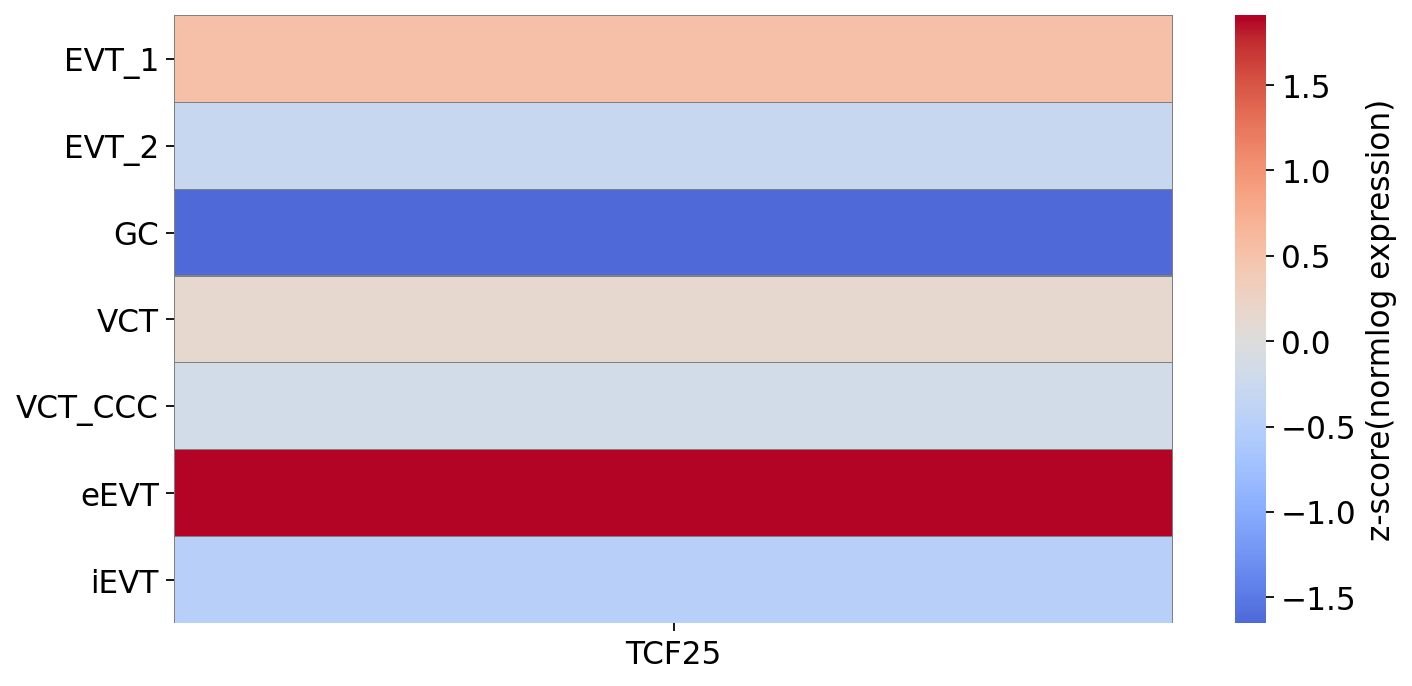

In [136]:
# curious about this alternative route to eEVT through EVT_1

plt.figure(figsize=(10,5))

sns.heatmap(df_avg_expr_zscores.loc[alt_eEVT_route].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(normlog expression)'}
             )
#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_EVT_1_eEVT_route_ALL_TFs.pdf', bbox_inches='tight')

<AxesSubplot:>

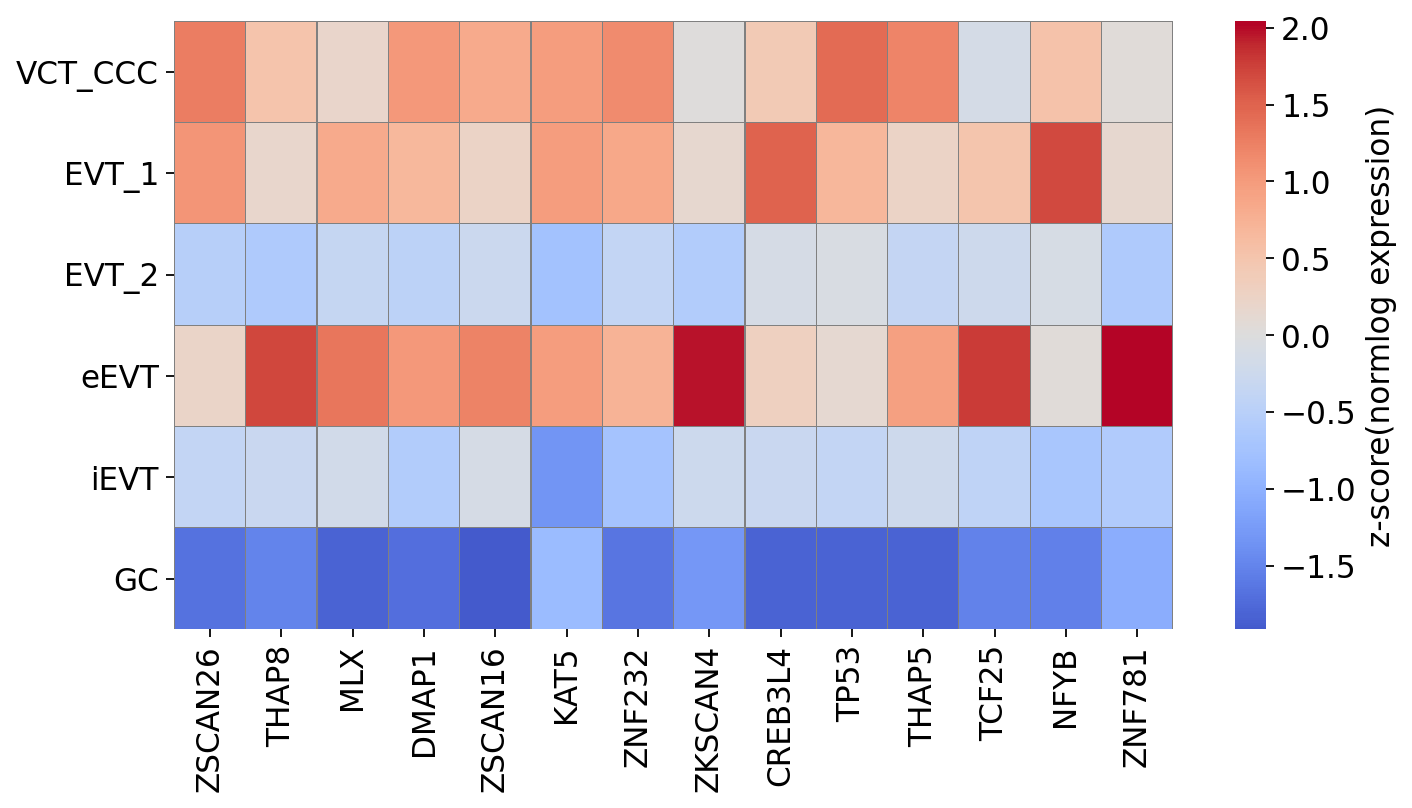

In [257]:
# curious about this alternative route to eEVT through EVT_1

plt.figure(figsize=(10,5))

sns.heatmap(df_avg_expr_zscores.loc[alt_eEVT_route].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(normlog expression)'}
             )
#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_EVT_1_eEVT_route_ALL_TFs.pdf', bbox_inches='tight')

In [137]:
main_eEVT_route = list(set(main_eEVT_route))
len(main_eEVT_route)

2

<AxesSubplot:>

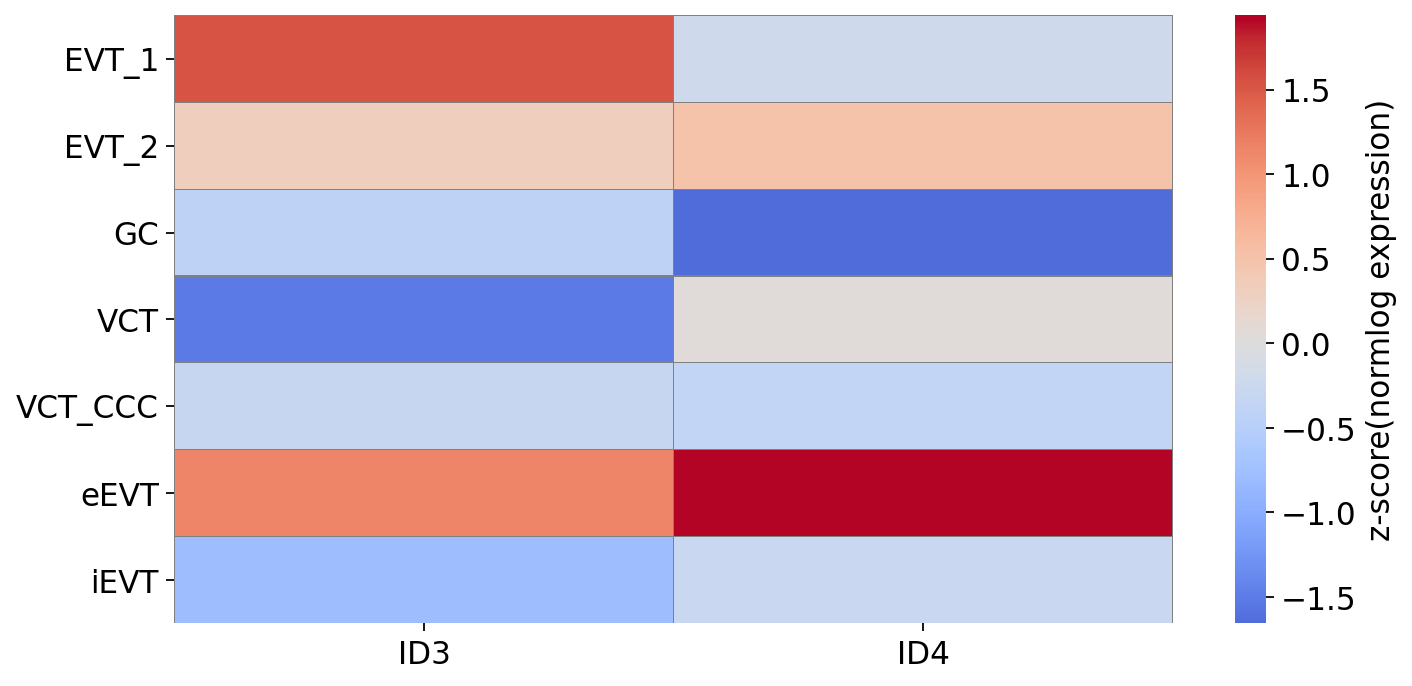

In [138]:
plt.figure(figsize=(10,5))

sns.heatmap(df_avg_expr_zscores.loc[main_eEVT_route].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(normlog expression)'}
             )
#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_EVT_1_eEVT_route_ALL_TFs.pdf', bbox_inches='tight')

<AxesSubplot:>

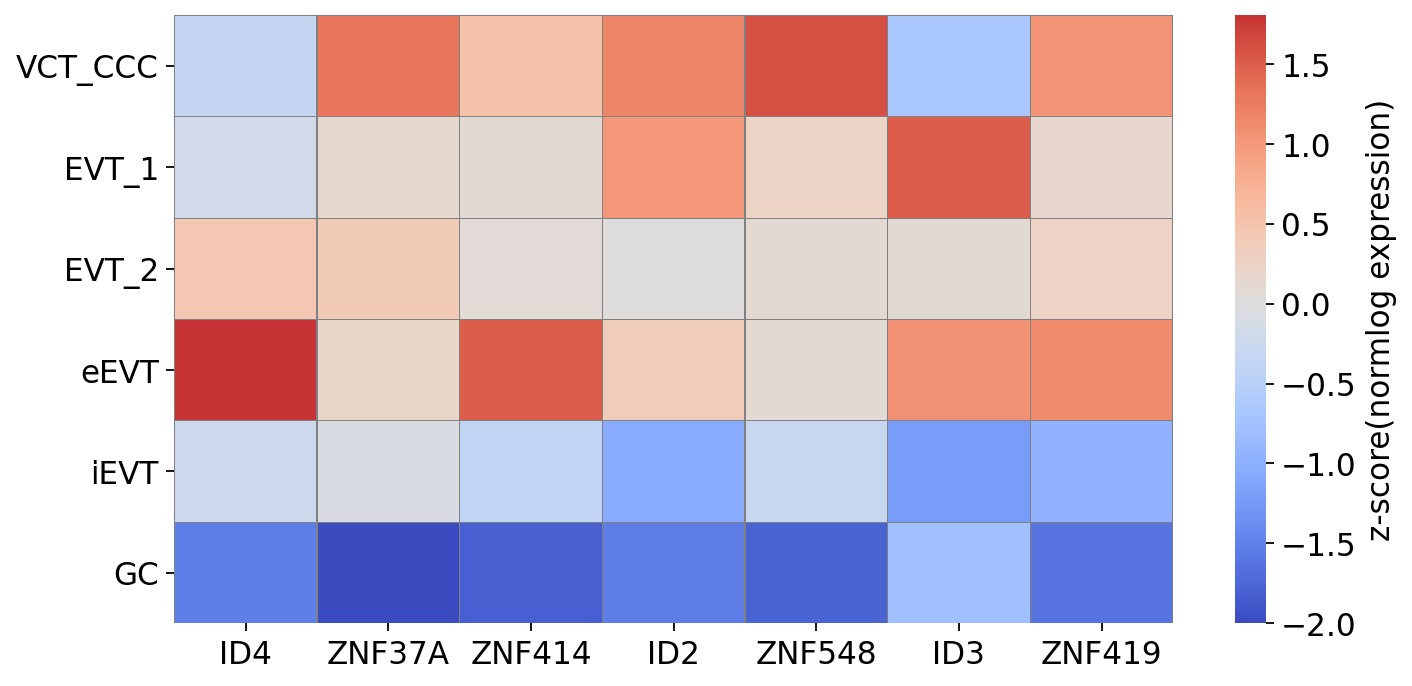

In [259]:
plt.figure(figsize=(10,5))

sns.heatmap(df_avg_expr_zscores.loc[main_eEVT_route].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(normlog expression)'}
             )
#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_EVT_1_eEVT_route_ALL_TFs.pdf', bbox_inches='tight')

In [139]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [140]:
# sorted by alphabet for ease of eye inspection
all_TFs_final = list(sorted(MEs_TFs['ME_1_early_inv_column']) + sorted(MEs_TFs['ME_2_inv_front']) + sorted(MEs_TFs['ME_3_fusion']) + sorted(MEs_TFs['ME_4_artery_remodelling']))
len(all_TFs_final)

537

In [262]:
# sorted by alphabet for ease of eye inspection
all_TFs_final = list(sorted(MEs_TFs['ME_1_early_inv_column']) + sorted(MEs_TFs['ME_2_inv_front']) + sorted(MEs_TFs['ME_3_fusion']) + sorted(MEs_TFs['ME_4_artery_remodelling']))
len(all_TFs_final)

537

# but what about the ambiguous cluster of TFs here?

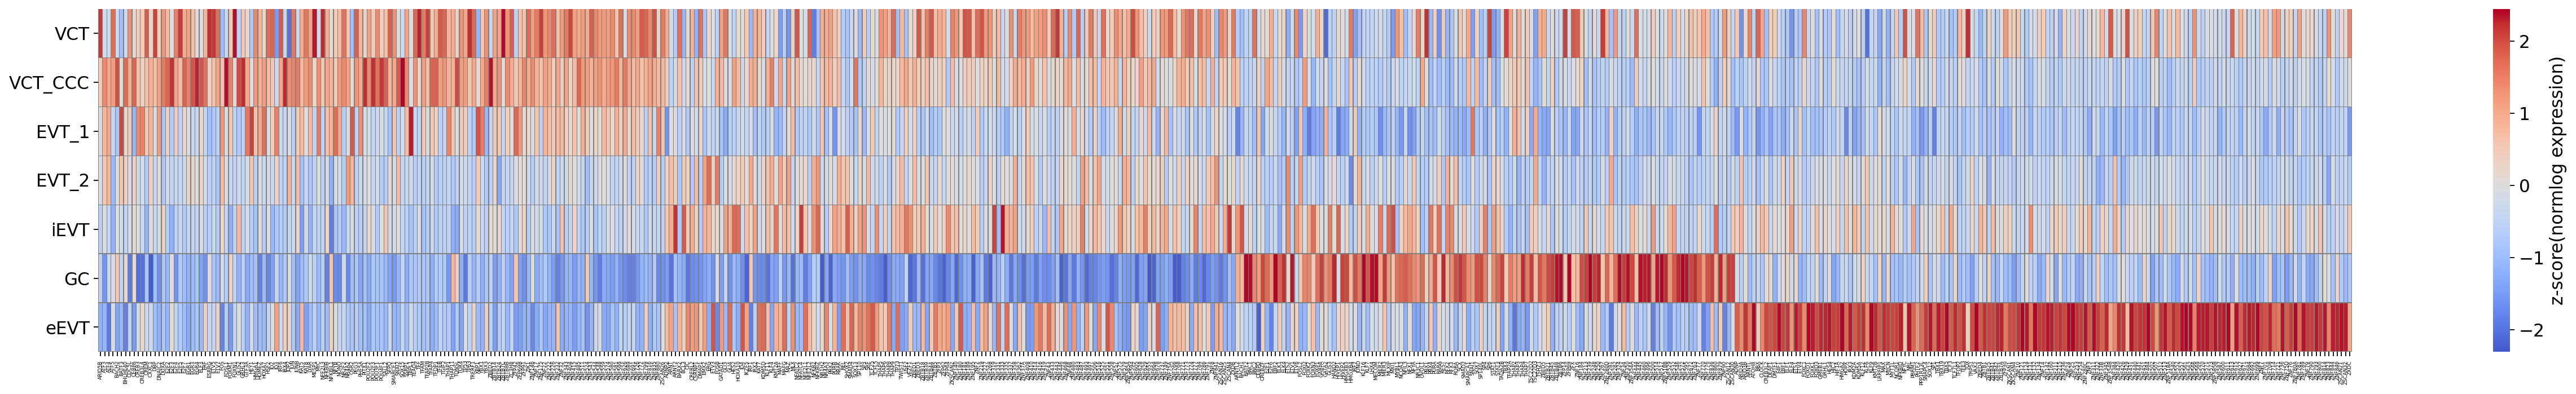

In [142]:
# all 4 MEs plotted together

plt.figure(figsize=(40,5))

sns.heatmap(df_avg_expr_zscores.loc[all_TFs_final,['VCT','VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(normlog expression)'}
             )
x = np.arange(0.5, len(all_TFs_final) + 0.5, 1)
plt.xticks(x, fontsize=4, labels = all_TFs_final)

# already saved
#plt.savefig('./figures/20220213_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

plt.show()

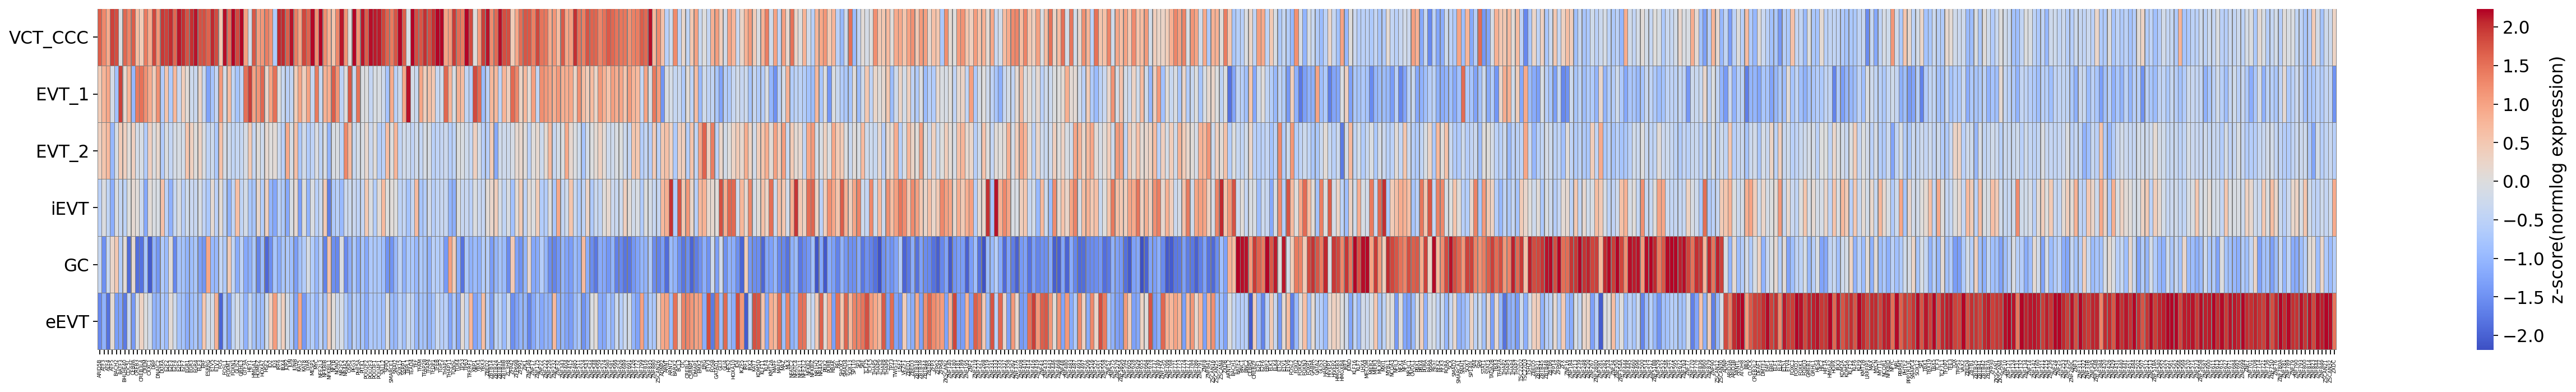

In [263]:
# all 4 MEs plotted together

plt.figure(figsize=(40,5))

sns.heatmap(df_avg_expr_zscores.loc[all_TFs_final,['VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(normlog expression)'}
             )
x = np.arange(0.5, len(all_TFs_final) + 0.5, 1)
plt.xticks(x, fontsize=4, labels = all_TFs_final)

# already saved
plt.savefig('./figures/20220213_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# plot by ME for Roser

In [143]:
MEs

['ME_1_early_inv_column',
 'ME_2_inv_front',
 'ME_3_fusion',
 'ME_4_artery_remodelling']

In [144]:
all_TFs_final_df = pd.DataFrame(index=all_TFs_final)
MEs_vec = [[ME for i in range(len(MEs_TFs[ME]))] for ME in MEs]
MEs_vec = [item for sublist in MEs_vec for item in sublist]
all_TFs_final_df['ME'] = MEs_vec
all_TFs_final_df

ME
ARID5B     ME_1_early_inv_column
ATF3       ME_1_early_inv_column
ATF4       ME_1_early_inv_column
ATF5       ME_1_early_inv_column
BACH2      ME_1_early_inv_column
...                          ...
ZNF844   ME_4_artery_remodelling
ZNF846   ME_4_artery_remodelling
ZSCAN21  ME_4_artery_remodelling
ZSCAN32  ME_4_artery_remodelling
ZXDC     ME_4_artery_remodelling

[537 rows x 1 columns]

In [145]:
all_TFs_final_df.to_csv('./20220216_final_TFs_df_plot_Fig2F.csv')

In [202]:
ct_in_order = ['VCT','VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']
df_avg_expr_zscores = df_avg_expr_zscores.loc[:,ct_in_order]

In [217]:
# simplifying this to mimic Luz&Valentina's code, will add MEFISTO-layer evidence later

df_TFs_evidence_per_ME = {}

# which comparisons was the TF prioritised through? and what was the sign (upreg or downreg)?
comparisons_per_TF = {}

# which comparisons was the TF prioritised through?
evidences_per_TF = {}

for ME in MEs:
    print(ME)
    df_TFs_evidence_per_ME[ME] = pd.DataFrame(index = MEs_TFs[ME],
                                         columns = list(df_avg_expr_zscores.columns))
    
    for TF in df_TFs_evidence_per_ME[ME].index:
        for comparison in comparisons:
            if TF in TFs_upregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_upreg'
                sign = '+'
                evidences_per_TF[TF] = list(TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']][TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison.split('_vs_')[0] # cell type position in heatmap
                
                if evidences_per_TF[TF] == ['is_DA_dorothea']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'aM'
                elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'oM'
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*M'
                    
            
            elif TF in TFs_downregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_downreg'
                sign = '-'
                evidences_per_TF[TF] = list(TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']][TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison.split('_vs_')[0] # cell type position in heatmap
                
                if evidences_per_TF[TF] == ['is_DA_dorothea']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'aM'
                elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'oM'
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*M'
                

ME_1_early_inv_column
ME_2_inv_front
ME_3_fusion
ME_4_artery_remodelling


In [218]:
#df_TFs_evidence_per_ME['ME_1_early_inv_column']

In [219]:
# here for all MEs together
df_TFs_evidence_all = pd.concat(list(df_TFs_evidence_per_ME.values()))
df_TFs_evidence_all = df_TFs_evidence_all.loc[all_TFs_final]


In [220]:
df_TFs_evidence_all

VCT VCT_CCC EVT_1 EVT_2 iEVT   GC eEVT
ARID5B   NaN     NaN     a   NaN  NaN  NaN  NaN
ATF3     NaN     NaN     a   NaN  NaN  NaN  NaN
ATF4     NaN       a    aM     a  NaN  NaN  NaN
ATF5     NaN     NaN   NaN     a  NaN  NaN  NaN
BACH2    NaN     NaN    *M   NaN  NaN  NaN  NaN
...      ...     ...   ...   ...  ...  ...  ...
ZNF844   NaN     NaN     a   NaN  NaN  NaN  NaN
ZNF846   NaN     NaN   NaN     a  NaN  NaN    a
ZSCAN21  NaN       a   NaN   NaN  NaN  NaN  NaN
ZSCAN32  NaN     NaN   NaN   NaN  NaN  NaN    a
ZXDC     NaN       a     a   NaN    a  NaN  NaN

[537 rows x 7 columns]

In [221]:
# here for all MEs together
coords_annotation_all = []

curr_df = df_TFs_evidence_all

for TF in curr_df.index:
    #print(TF)
    x_shift = 0.25 # should be consistent for all 4 heatmaps (per ME)
    curr_coord_x = x_shift + list(curr_df.index).index(TF) # x coordinate of TF
    #print(curr_coord_x)

    for ct in curr_df.columns:
        if str(curr_df.loc[TF,ct]) != 'nan':
            #print(TF, ct)
            y_shift = 0.7 # is different for different heatmaps (per ME)?
            curr_coord_y = y_shift + list(curr_df.columns).index(ct) # y coordinate of cell type
            coords_annotation_all.append([(curr_coord_x, curr_coord_y), curr_df.loc[TF,ct]])


In [222]:
# common color limits for all 4 heatmaps
common_max = np.max(df_avg_expr_zscores.values)
common_min = np.min(df_avg_expr_zscores.values)
common_min

-2.3049601173754564

In [223]:
df_avg_expr_zscores

VCT   VCT_CCC     EVT_1     EVT_2      iEVT        GC      eEVT
E2F5     2.142370  0.761160 -0.526632 -0.410583 -0.402234 -0.782040 -0.782040
ZXDB     1.592216  0.888019 -0.272019  0.243674  0.195613 -1.323751 -1.323751
NFXL1   -1.085640 -0.864936 -1.015127 -0.414884  1.080809  1.320214  0.979565
ZKSCAN8  0.463886 -0.990917 -1.527410 -0.693535  0.391464  1.350161  1.006350
ZNF773   1.616519  0.566470 -0.889534  0.388802 -0.380205 -1.683333  0.381281
...           ...       ...       ...       ...       ...       ...       ...
NR1H2    0.970240  0.606525  0.597191 -0.330718  0.136916 -2.263949  0.283794
RFX2    -1.091903 -1.022553 -0.896329  0.913594  1.499810  0.888695 -0.291314
ZNF600  -0.373657 -0.235305 -0.758617 -0.383290  0.199813 -0.780073  2.331129
GLI4    -0.066172 -0.204180 -0.638761 -0.176344  0.962871 -1.609064  1.731650
ZSCAN4   0.304421  0.025767 -0.585929  0.032472  2.163391 -0.970061 -0.970061

[655 rows x 7 columns]

In [224]:
# to enable adobe illustrator to recognise the text as editable text object
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


In [225]:
df_avg_expr_zscores

VCT   VCT_CCC     EVT_1     EVT_2      iEVT        GC      eEVT
E2F5     2.142370  0.761160 -0.526632 -0.410583 -0.402234 -0.782040 -0.782040
ZXDB     1.592216  0.888019 -0.272019  0.243674  0.195613 -1.323751 -1.323751
NFXL1   -1.085640 -0.864936 -1.015127 -0.414884  1.080809  1.320214  0.979565
ZKSCAN8  0.463886 -0.990917 -1.527410 -0.693535  0.391464  1.350161  1.006350
ZNF773   1.616519  0.566470 -0.889534  0.388802 -0.380205 -1.683333  0.381281
...           ...       ...       ...       ...       ...       ...       ...
NR1H2    0.970240  0.606525  0.597191 -0.330718  0.136916 -2.263949  0.283794
RFX2    -1.091903 -1.022553 -0.896329  0.913594  1.499810  0.888695 -0.291314
ZNF600  -0.373657 -0.235305 -0.758617 -0.383290  0.199813 -0.780073  2.331129
GLI4    -0.066172 -0.204180 -0.638761 -0.176344  0.962871 -1.609064  1.731650
ZSCAN4   0.304421  0.025767 -0.585929  0.032472  2.163391 -0.970061 -0.970061

[655 rows x 7 columns]

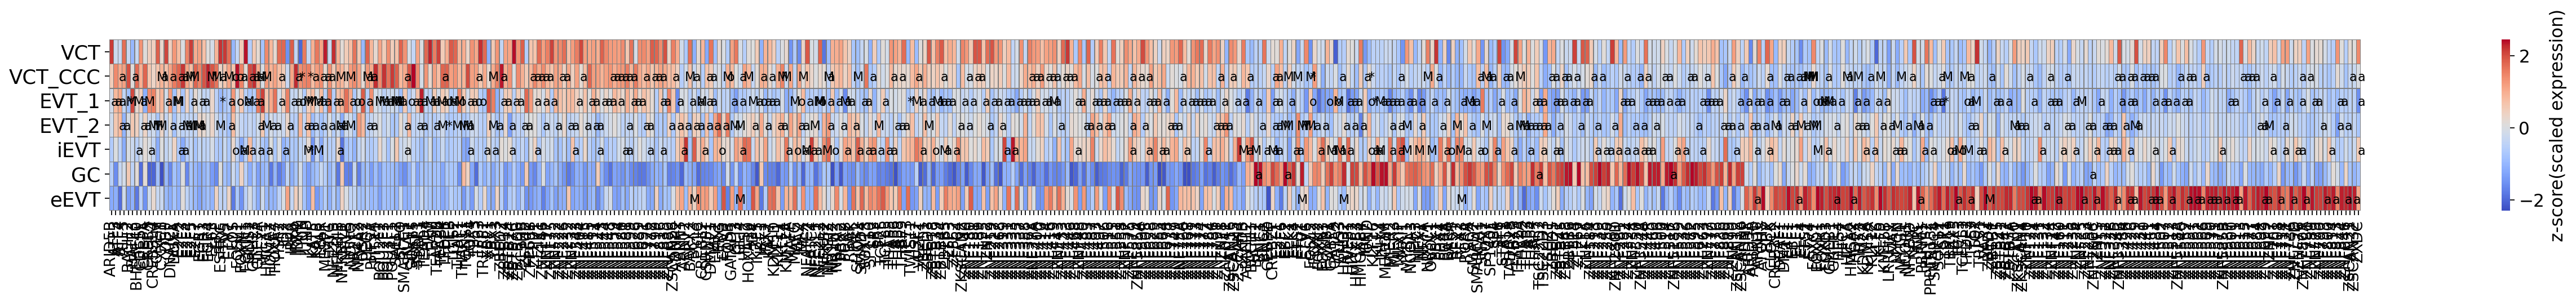

In [226]:
# playing a bit with the plotting here

# all MEs?

#curr_ME = 'ME_1_early_inv_column'

TFs2plot = all_TFs_final

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_all)):
    plt.annotate(coords_annotation_all[i][1], coords_annotation_all[i][0], fontsize=10)

#plt.savefig('./figures/Fig2G/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_with_annotation_ALL.pdf', bbox_inches='tight')

plt.show()


In [227]:
np.unique(df_TFs_evidence_per_ME['ME_1_early_inv_column']['VCT'])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan], dtype=object)

In [228]:
df_TFs_evidence_per_ME['ME_1_early_inv_column'].loc[sorted(MEs_TFs['ME_1_early_inv_column'])]

VCT VCT_CCC EVT_1 EVT_2 iEVT   GC eEVT
ARID5B   NaN     NaN     a   NaN  NaN  NaN  NaN
ATF3     NaN     NaN     a   NaN  NaN  NaN  NaN
ATF4     NaN       a    aM     a  NaN  NaN  NaN
ATF5     NaN     NaN   NaN     a  NaN  NaN  NaN
BACH2    NaN     NaN    *M   NaN  NaN  NaN  NaN
...      ...     ...   ...   ...  ...  ...  ...
ZNF799   NaN       a   NaN   NaN  NaN  NaN  NaN
ZNF816   NaN       a     a   NaN    a  NaN  NaN
ZNF835   NaN     NaN     a   NaN  NaN  NaN  NaN
ZNF880   NaN     NaN   NaN     a  NaN  NaN  NaN
ZSCAN26  NaN       a   NaN   NaN  NaN  NaN  NaN

[135 rows x 7 columns]

In [229]:
coords_annotation_per_ME = {}

for ME in MEs:
    print(ME)
    curr_df = df_TFs_evidence_per_ME[ME].loc[sorted(MEs_TFs[ME])]

    # coordinates where we want to add text annotation + annotation
    # [(float,float), str]
    coords_annotation_per_ME[ME] = []

    for TF in curr_df.index:
        #print(TF)
        x_shift = 0.25 # should be consistent for all 4 heatmaps (per ME)
        curr_coord_x = x_shift + list(curr_df.index).index(TF) # x coordinate of TF
        #print(curr_coord_x)

        for ct in curr_df.columns:
            if str(curr_df.loc[TF,ct]) != 'nan':
                #print(TF, ct)
                y_shift = 0.7 # is different for different heatmaps (per ME)?
                curr_coord_y = y_shift + list(curr_df.columns).index(ct) # y coordinate of cell type
                coords_annotation_per_ME[ME].append([(curr_coord_x, curr_coord_y), curr_df.loc[TF,ct]])


ME_1_early_inv_column
ME_2_inv_front
ME_3_fusion
ME_4_artery_remodelling


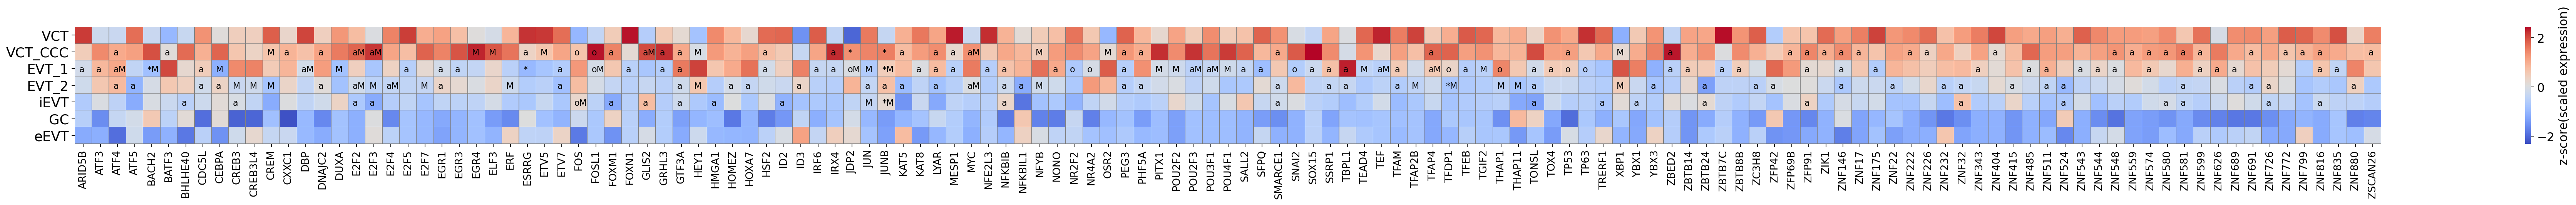

In [233]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_1_early_inv_column'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(60,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220216_TF_expression_heatmap_zscores_in_vivo_no_logFC_cutoff_with_annotation_' + curr_ME + '.pdf', bbox_inches='tight')

plt.show()


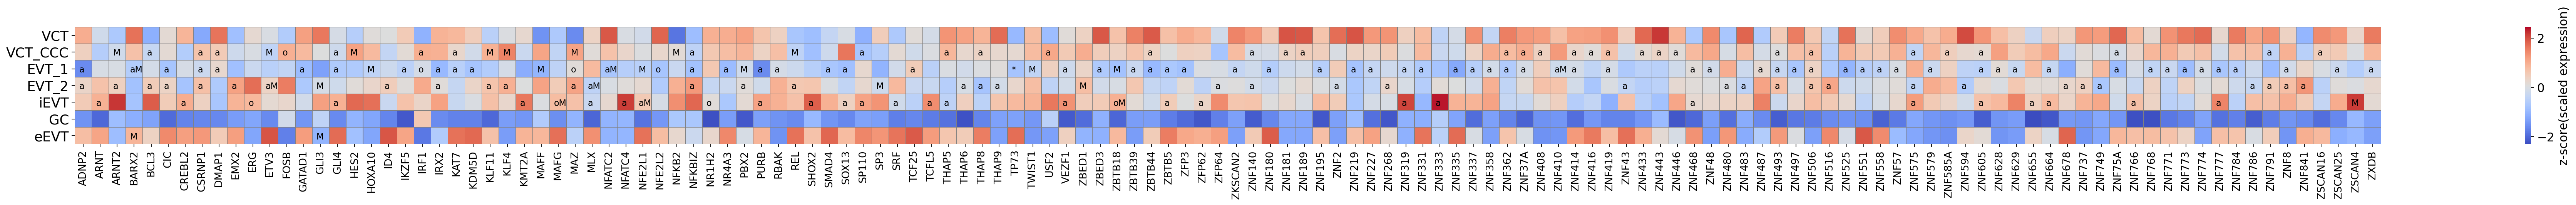

In [235]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_2_inv_front'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(60,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220216_TF_expression_heatmap_zscores_in_vivo_no_logFC_cutoff_with_annotation_' + curr_ME + '.pdf', bbox_inches='tight')

plt.show()


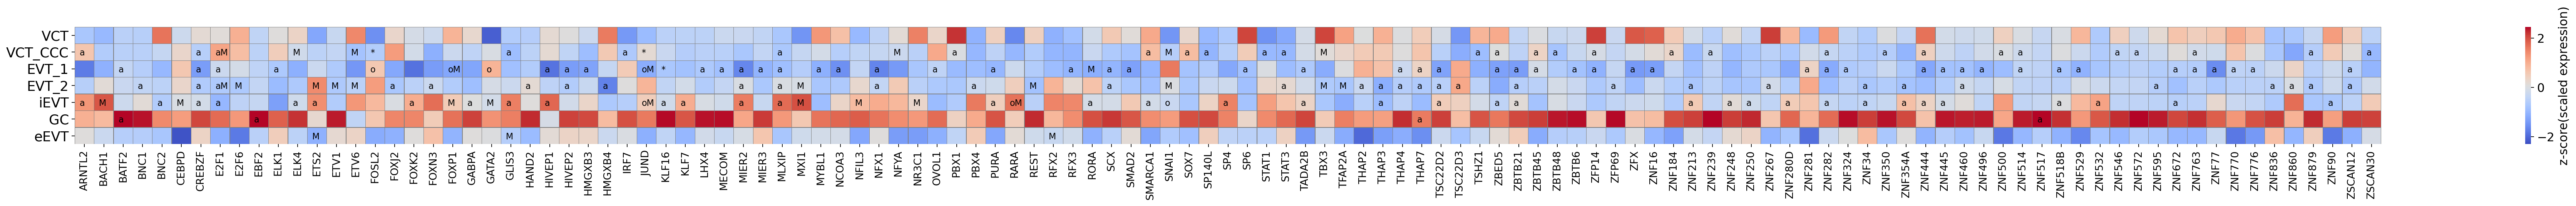

In [236]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_3_fusion'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(60,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220216_TF_expression_heatmap_zscores_in_vivo_no_logFC_cutoff_with_annotation_' + curr_ME + '.pdf', bbox_inches='tight')

plt.show()


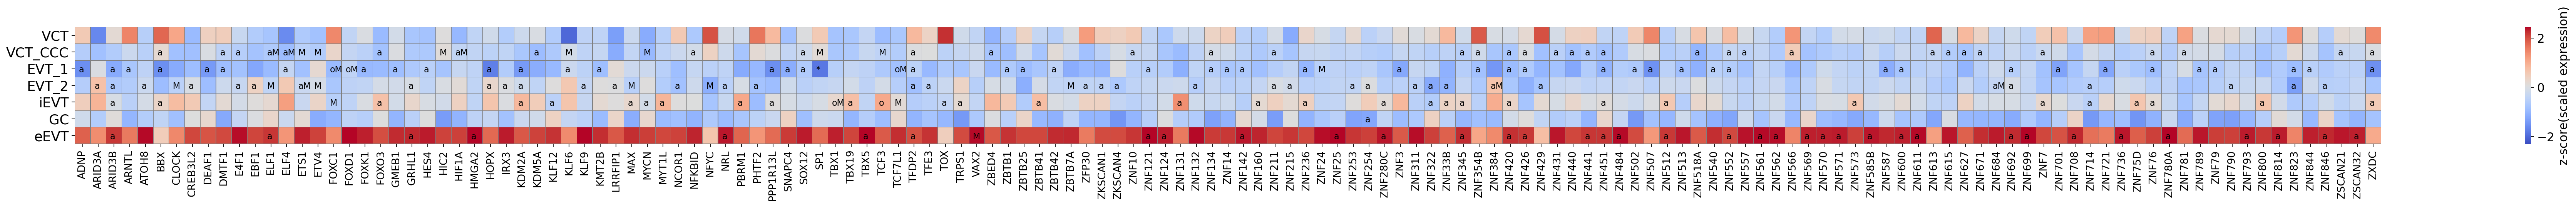

In [237]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_4_artery_remodelling'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(60,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220216_TF_expression_heatmap_zscores_in_vivo_no_logFC_cutoff_with_annotation_' + curr_ME + '.pdf', bbox_inches='tight')

plt.show()


In [185]:
coords_annotation_per_ME['ME_1_early_inv_column']

[[(0.25, 0.7), 'a'],
 [(1.25, 0.7), 'a'],
 [(2.25, 0.7), 'a'],
 [(2.25, 1.7), 'a'],
 [(2.25, 4.7), 'a'],
 [(3.25, 1.7), 'a'],
 [(4.25, 0.7), '*'],
 [(5.25, 4.7), 'a'],
 [(6.25, 6.7), 'a'],
 [(7.25, 0.7), 'a'],
 [(7.25, 1.7), 'a'],
 [(8.25, 1.7), 'a'],
 [(9.25, 6.7), 'a'],
 [(12.25, 4.7), 'a'],
 [(13.25, 0.7), 'a'],
 [(14.25, 1.7), 'a'],
 [(14.25, 4.7), 'a'],
 [(16.25, 1.7), 'a'],
 [(16.25, 4.7), 'a'],
 [(16.25, 6.7), 'a'],
 [(17.25, 4.7), 'a'],
 [(17.25, 6.7), 'a'],
 [(18.25, 1.7), 'a'],
 [(19.25, 0.7), 'a'],
 [(21.25, 0.7), 'a'],
 [(21.25, 1.7), 'a'],
 [(22.25, 0.7), 'a'],
 [(26.25, 0.7), '*'],
 [(26.25, 4.7), 'a'],
 [(28.25, 0.7), 'a'],
 [(28.25, 1.7), 'a'],
 [(29.25, 4.7), 'o'],
 [(29.25, 6.7), 'o'],
 [(30.25, 0.7), 'o'],
 [(30.25, 4.7), 'o'],
 [(31.25, 4.7), 'a'],
 [(31.25, 6.7), 'a'],
 [(32.25, 0.7), 'a'],
 [(33.25, 4.7), 'a'],
 [(33.25, 6.7), 'a'],
 [(34.25, 0.7), 'a'],
 [(34.25, 4.7), 'a'],
 [(35.25, 0.7), 'a'],
 [(35.25, 1.7), 'a'],
 [(35.25, 4.7), 'a'],
 [(35.25, 6.7), 'a'],
 

# TO DO: add MEFISTO here


try to produce the same heatmap with and without a logFC cutoff (a way to prioritise) per ME

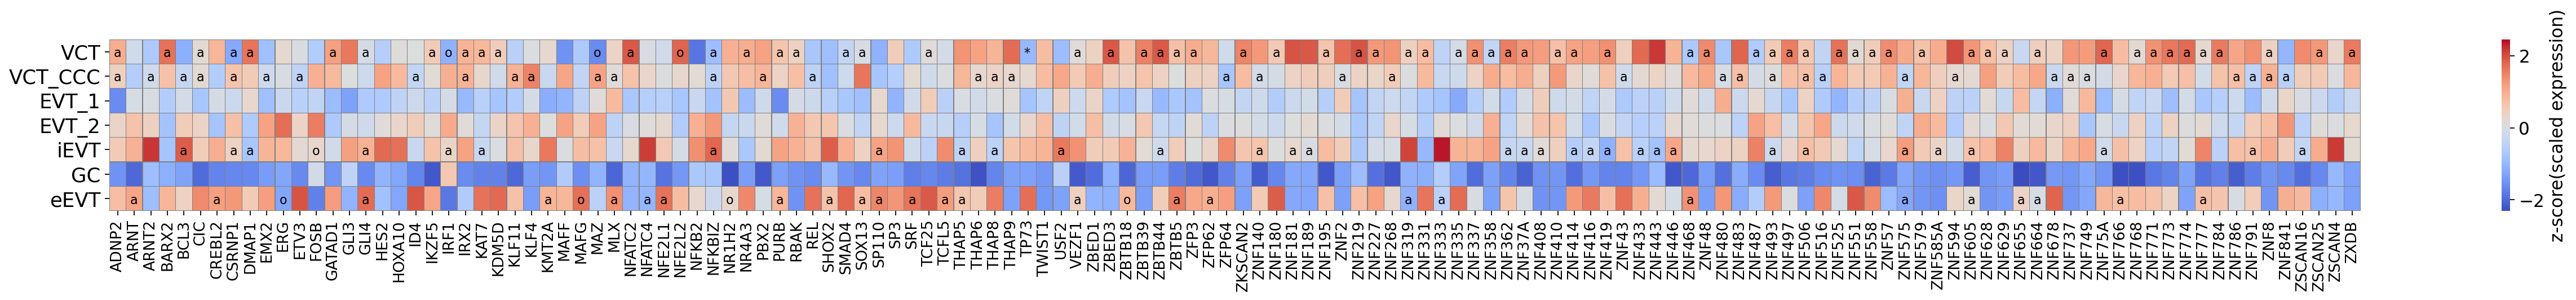

In [182]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_2_inv_front'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

#plt.savefig('./figures/Fig2G/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_with_annotation_ALL.pdf', bbox_inches='tight')

plt.show()


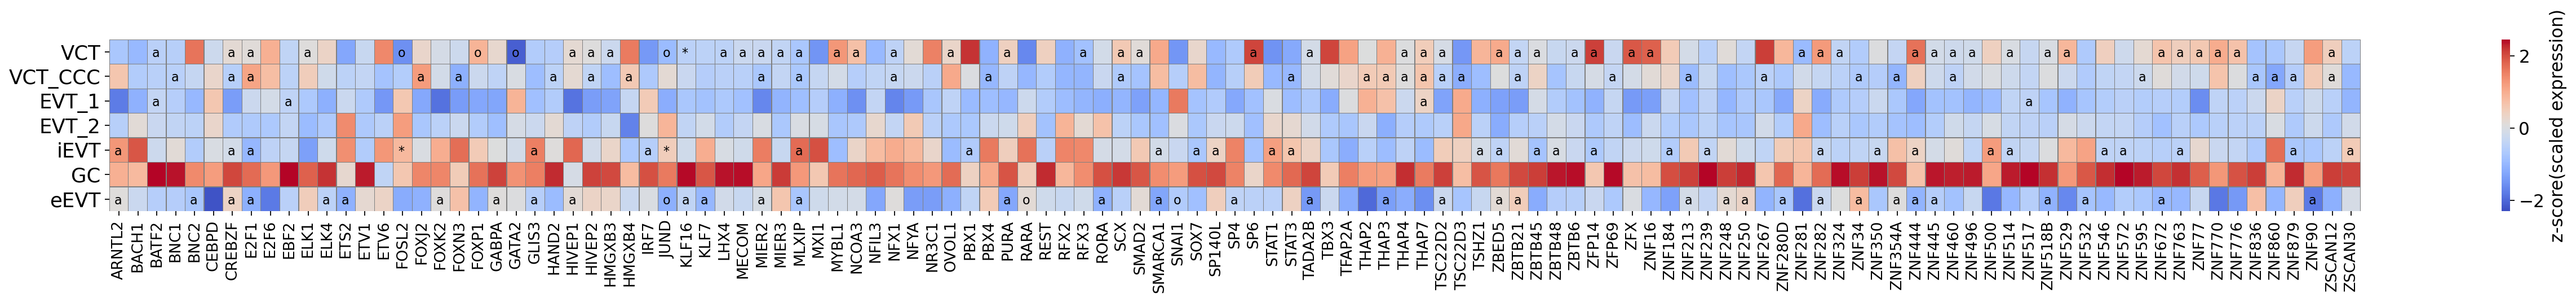

In [183]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_3_fusion'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

#plt.savefig('./figures/Fig2G/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_with_annotation_ALL.pdf', bbox_inches='tight')

plt.show()


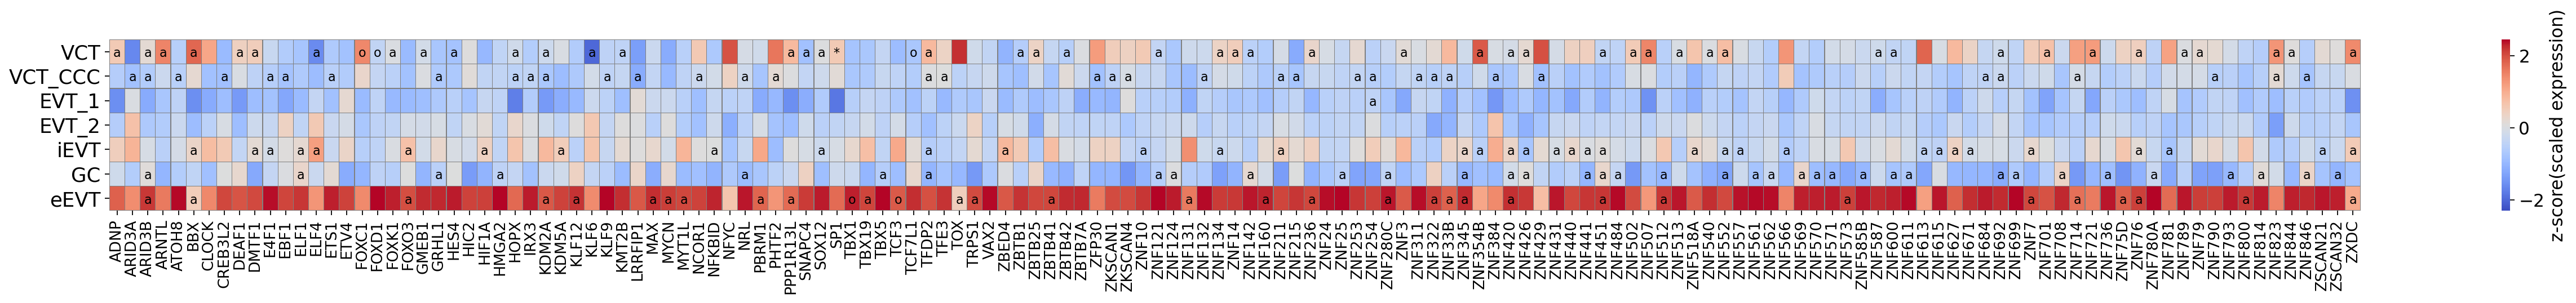

In [184]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_4_artery_remodelling'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

#plt.savefig('./figures/Fig2G/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_with_annotation_ALL.pdf', bbox_inches='tight')

plt.show()


# for the final figure heatmap from here we can somehow (how?) select only top TFs...

In [ ]:
# older results below

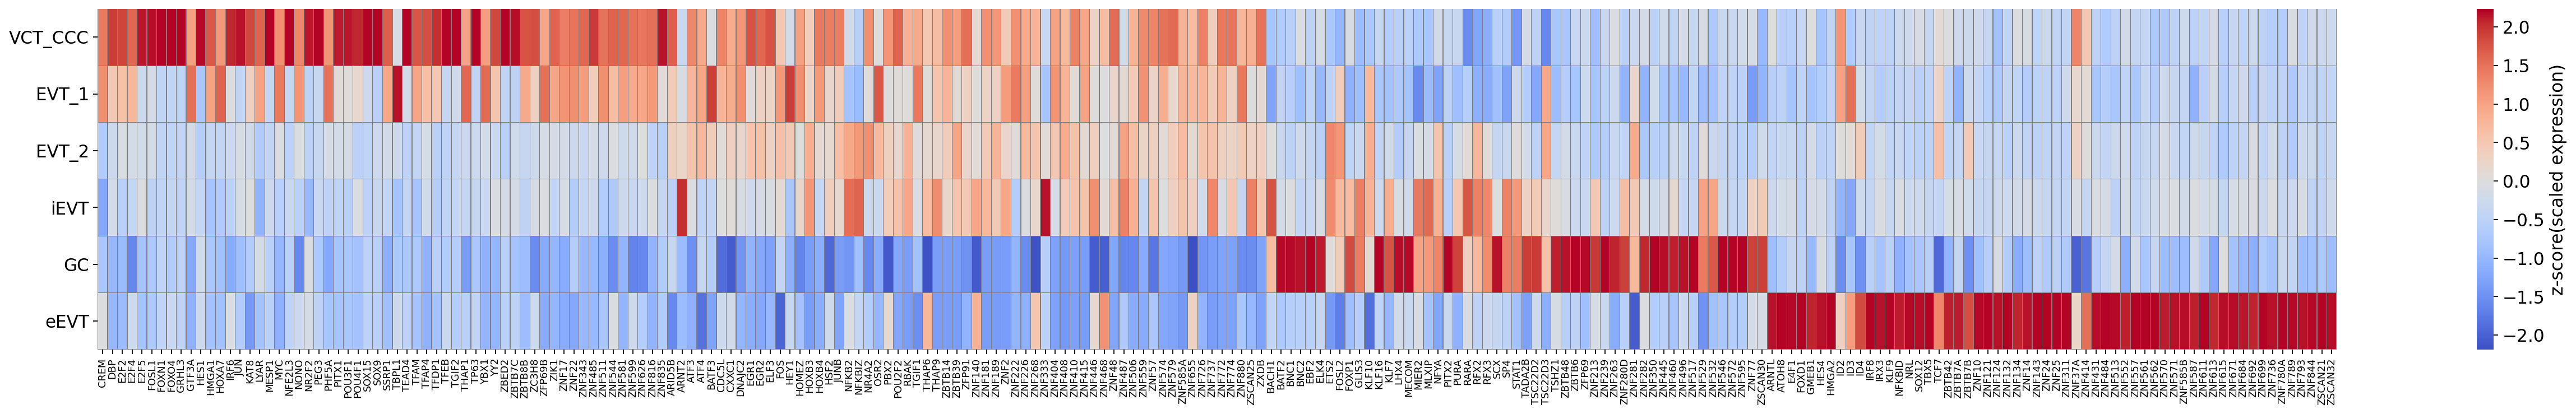

In [94]:
# all 4 MEs plotted together

plt.figure(figsize=(40,5))

sns.heatmap(df_avg_expr_zscores.loc[all_TFs_final].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(all_TFs_final) + 0.5, 1)
plt.xticks(x, fontsize=8, labels = all_TFs_final)

# already saved
#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

plt.show()

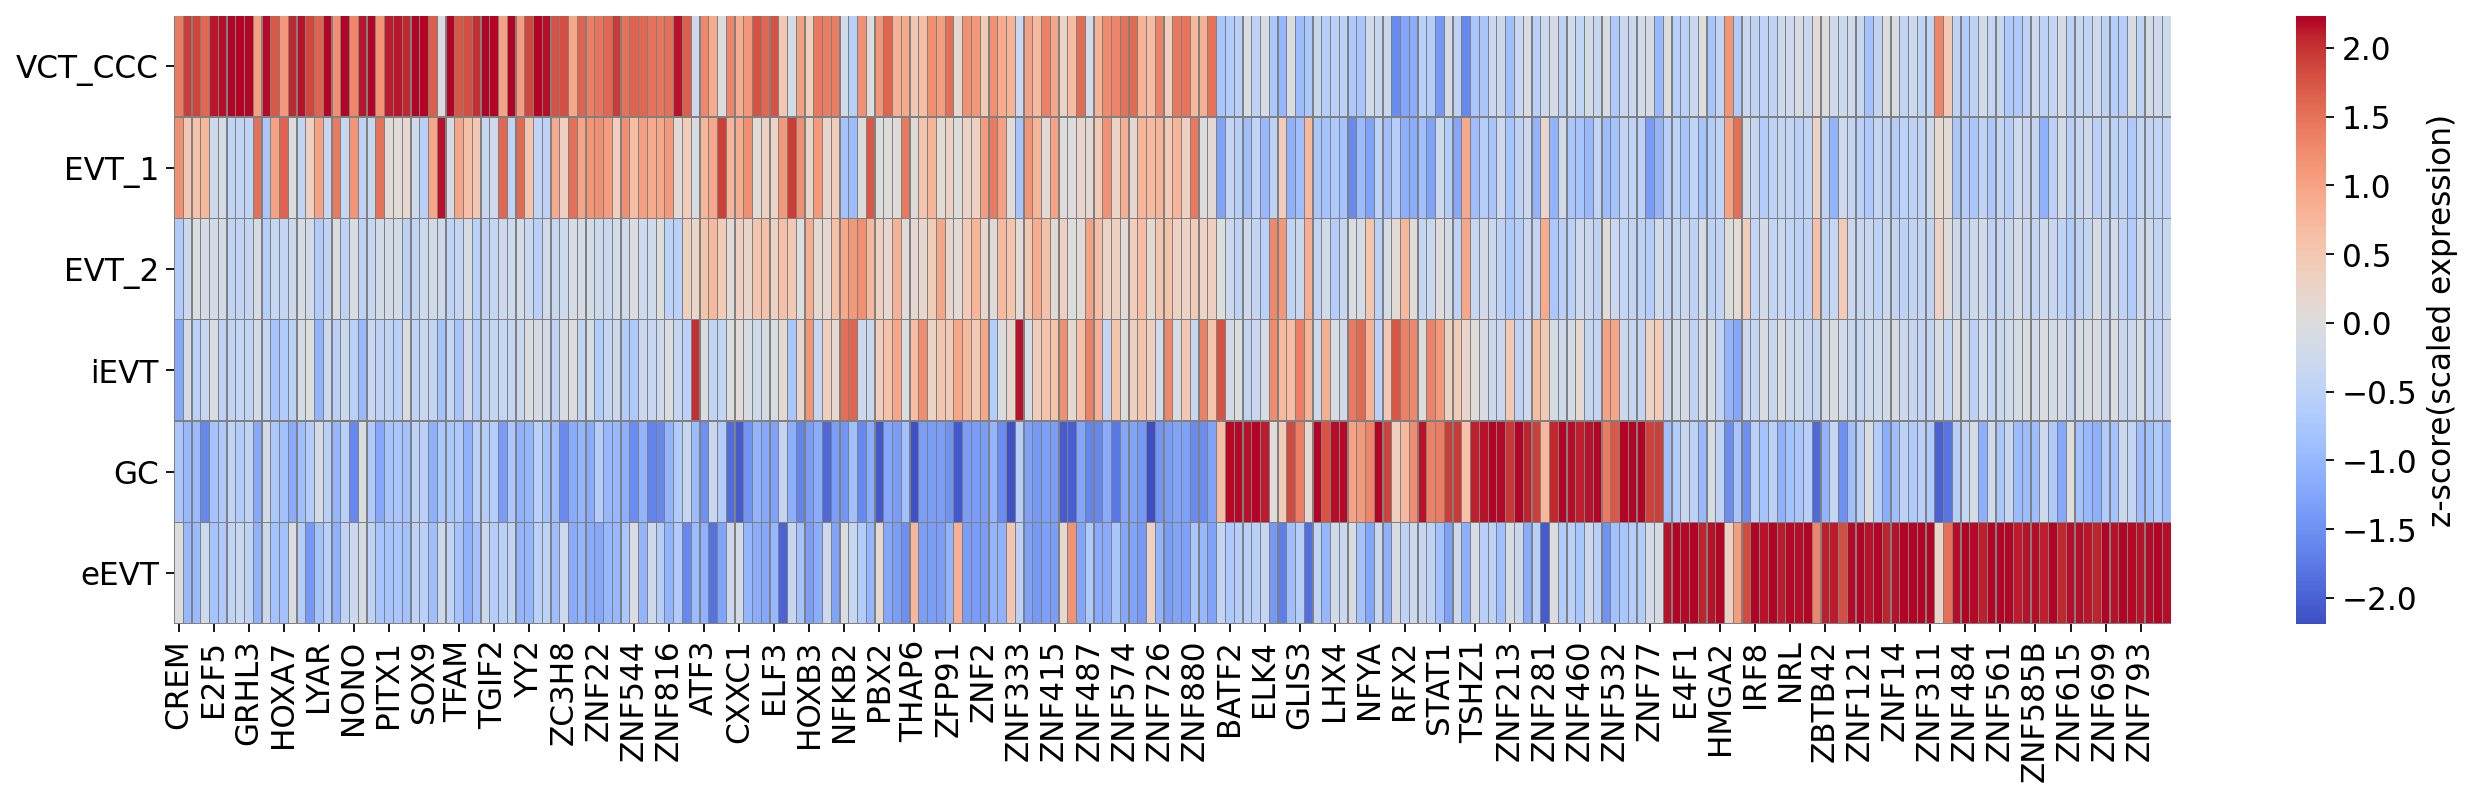

In [96]:
# all 4 MEs plotted together - prliminary for now, just to show the pattern

plt.figure(figsize=(20,5))

sns.heatmap(df_avg_expr_zscores.loc[all_TFs_final].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(all_TFs_final) + 0.5, 1)
#plt.xticks(x, fontsize=8, labels = all_TFs_final)

# already saved
plt.savefig('./figures/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

plt.show()

# make a list of correspondence of TFs to which factor they come up in in MEFISTO (will color code)

## and add annotations (*, a, o) onto either this plot or square

In [73]:
[TF for TF in all_TFs_final if 'GATA' in TF]

[]

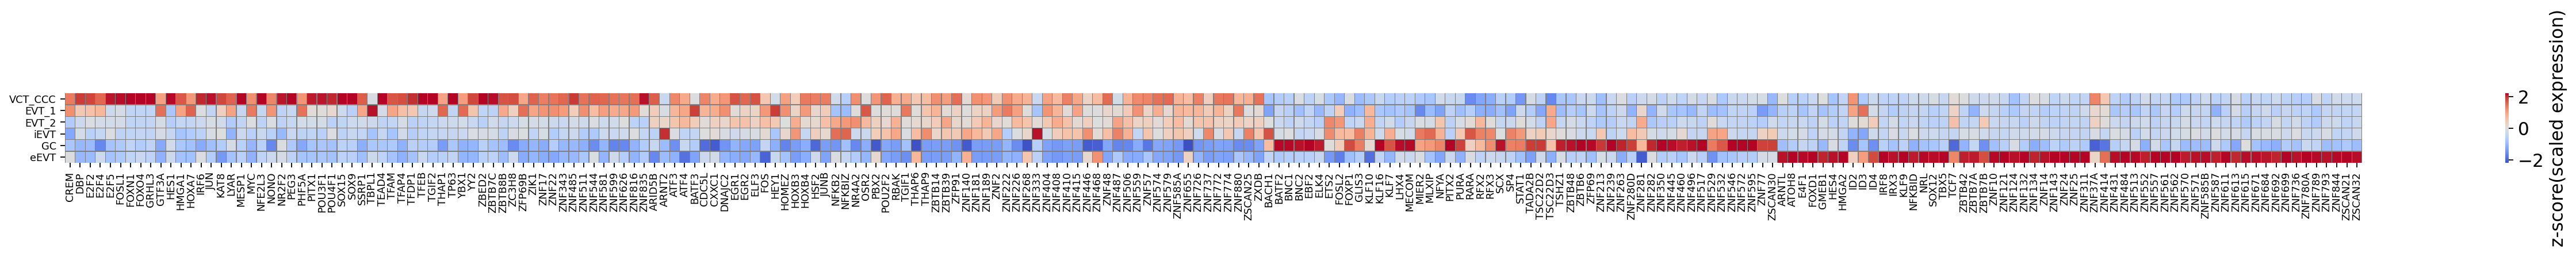

In [74]:
# playing a bit with the plotting here

# all 4 MEs plotted together

plt.figure(figsize=(40,1))

sns.heatmap(df_avg_expr_zscores.loc[all_TFs_final].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(all_TFs_final) + 0.5, 1)
plt.xticks(x, fontsize=8, labels = all_TFs_final)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=8, labels = df_avg_expr_zscores.columns)


plt.show()

#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

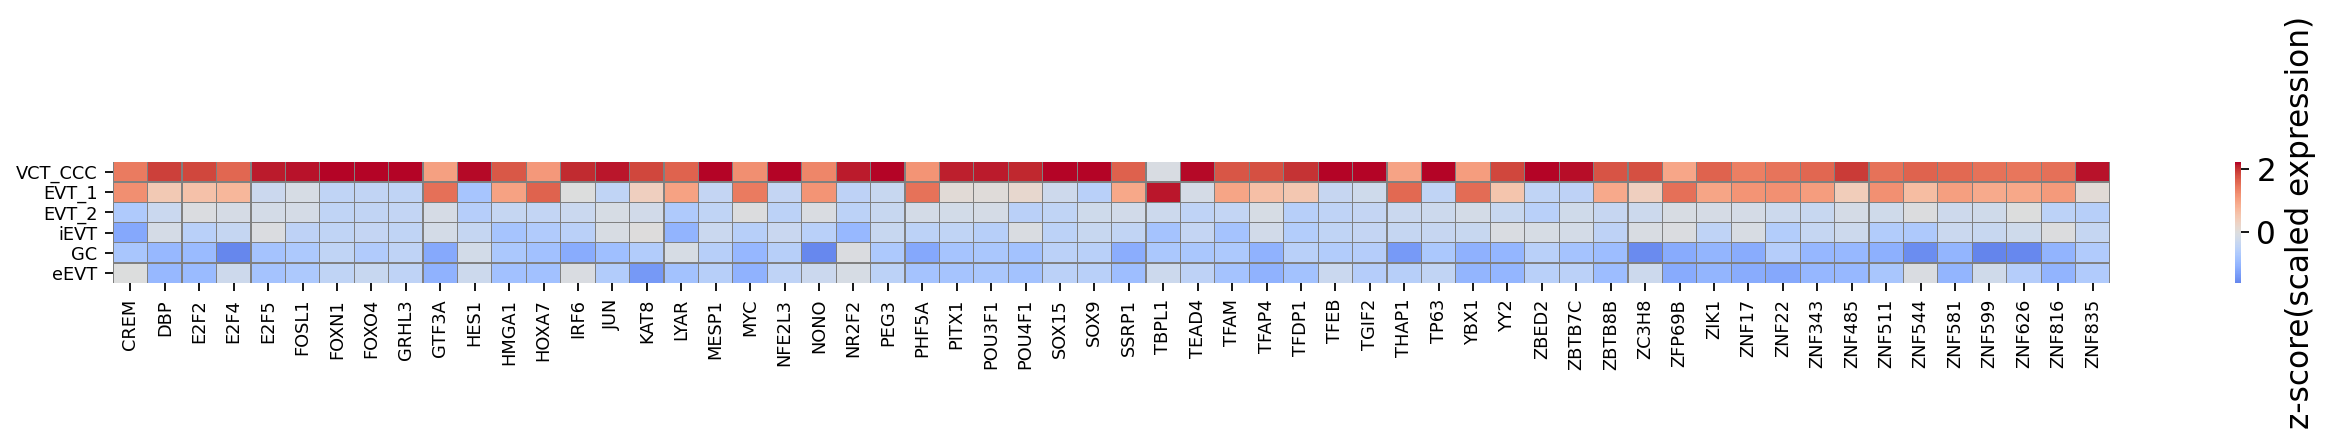

In [121]:
# playing a bit with the plotting here

# ME 1

TFs2plot = sorted(MEs_TFs['ME_1_early_inv_column'])

plt.figure(figsize=(20,1))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=8, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=8, labels = df_avg_expr_zscores.columns)


plt.show()

#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

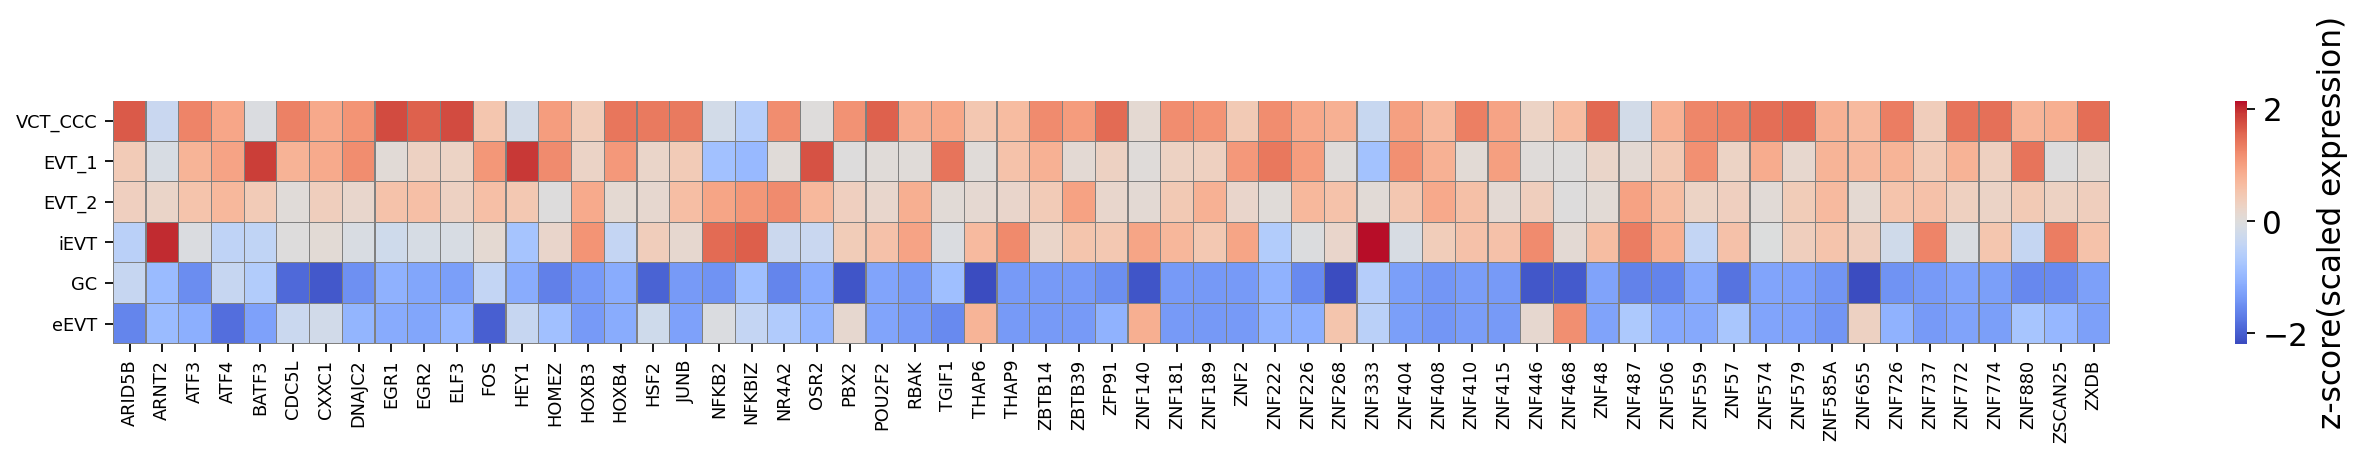

In [122]:
# playing a bit with the plotting here

# ME 2

TFs2plot = sorted(MEs_TFs['ME_2_inv_front'])

plt.figure(figsize=(20,2))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=8, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=8, labels = df_avg_expr_zscores.columns)


plt.show()

#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

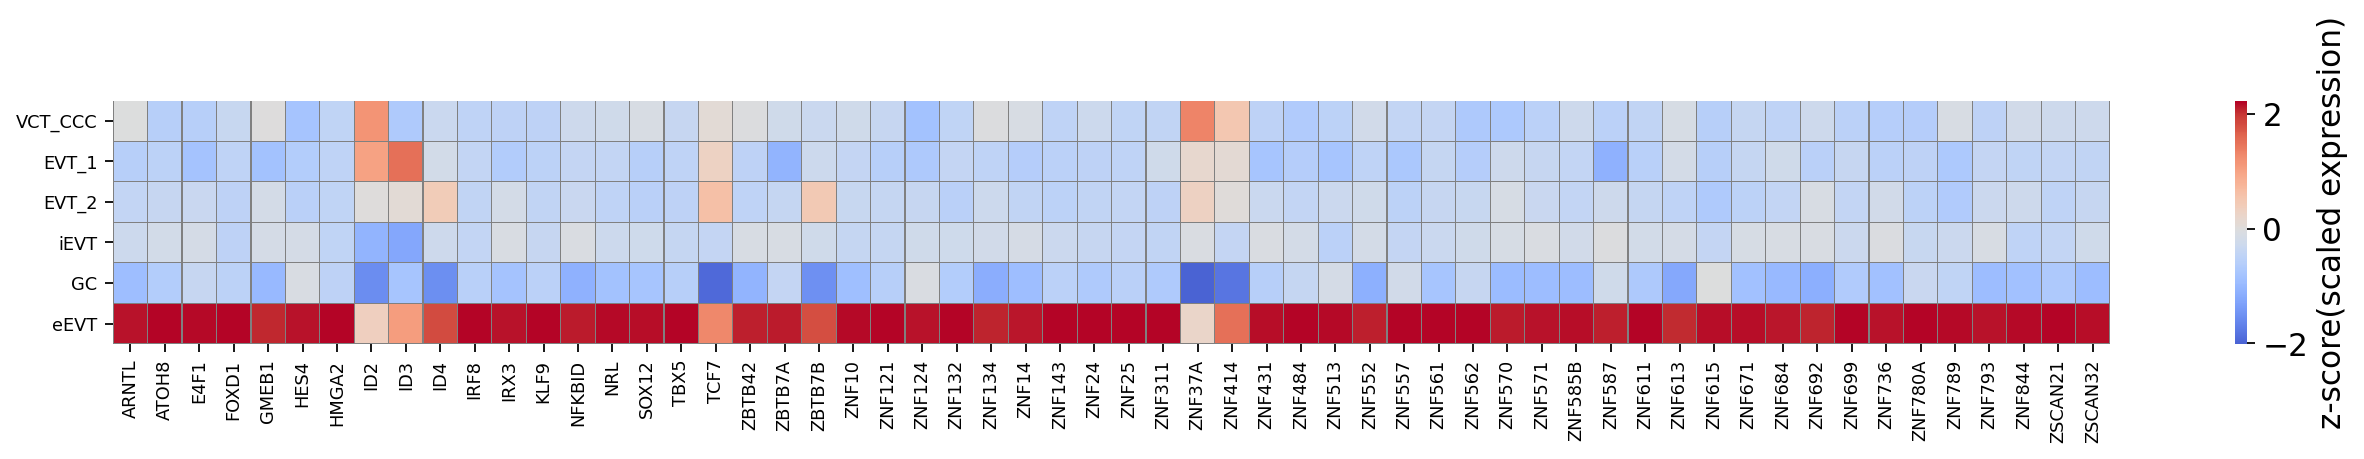

In [123]:
# playing a bit with the plotting here

# ME 3

TFs2plot = sorted(MEs_TFs['ME_3_artery_remodelling'])

plt.figure(figsize=(20,2))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=8, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=8, labels = df_avg_expr_zscores.columns)


plt.show()

#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

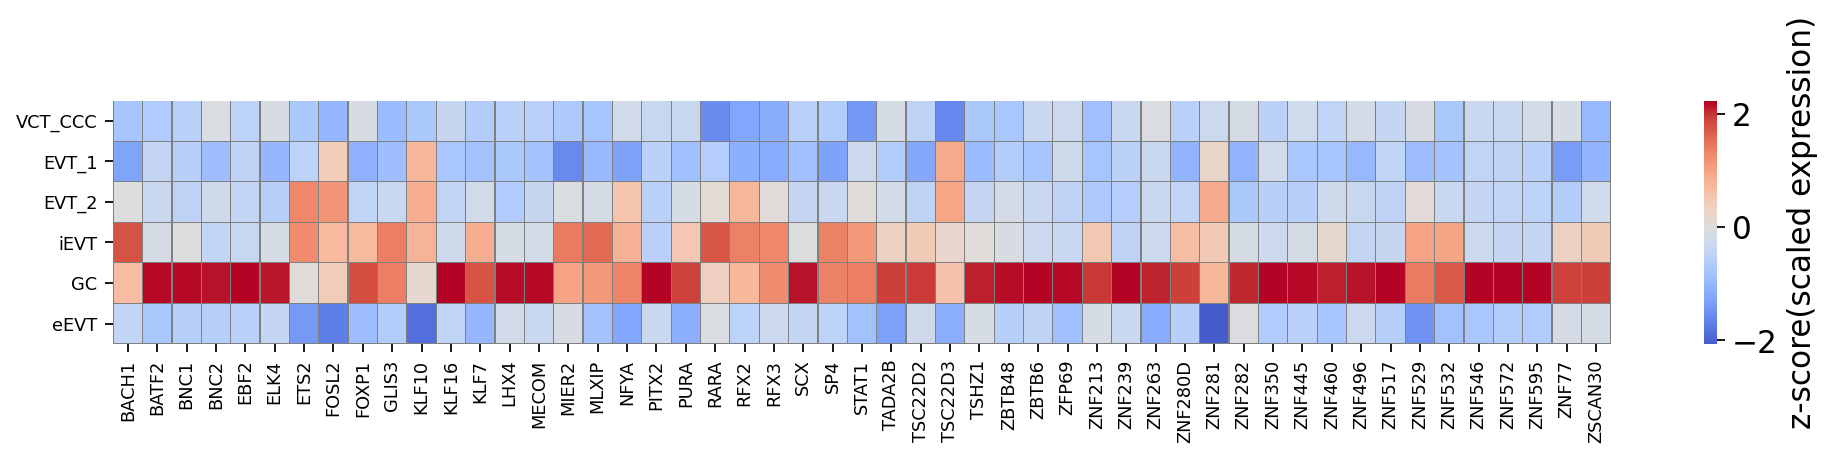

In [125]:
# playing a bit with the plotting here

# ME 4

TFs2plot = sorted(MEs_TFs['ME_4_fusion'])

plt.figure(figsize=(15,2))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=8, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=8, labels = df_avg_expr_zscores.columns)


plt.show()

#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

In [75]:
# simplifying this to mimic Luz&Valentina's code, will add MEFISTO-layer evidence later

df_TFs_evidence_per_ME = {}

# which comparisons was the TF prioritised through? and what was the sign (upreg or downreg)?
comparisons_per_TF = {}

# which comparisons was the TF prioritised through?
evidences_per_TF = {}

for ME in MEs:
    print(ME)
    df_TFs_evidence_per_ME[ME] = pd.DataFrame(index = MEs_TFs[ME],
                                         columns = list(df_avg_expr_zscores.columns))
    
    for TF in df_TFs_evidence_per_ME[ME].index:
        for comparison in comparisons:
            if TF in TFs_upregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_upreg'
                sign = '+'
                evidences_per_TF[TF] = list(TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']][TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison.split('_vs_')[0] # cell type position in heatmap
                
                if evidences_per_TF[TF] == ['is_DA_dorothea']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                #elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                    
            
            elif TF in TFs_downregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_downreg'
                sign = '-'
                evidences_per_TF[TF] = list(TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']][TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison.split('_vs_')[0] # cell type position in heatmap
                
                if evidences_per_TF[TF] == ['is_DA_dorothea']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                #elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                

ME_1_early_inv_column
ME_2_inv_front
ME_3_artery_remodelling
ME_4_fusion


In [81]:
df_TFs_evidence_per_ME['ME_1_early_inv_column']

VCT_CCC EVT_1 EVT_2 iEVT   GC eEVT
SOX15      NaN     a   NaN  NaN  NaN  NaN
ZNF343     NaN     a   NaN  NaN  NaN  NaN
E2F5       NaN     a   NaN  NaN  NaN  NaN
SSRP1      NaN     a     a  NaN  NaN  NaN
GTF3A        a     a     a    a  NaN  NaN
FOSL1        o     o   NaN  NaN  NaN  NaN
SOX9       NaN   NaN   NaN  NaN  NaN  NaN
FOXO4      NaN   NaN   NaN  NaN  NaN  NaN
ZNF544     NaN     a   NaN  NaN  NaN  NaN
HES1       NaN   NaN   NaN  NaN  NaN  NaN
CREM       NaN   NaN   NaN  NaN  NaN  NaN
ZNF511     NaN     a     a  NaN  NaN  NaN
TBPL1      NaN     a     a  NaN  NaN  NaN
E2F4       NaN   NaN     a  NaN  NaN  NaN
NR2F2      NaN     o   NaN  NaN  NaN  NaN
THAP1      NaN     o   NaN  NaN  NaN  NaN
ZNF485     NaN     a   NaN  NaN  NaN  NaN
ZNF581       a   NaN     a    a  NaN  NaN
NONO       NaN     a   NaN  NaN  NaN  NaN
PITX1      NaN   NaN   NaN  NaN  NaN  NaN
MESP1        a     a   NaN  NaN  NaN  NaN
PHF5A        a   NaN     a  NaN  NaN  NaN
TFEB       NaN     a   NaN  NaN  NaN  NaN
ZNF835     NaN     a   NaN  NaN  NaN  NaN
ZFP69B       a   NaN   NaN  NaN  NaN  NaN
ZNF17        a   NaN   NaN  NaN  NaN  NaN
KAT8       NaN     a   NaN  NaN  NaN  NaN
ZBED2        a     a   NaN  NaN  NaN  NaN
ZNF22      NaN   NaN     a  NaN  NaN  NaN
YBX1       NaN   NaN   NaN    a  NaN  NaN
POU4F1     NaN   NaN   NaN  NaN  NaN  NaN
TFDP1      NaN     o     *  NaN  NaN  NaN
ZC3H8      NaN   NaN     a  NaN  NaN  NaN
TEAD4      NaN   NaN   NaN  NaN  NaN  NaN
TFAP4        a     a   NaN  NaN  NaN  NaN
ZIK1         a   NaN   NaN  NaN  NaN  NaN
JUN        NaN   NaN     a  NaN  NaN  NaN
LYAR         a     a     a  NaN  NaN  NaN
ZNF626     NaN     a   NaN  NaN  NaN  NaN
MYC          a   NaN     a  NaN  NaN  NaN
TGIF2      NaN   NaN   NaN  NaN  NaN  NaN
ZBTB7C     NaN     a   NaN  NaN  NaN  NaN
POU3F1     NaN     a   NaN  NaN  NaN  NaN
TFAM       NaN     a     a  NaN  NaN  NaN
ZBTB8B     NaN     a   NaN  NaN  NaN  NaN
E2F2         a   NaN     a    a  NaN  NaN
PEG3         a     a     a  NaN  NaN  NaN
TP63       NaN     o   NaN  NaN  NaN  NaN
FOXN1      NaN     a   NaN  NaN  NaN  NaN
DBP        NaN     a   NaN  NaN  NaN  NaN
YY2        NaN   NaN   NaN  NaN  NaN  NaN
HOXA7      NaN   NaN     a  NaN  NaN  NaN
IRF6       NaN     a   NaN  NaN  NaN  NaN
ZNF599       a     a   NaN  NaN  NaN  NaN
ZNF816       a     a   NaN    a  NaN  NaN
NFE2L3     NaN     a   NaN  NaN  NaN  NaN
HMGA1      NaN   NaN   NaN    a  NaN  NaN
GRHL3        a     a   NaN  NaN  NaN  NaN

In [83]:
# here for all MEs together
df_TFs_evidence_all = pd.concat([df_TFs_evidence_per_ME['ME_1_early_inv_column'], df_TFs_evidence_per_ME['ME_2_inv_front'],
                                df_TFs_evidence_per_ME['ME_4_fusion'], df_TFs_evidence_per_ME['ME_3_artery_remodelling']])
df_TFs_evidence_all = df_TFs_evidence_all.loc[all_TFs_final]

In [84]:
df_TFs_evidence_all

VCT_CCC EVT_1 EVT_2 iEVT   GC eEVT
CREM        NaN   NaN   NaN  NaN  NaN  NaN
DBP         NaN     a   NaN  NaN  NaN  NaN
E2F2          a   NaN     a    a  NaN  NaN
E2F4        NaN   NaN     a  NaN  NaN  NaN
E2F5        NaN     a   NaN  NaN  NaN  NaN
...         ...   ...   ...  ...  ...  ...
ZNF789      NaN     a   NaN  NaN  NaN  NaN
ZNF793      NaN   NaN   NaN  NaN  NaN    a
ZNF844      NaN     a   NaN  NaN  NaN  NaN
ZSCAN21       a   NaN   NaN  NaN  NaN  NaN
ZSCAN32     NaN   NaN   NaN  NaN  NaN    a

[228 rows x 6 columns]

In [85]:
# here for all MEs together
coords_annotation_all = []

curr_df = df_TFs_evidence_all

for TF in curr_df.index:
    #print(TF)
    x_shift = 0.25 # should be consistent for all 4 heatmaps (per ME)
    curr_coord_x = x_shift + list(curr_df.index).index(TF) # x coordinate of TF
    #print(curr_coord_x)

    for ct in curr_df.columns:
        if str(curr_df.loc[TF,ct]) != 'nan':
            #print(TF, ct)
            y_shift = 0.7 # is different for different heatmaps (per ME)?
            curr_coord_y = y_shift + list(curr_df.columns).index(ct) # y coordinate of cell type
            coords_annotation_all.append([(curr_coord_x, curr_coord_y), curr_df.loc[TF,ct]])


In [86]:
# common color limits for all 4 heatmaps
common_max = np.max(df_avg_expr_zscores.values)
common_min = np.min(df_avg_expr_zscores.values)
common_min

-2.1875007321112037

In [87]:
df_avg_expr_zscores

VCT_CCC     EVT_1     EVT_2      iEVT        GC      eEVT
BNC1   -0.550439 -0.568399 -0.480327 -0.010893  2.191925 -0.581867
ATOH8  -0.565360 -0.496028 -0.353160 -0.179350 -0.618534  2.212431
ZNF175  1.864023 -0.450103  0.179333  0.428541 -1.188654 -0.833139
ZNF277 -1.100397 -0.716307 -0.669661  0.249708  0.323372  1.913286
ZNF2    0.440744  1.084728  0.216151  0.962466 -1.352044 -1.352044
...          ...       ...       ...       ...       ...       ...
SP3    -0.433834 -0.923697 -0.100528  1.331224 -1.195206  1.322040
ETV4   -0.734522  0.091441 -0.212403  0.196153 -1.275197  1.934528
GRHL3   2.235414 -0.455408 -0.400814 -0.436377 -0.471408 -0.471408
ZC3H6  -0.547830 -1.370915 -0.867816  0.385577  1.065700  1.335284
BATF2  -0.646698 -0.400616 -0.313624 -0.126177  2.192911 -0.705796

[668 rows x 6 columns]

In [88]:
# to enable adobe illustrator to recognise the text as editable text object
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


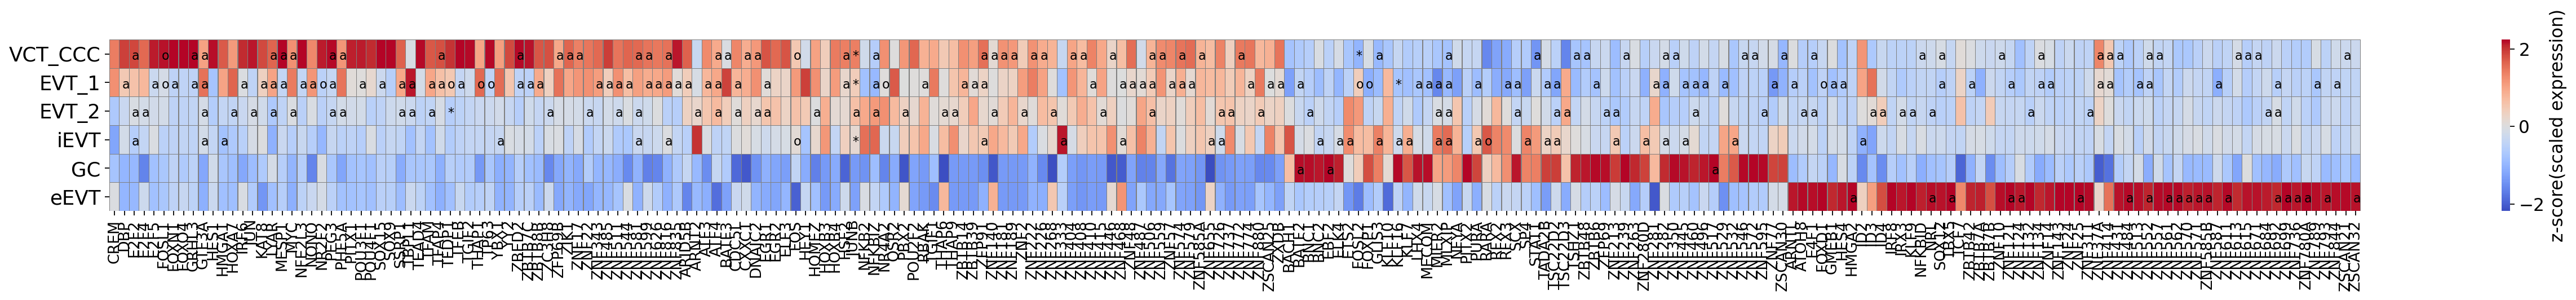

In [92]:
# playing a bit with the plotting here

# all MEs?

#curr_ME = 'ME_1_early_inv_column'

TFs2plot = all_TFs_final

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_all)):
    plt.annotate(coords_annotation_all[i][1], coords_annotation_all[i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_with_annotation_ALL.pdf', bbox_inches='tight')

plt.show()


In [126]:
df_TFs_evidence_per_ME = {}

# which comparisons was the TF prioritised through? and what was the sign (upreg or downreg)?
comparisons_per_TF = {}

# which comparisons was the TF prioritised through?
evidences_per_TF = {}

for ME in MEs:
    print(ME)
    df_TFs_evidence_per_ME[ME] = pd.DataFrame(index = MEs_TFs[ME],
                                         columns = list(df_avg_expr_zscores.columns))
    
    for TF in df_TFs_evidence_per_ME[ME].index:
        for comparison in comparisons:
            if TF in TFs_upregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_upreg'
                sign = '+'
                evidences_per_TF[TF] = list(TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']][TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison.split('_vs_')[0] # cell type position in heatmap
                
                if evidences_per_TF[TF] == ['is_DA_dorothea']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'D' + sign
                elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'C' + sign
                elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M' + sign
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'DM' + sign
                elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'CM' + sign
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'DC' + sign
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'DCM' + sign
                    
            
            elif TF in TFs_downregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_downreg'
                sign = '-'
                evidences_per_TF[TF] = list(TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']][TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison.split('_vs_')[0] # cell type position in heatmap
                
                if evidences_per_TF[TF] == ['is_DA_dorothea']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'D' + sign
                elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'C' + sign
                elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M' + sign
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'DM' + sign
                elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'CM' + sign
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'DC' + sign
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'DCM' + sign
                

ME_1_early_inv_column
ME_2_inv_front
ME_3_artery_remodelling
ME_4_fusion


In [127]:
comparisons_per_TF['THAP1']

'EVT_1_vs_VCT_CCC_upreg'

In [128]:
evidences_per_TF['THAP1']

['is_DA_chromVar', 'is_DA_MEFISTO']

In [129]:
evidences_per_TF_str = [str(elem) for elem in list(evidences_per_TF.values())]
np.unique(evidences_per_TF_str)
#evidences_per_TF_str

array(["['is_DA_MEFISTO']", "['is_DA_chromVar', 'is_DA_MEFISTO']",
       "['is_DA_chromVar']", "['is_DA_dorothea', 'is_DA_MEFISTO']",
       "['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']",
       "['is_DA_dorothea', 'is_DA_chromVar']", "['is_DA_dorothea']"],
      dtype='<U53')

In [130]:
# encoding:
# ['is_DA_MEFISTO'] --> M - deg + factor-explaining --> 
# ['is_DA_chromVar'] --> C - deg + open
# ['is_DA_dorothea'] --> D - deg + active

# ['is_DA_chromVar', 'is_DA_MEFISTO'] --> CM
# ['is_DA_dorothea', 'is_DA_MEFISTO'] --> DM

# the following ones are not present in our results but just for general code workability let's add them
# ['is_DA_dorothea', 'is_DA_chromVar'] --> DC
# ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO'] --> DCM


In [131]:
TFs_upregulated_per_comparison_both_DA_and_DE['EVT_1_vs_VCT_CCC'].loc['THAP1']

Avg_expr             0.102416
is_DE_limma               yes
is_DA_dorothea             no
is_DA_chromVar            yes
is_DA_MEFISTO             yes
is_DE_and_DA              yes
cluster                 EVT_1
ID                EVT_1_THAP1
Name: THAP1, dtype: object

In [132]:
df_TFs_evidence_per_ME['ME_1_early_inv_column']

VCT_CCC EVT_1 EVT_2 iEVT   GC eEVT
SOX15      NaN    D-   NaN  NaN  NaN  NaN
ZNF343     NaN    D-   NaN  NaN  NaN  NaN
E2F5       NaN    D-   NaN  NaN  NaN  NaN
SSRP1      NaN    D-    D-  NaN  NaN  NaN
GTF3A       D+    D+    D-   D+  NaN  NaN
FOSL1       C+   CM-   NaN   M-  NaN  NaN
SOX9        M+   NaN   NaN  NaN  NaN  NaN
FOXO4       M-   NaN   NaN  NaN  NaN  NaN
ZNF544     NaN    D-   NaN  NaN  NaN  NaN
HES1       NaN    M-   NaN  NaN  NaN  NaN
CREM        M-   NaN    M-   M-  NaN  NaN
ZNF511     NaN    D-    D-  NaN  NaN  NaN
TBPL1      NaN    D+    D-  NaN  NaN  NaN
E2F4        M-    M-   DM-  NaN  NaN  NaN
NR2F2      NaN    C-   NaN  NaN  NaN  NaN
THAP1      NaN   CM+   NaN  NaN  NaN  NaN
ZNF485     NaN    D-   NaN  NaN  NaN  NaN
ZNF581      D+   NaN    D-   D+  NaN  NaN
NONO       NaN    D-   NaN  NaN  NaN  NaN
PITX1      NaN    M-   NaN  NaN  NaN  NaN
MESP1       D-    D-   NaN  NaN  NaN  NaN
PHF5A       D+   NaN    D-  NaN  NaN  NaN
TFEB       NaN    D-   NaN  NaN  NaN  NaN
ZNF835     NaN    D-   NaN  NaN  NaN  NaN
ZFP69B      D+   NaN   NaN  NaN  NaN  NaN
ZNF17       D-   NaN   NaN  NaN  NaN  NaN
KAT8       NaN    D-   NaN  NaN  NaN  NaN
ZBED2       D+    D-   NaN  NaN  NaN  NaN
ZNF22      NaN   NaN    D-  NaN  NaN  NaN
YBX1       NaN   NaN   NaN   D+  NaN  NaN
POU4F1     NaN    M-   NaN  NaN  NaN  NaN
TFDP1      NaN   CM-  DCM-  NaN  NaN  NaN
ZC3H8      NaN   NaN    D-  NaN  NaN  NaN
TEAD4      NaN    M-    M-  NaN  NaN  NaN
TFAP4       D+    D-   NaN  NaN  NaN  NaN
ZIK1        D-   NaN   NaN  NaN  NaN  NaN
JUN         M-    M-    D+  NaN  NaN  NaN
LYAR        D+    D-    D-  NaN  NaN  NaN
ZNF626     NaN    D-   NaN  NaN  NaN  NaN
MYC        DM+   NaN    D-  NaN  NaN  NaN
TGIF2      NaN    M-   NaN  NaN  NaN  NaN
ZBTB7C      M-   DM-   NaN  NaN  NaN  NaN
POU3F1     NaN   DM-   NaN  NaN  NaN  NaN
TFAM       NaN    D-    D-  NaN  NaN  NaN
ZBTB8B     NaN    D-   NaN  NaN  NaN  NaN
E2F2       DM+   NaN    D-   D-  NaN  NaN
PEG3        D-    D-    D+  NaN  NaN  NaN
TP63       NaN    C-   NaN  NaN  NaN  NaN
FOXN1      NaN    D-   NaN  NaN  NaN  NaN
DBP         M-   DM-   NaN  NaN  NaN  NaN
YY2        NaN    M-   NaN  NaN  NaN  NaN
HOXA7      NaN   NaN    D-  NaN  NaN  NaN
IRF6       NaN    D-   NaN  NaN  NaN  NaN
ZNF599      D-    D-   NaN  NaN  NaN  NaN
ZNF816      D-    D-   NaN   D+  NaN  NaN
NFE2L3     NaN    D-   NaN  NaN  NaN  NaN
HMGA1      NaN   NaN   NaN   D-  NaN  NaN
GRHL3       D+    D-   NaN  NaN  NaN  NaN

In [133]:
coords_annotation_per_ME = {}

for ME in MEs:
    print(ME)
    curr_df = df_TFs_evidence_per_ME[ME].loc[sorted(MEs_TFs[ME])]

    # coordinates where we want to add text annotation + annotation
    # [(float,float), str]
    coords_annotation_per_ME[ME] = []

    for TF in curr_df.index:
        #print(TF)
        x_shift = 0.25 # should be consistent for all 4 heatmaps (per ME)
        curr_coord_x = x_shift + list(curr_df.index).index(TF) # x coordinate of TF
        #print(curr_coord_x)

        for ct in curr_df.columns:
            if str(curr_df.loc[TF,ct]) != 'nan':
                #print(TF, ct)
                y_shift = 0.7 # is different for different heatmaps (per ME)?
                curr_coord_y = y_shift + list(curr_df.columns).index(ct) # y coordinate of cell type
                coords_annotation_per_ME[ME].append([(curr_coord_x, curr_coord_y), curr_df.loc[TF,ct]])


ME_1_early_inv_column
ME_2_inv_front
ME_3_artery_remodelling
ME_4_fusion


In [141]:
# common color limits for all 4 heatmaps
common_max = np.max(df_avg_expr_zscores.values)
common_min = np.min(df_avg_expr_zscores.values)
common_min

-2.1875007321112037

In [146]:
df_avg_expr_zscores

VCT_CCC     EVT_1     EVT_2      iEVT        GC      eEVT
BNC1   -0.550439 -0.568399 -0.480327 -0.010893  2.191925 -0.581867
ATOH8  -0.565360 -0.496028 -0.353160 -0.179350 -0.618534  2.212431
ZNF175  1.864023 -0.450103  0.179333  0.428541 -1.188654 -0.833139
ZNF277 -1.100397 -0.716307 -0.669661  0.249708  0.323372  1.913286
ZNF2    0.440744  1.084728  0.216151  0.962466 -1.352044 -1.352044
...          ...       ...       ...       ...       ...       ...
SP3    -0.433834 -0.923697 -0.100528  1.331224 -1.195206  1.322040
ETV4   -0.734522  0.091441 -0.212403  0.196153 -1.275197  1.934528
GRHL3   2.235414 -0.455408 -0.400814 -0.436377 -0.471408 -0.471408
ZC3H6  -0.547830 -1.370915 -0.867816  0.385577  1.065700  1.335284
BATF2  -0.646698 -0.400616 -0.313624 -0.126177  2.192911 -0.705796

[668 rows x 6 columns]

In [161]:
# to enable adobe illustrator to recognise the text as editable text object
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


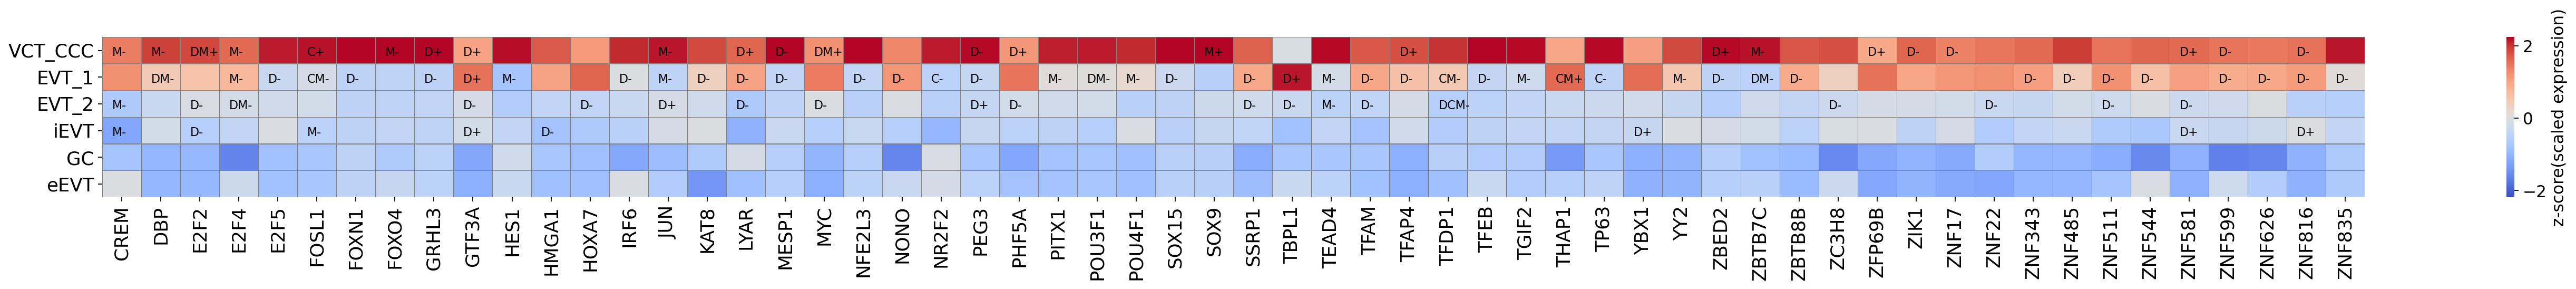

In [162]:
# playing a bit with the plotting here

# ME 1

curr_ME = 'ME_1_early_inv_column'

TFs2plot = sorted(MEs_TFs[curr_ME])

plt.figure(figsize=(43,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=16, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220203_TF_expression_heatmap_zscores_in_vivo_ME_1_early_inv_column_final_ALL.pdf', bbox_inches='tight')

plt.show()


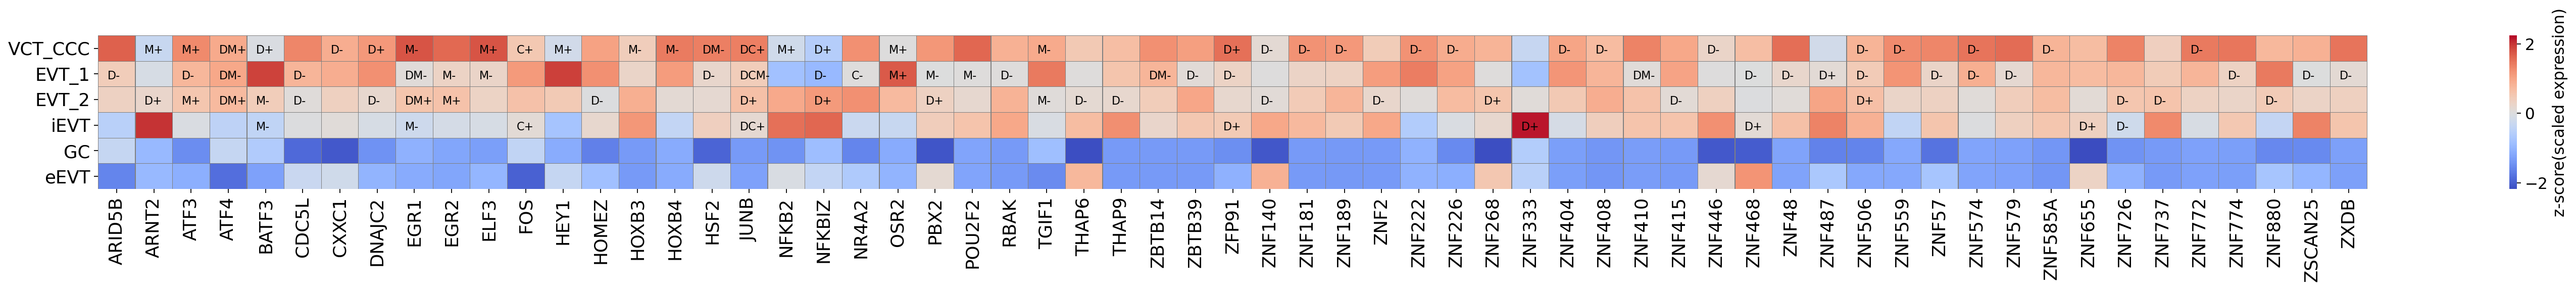

In [163]:
# playing a bit with the plotting here

# ME 2

curr_ME = 'ME_2_inv_front'

TFs2plot = sorted(MEs_TFs[curr_ME])

plt.figure(figsize=(45,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=16, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)
    
plt.savefig('./figures/Fig2G/20220203_TF_expression_heatmap_zscores_in_vivo_ME_2_inv_front_final_ALL.pdf', bbox_inches='tight')

plt.show()


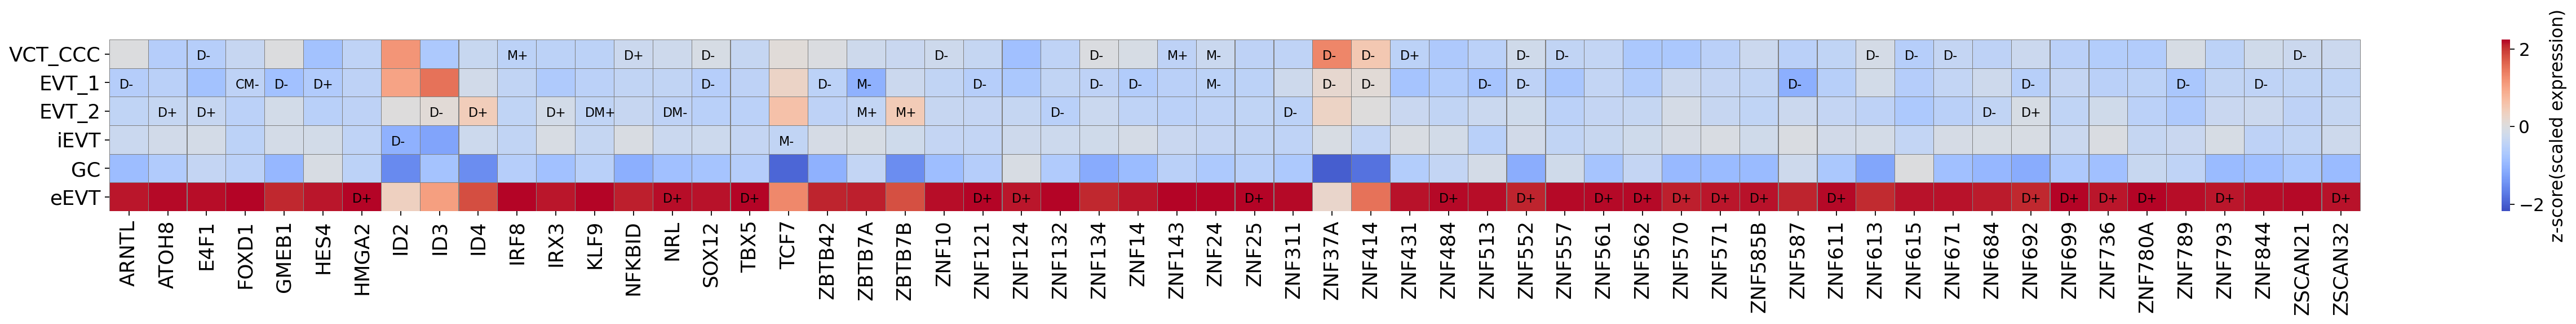

In [164]:
# playing a bit with the plotting here

# ME 3

curr_ME = 'ME_3_artery_remodelling'

TFs2plot = sorted(MEs_TFs[curr_ME])

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=16, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220203_TF_expression_heatmap_zscores_in_vivo_ME_3_artery_remodelling_final_ALL.pdf', bbox_inches='tight')

plt.show()


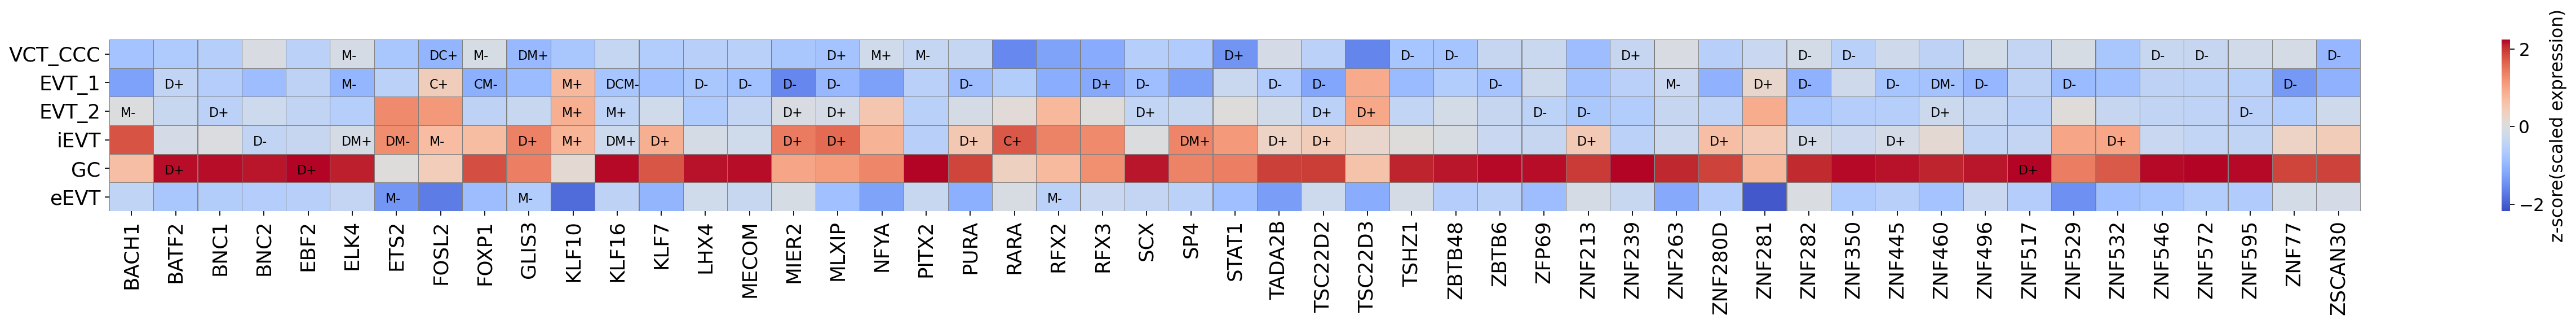

In [165]:
# playing a bit with the plotting here

# ME 4

curr_ME = 'ME_4_fusion'

TFs2plot = sorted(MEs_TFs[curr_ME])

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=16, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220203_TF_expression_heatmap_zscores_in_vivo_ME_4_fusion_final_ALL.pdf', bbox_inches='tight')

plt.show()


In [132]:
len(TFs2plot) + 0.5

101.5

<Figure size 8000x400 with 0 Axes>

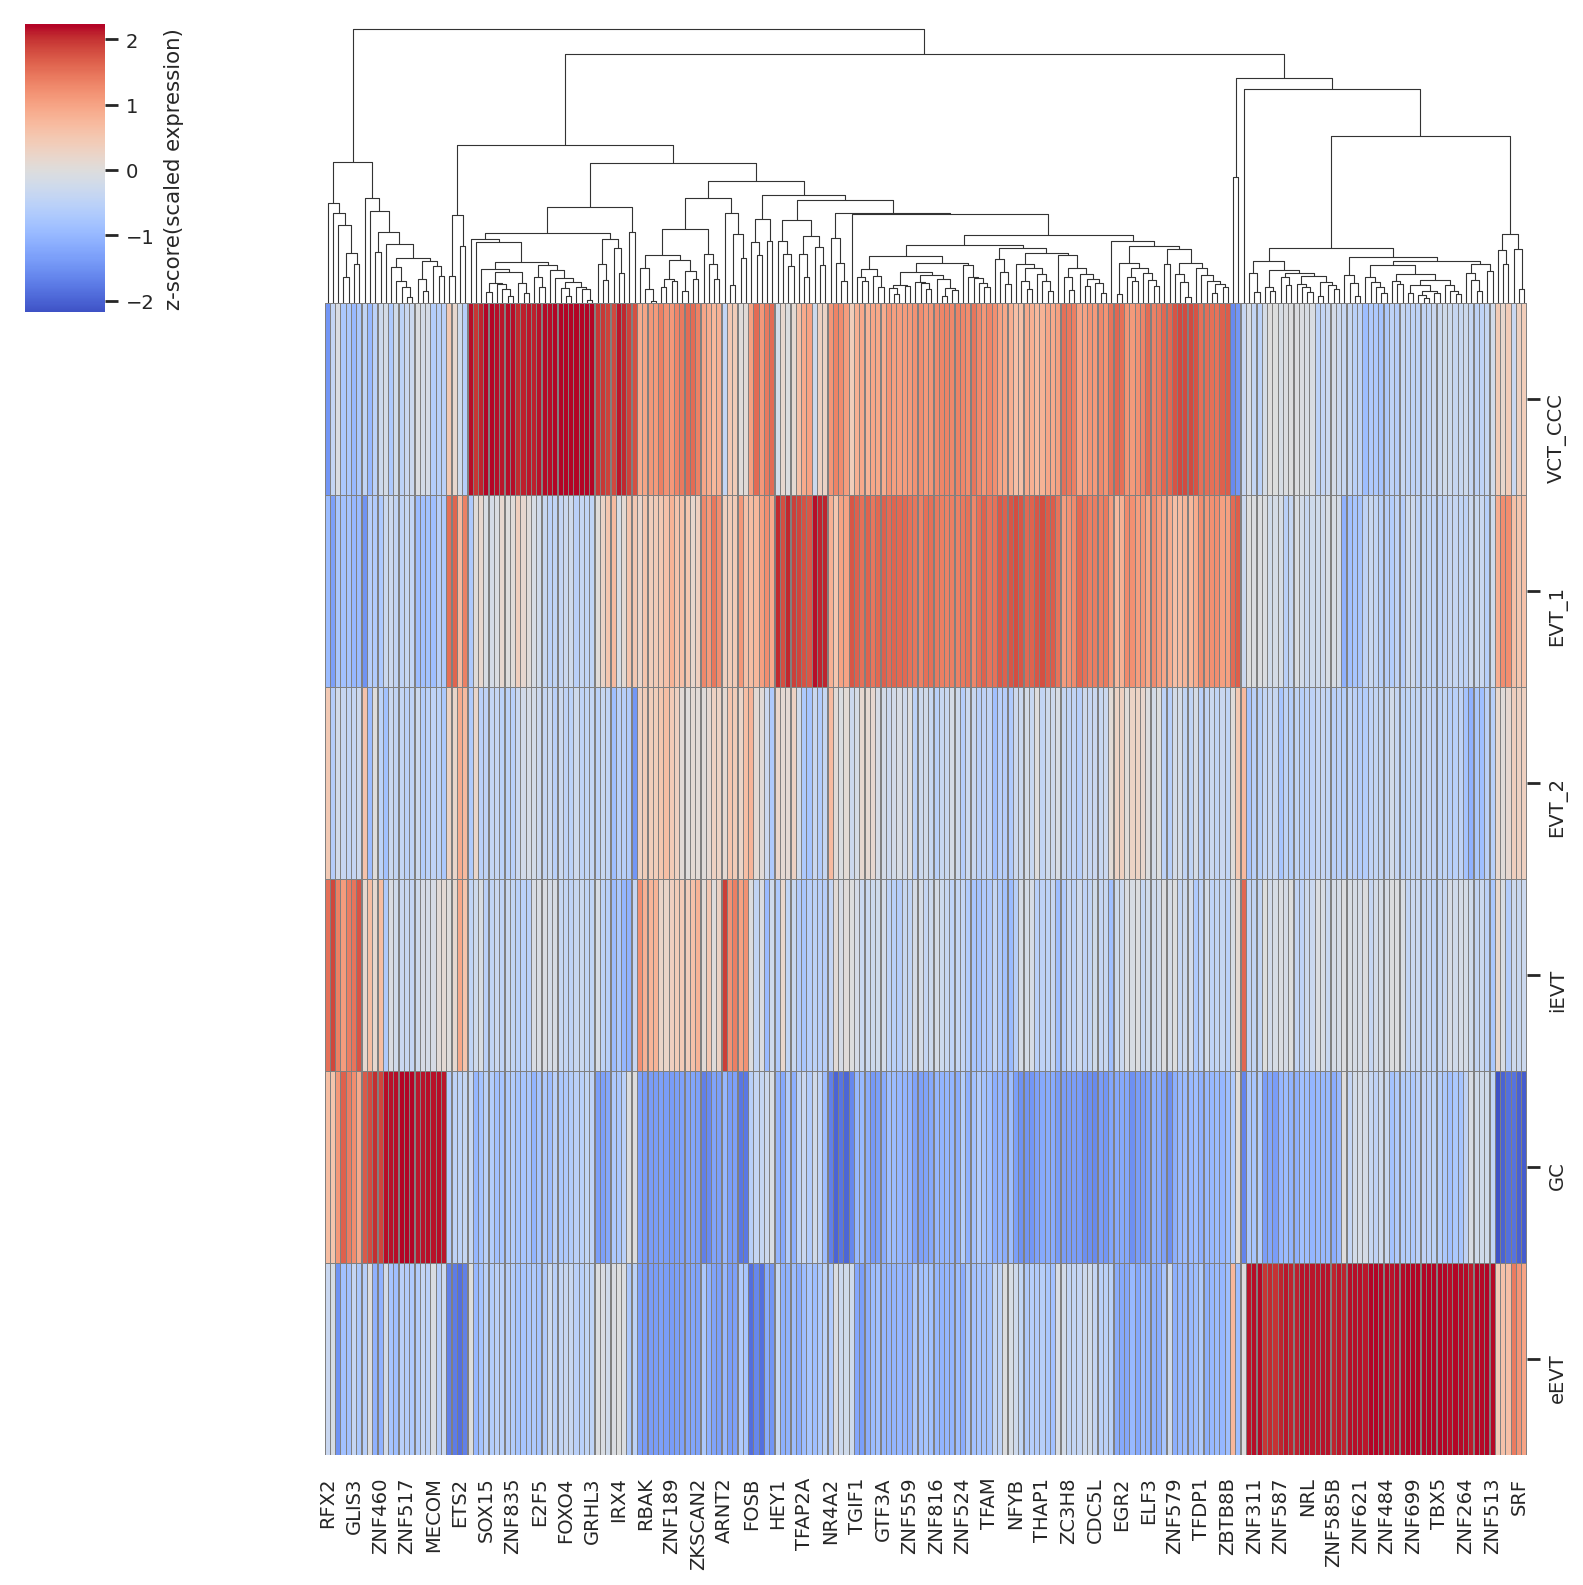

In [154]:
plt.figure(figsize=(100,5))

sns.set(font_scale=0.8)

# clusterplot for each ME

TFs2plot = sorted(all_TFs_final)

sns.clustermap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
               row_cluster=False,
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
#x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
#plt.xticks(x, fontsize=8, labels = TFs2plot)



<Figure size 8000x400 with 0 Axes>

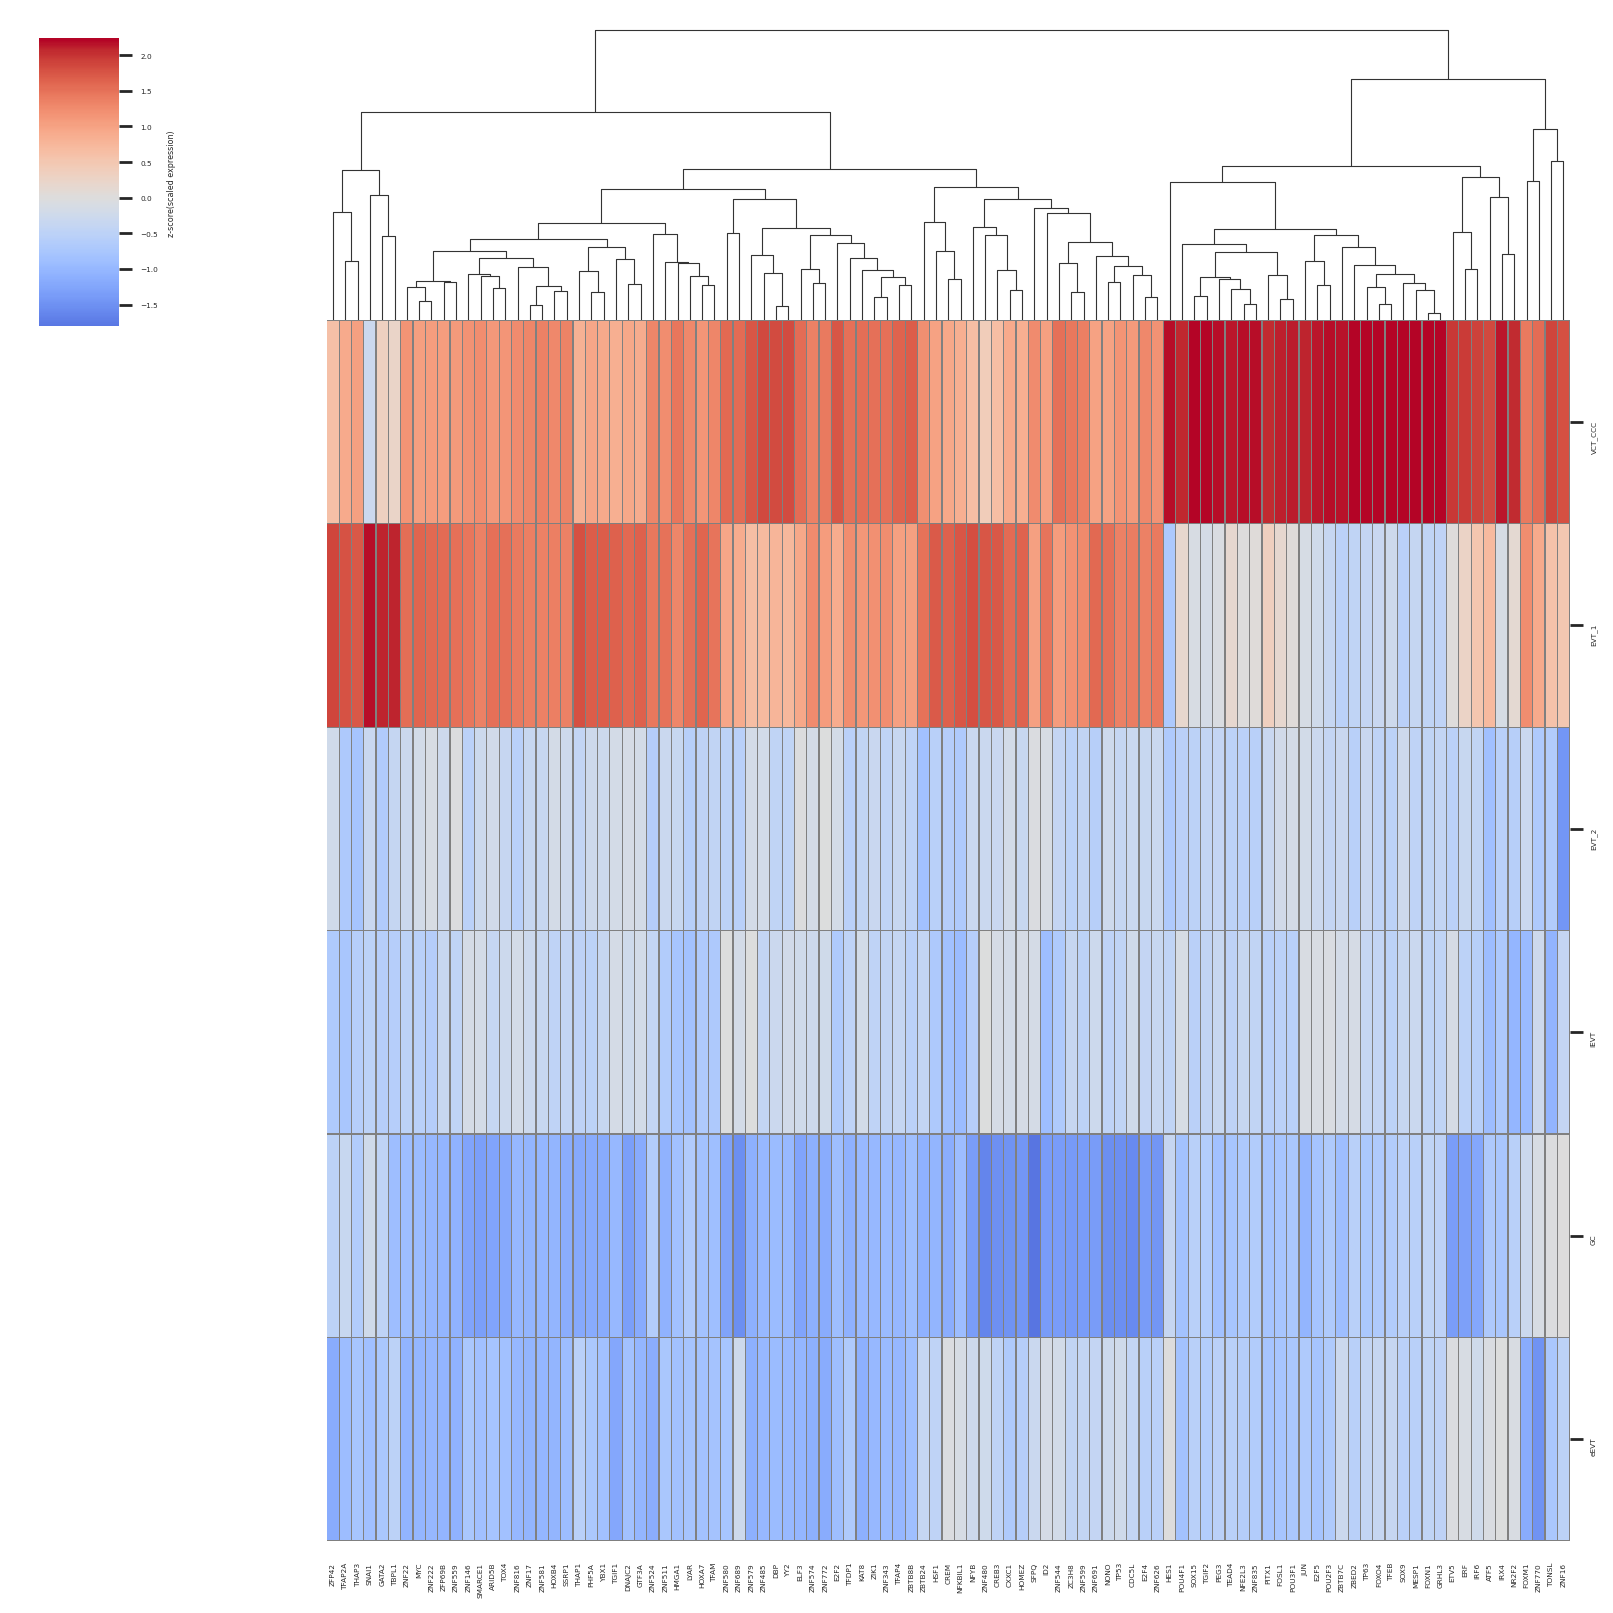

In [149]:
plt.figure(figsize=(100,5))

sns.set(font_scale=0.3)

# clusterplot for each ME

TFs2plot = sorted(MEs_TFs['ME_1_early_inv_column'])

sns.clustermap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
               row_cluster=False,
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
#x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
#plt.xticks(x, fontsize=8, labels = TFs2plot)



<Figure size 8000x400 with 0 Axes>

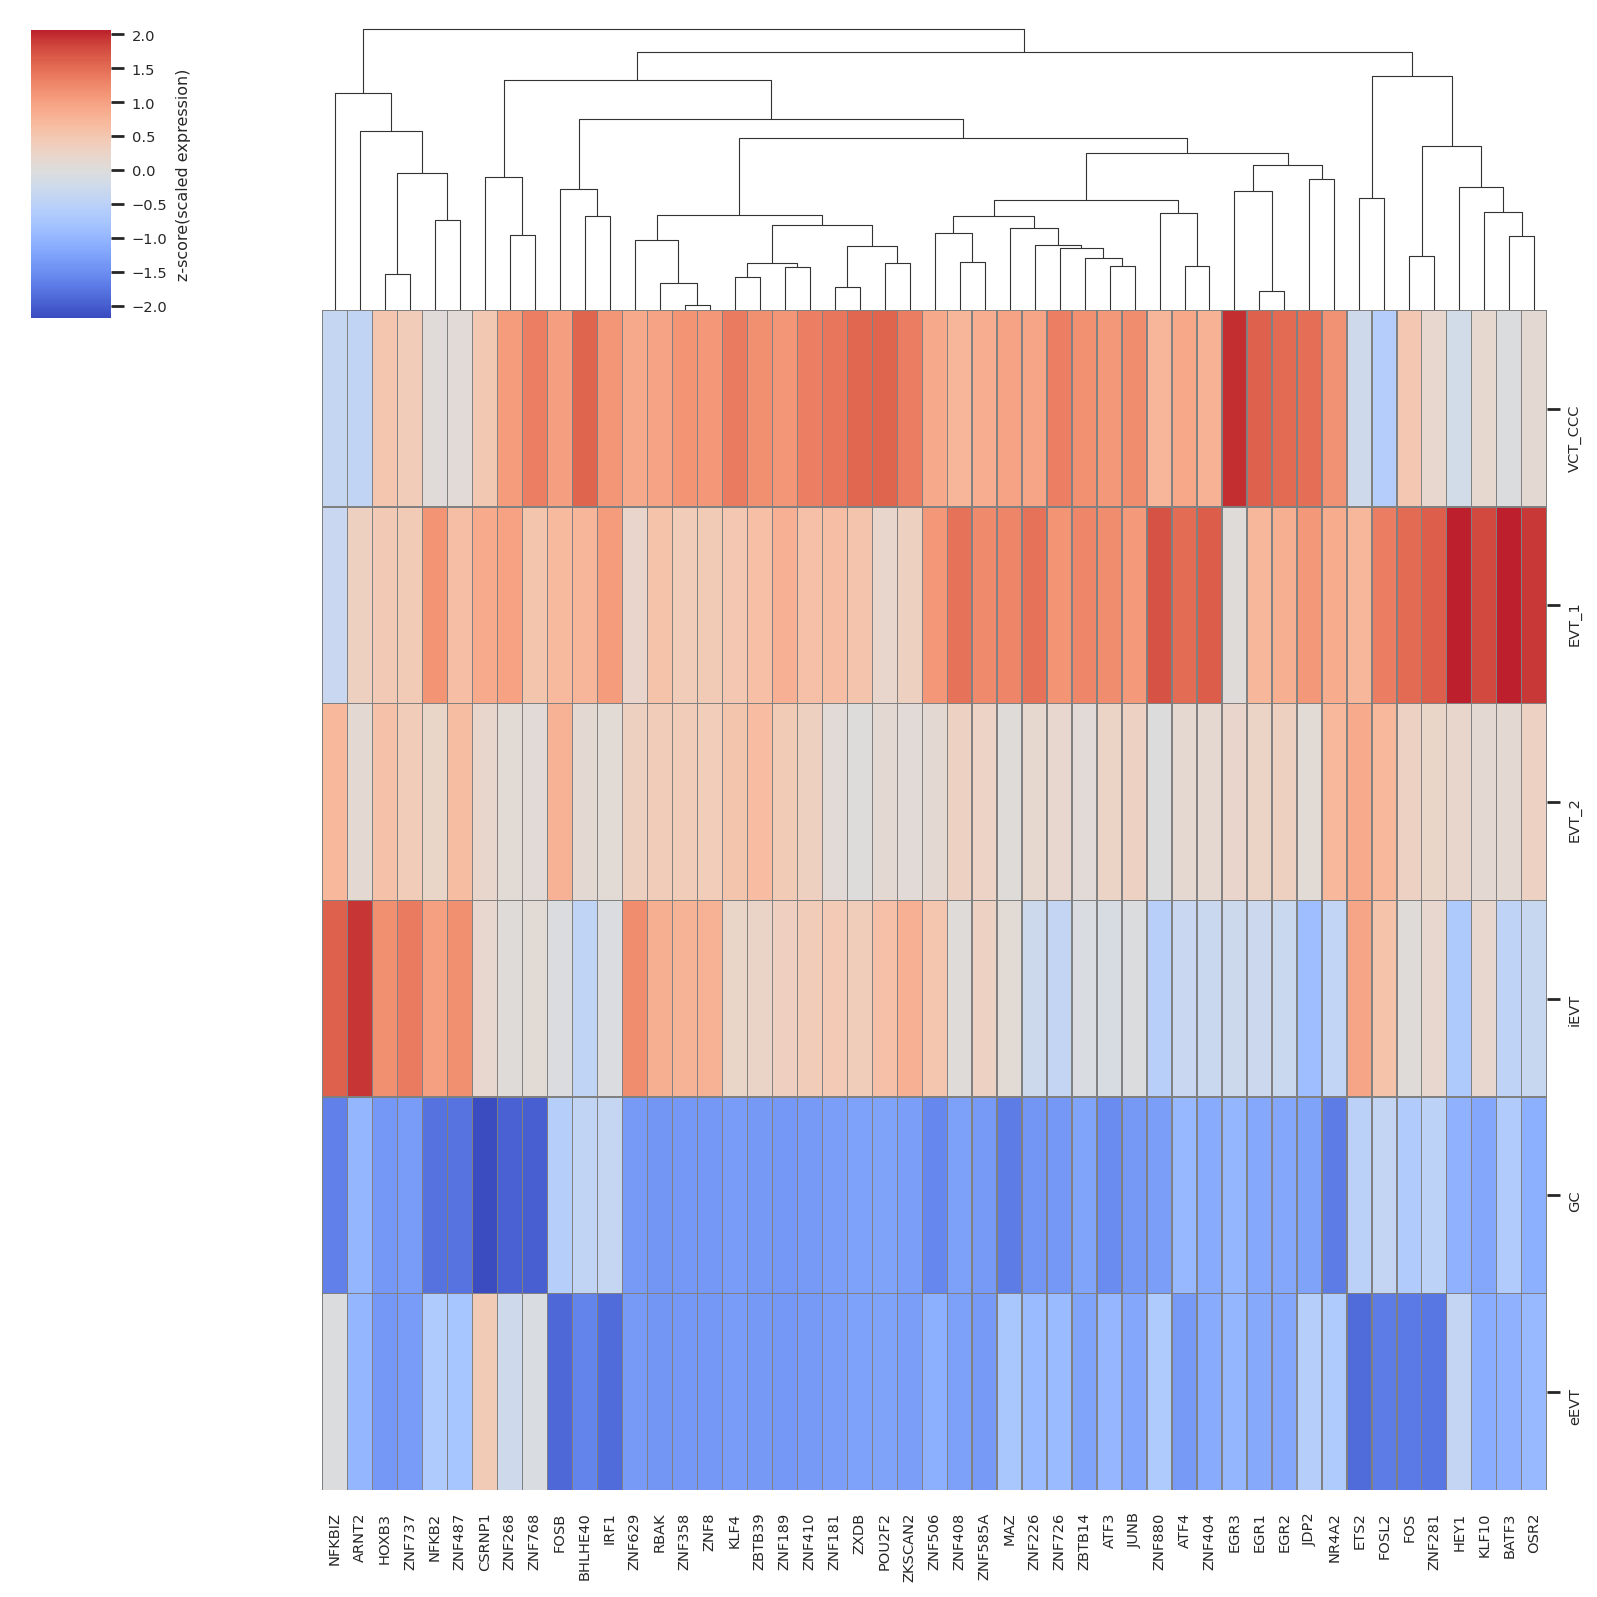

In [151]:
plt.figure(figsize=(100,5))

sns.set(font_scale=0.6)

# clusterplot for each ME

TFs2plot = sorted(MEs_TFs['ME_2_inv_front'])

sns.clustermap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
               row_cluster=False,
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
#x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
#plt.xticks(x, fontsize=8, labels = TFs2plot)



<Figure size 8000x400 with 0 Axes>

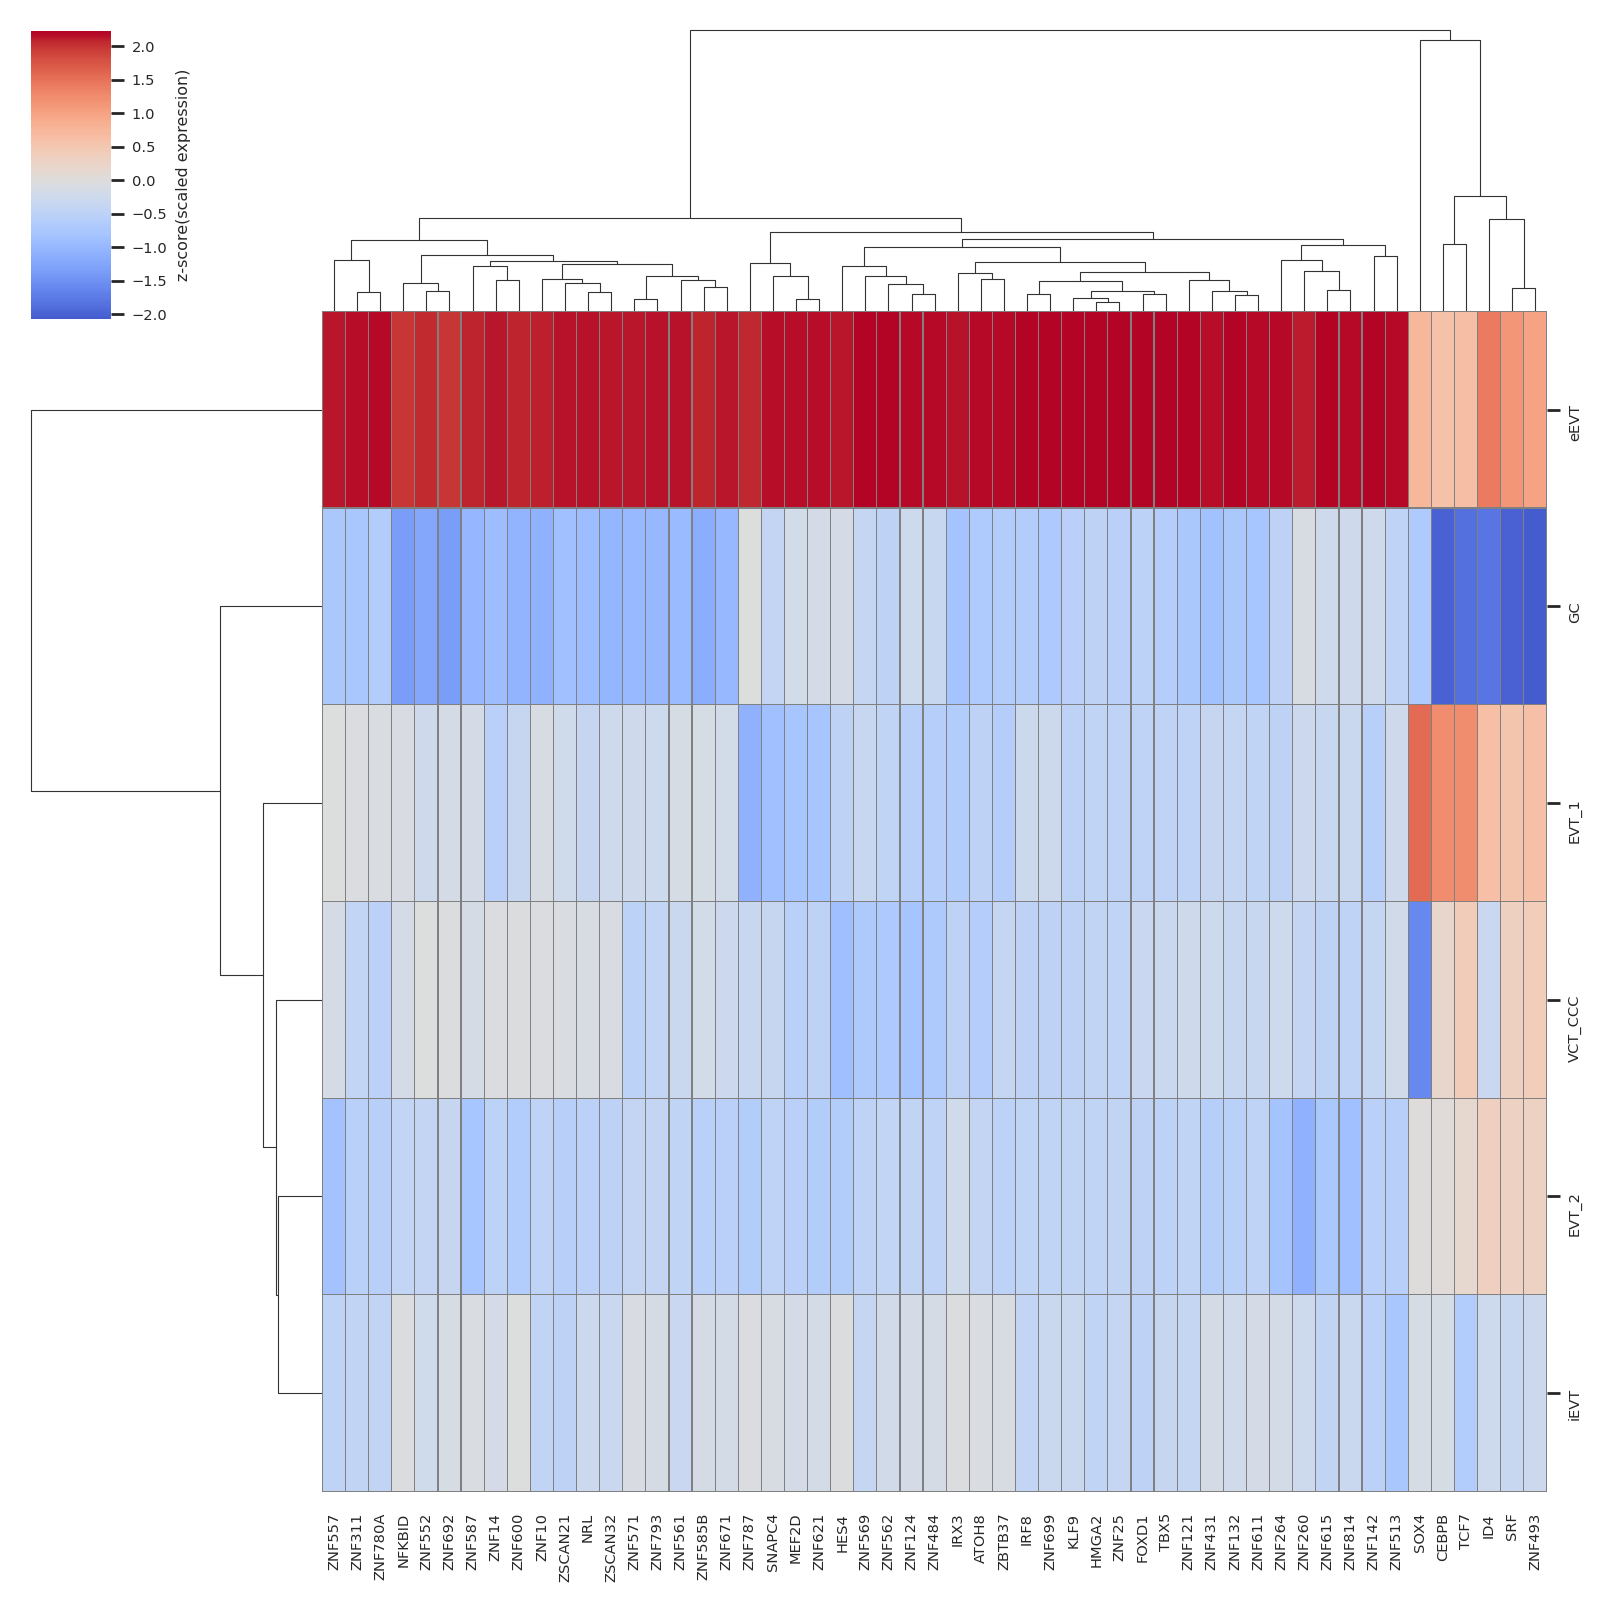

In [152]:
plt.figure(figsize=(100,5))

sns.set(font_scale=0.6)

# clusterplot for each ME

TFs2plot = sorted(MEs_TFs['ME_3_artery_remodelling'])

sns.clustermap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
               #row_cluster=False,
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
#x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
#plt.xticks(x, fontsize=8, labels = TFs2plot)



<Figure size 8000x400 with 0 Axes>

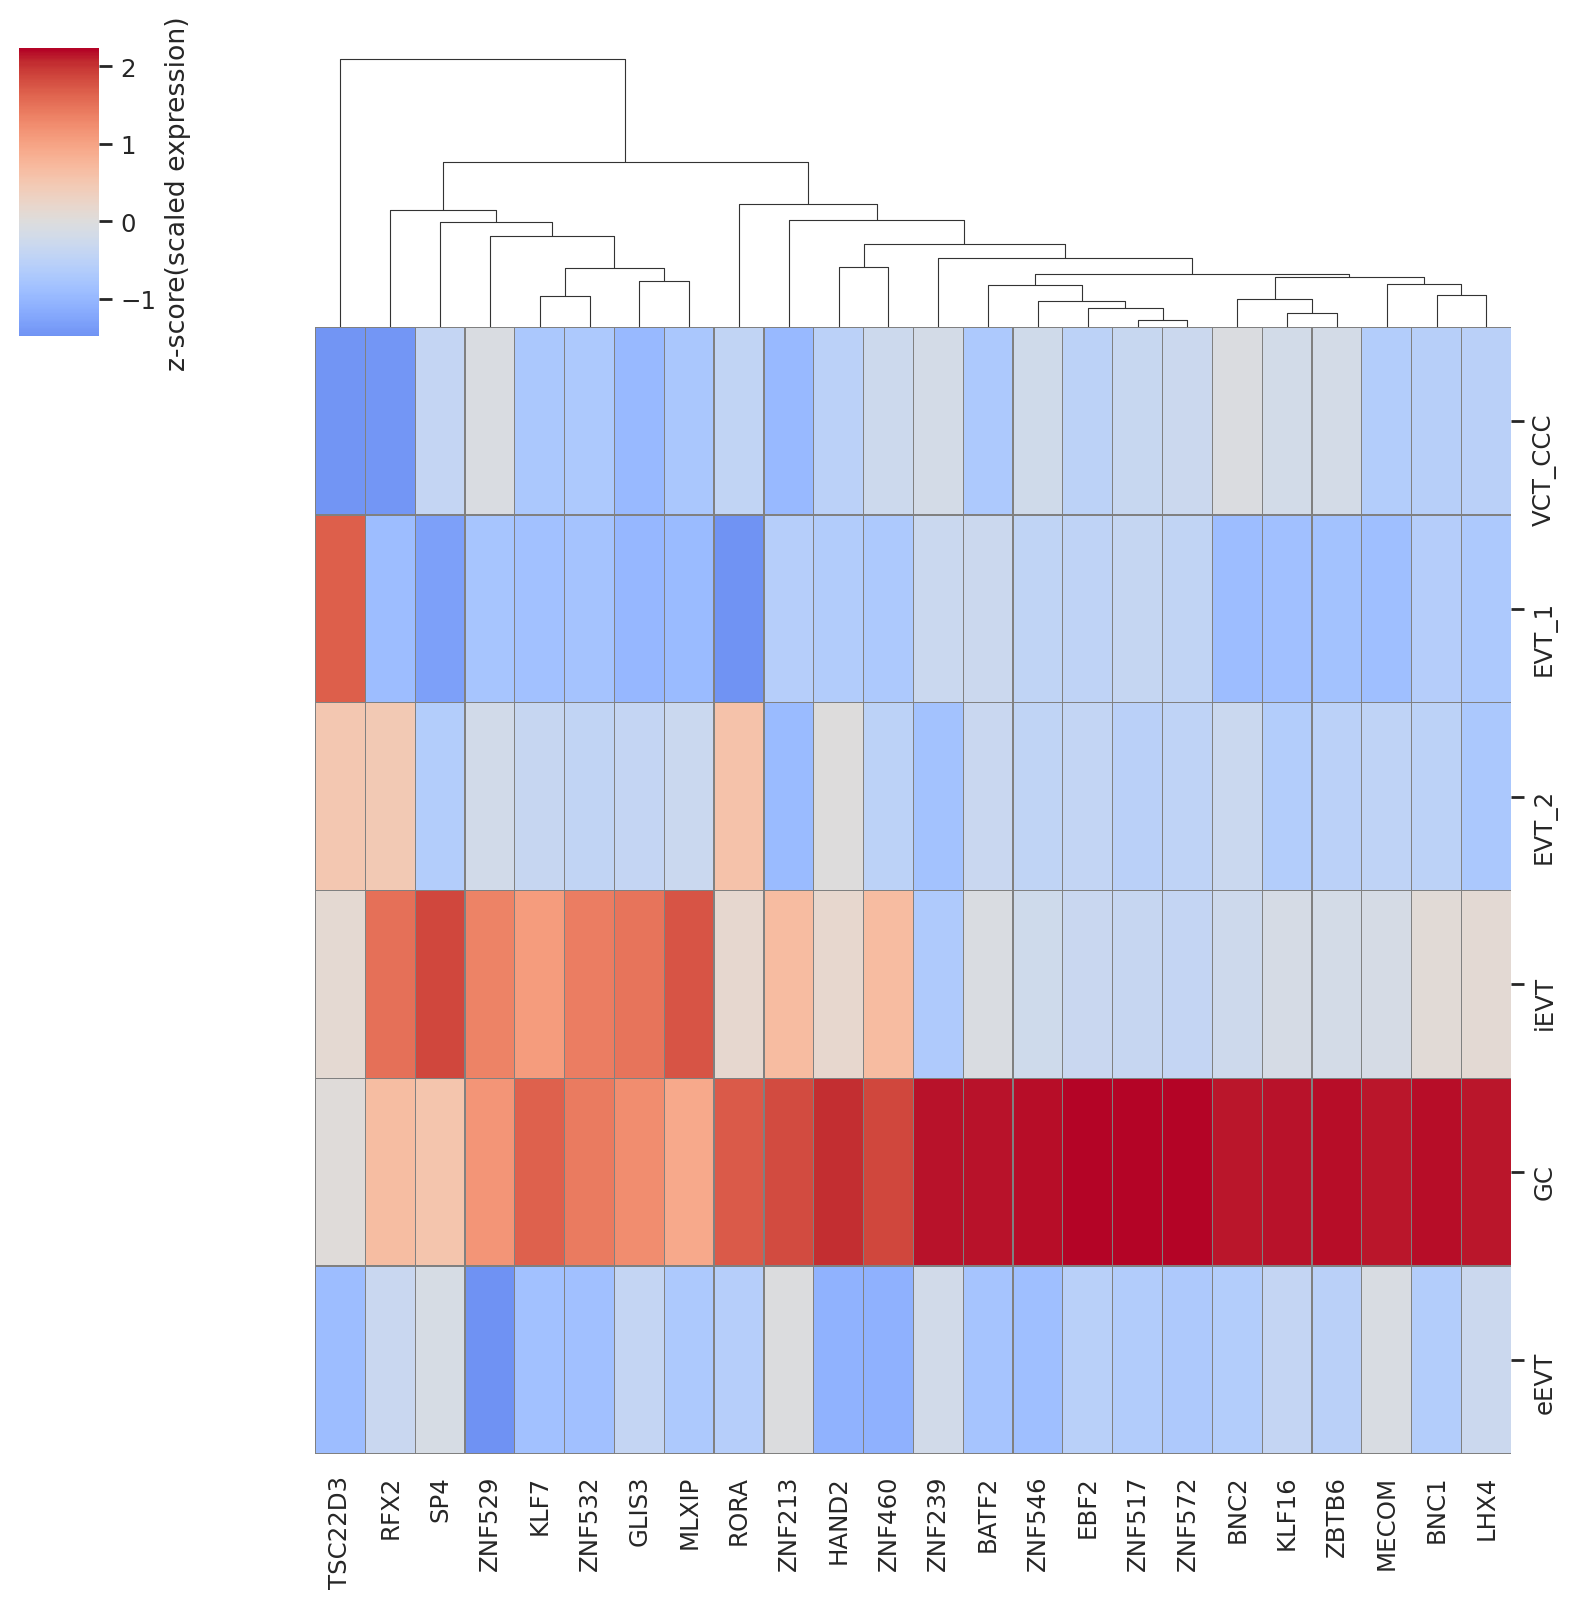

In [147]:
plt.figure(figsize=(100,5))

sns.set(font_scale=1.0)

# clusterplot for each ME

TFs2plot = sorted(MEs_TFs['ME_4_fusion'])

sns.clustermap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
               row_cluster=False,
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
#x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
#plt.xticks(x, fontsize=8, labels = TFs2plot)



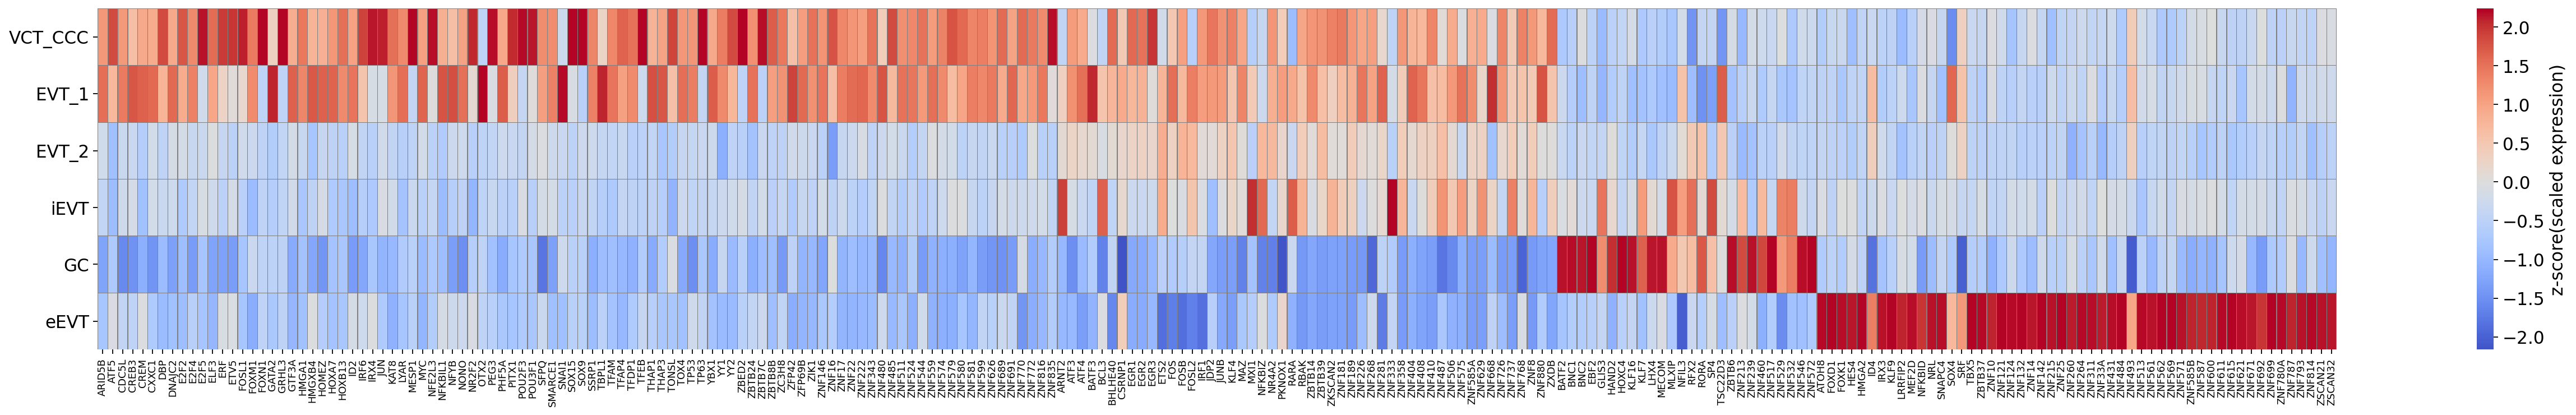

In [194]:
# all 4 MEs plotted together
# sorted by alphabet

plt.figure(figsize=(40,5))

sns.heatmap(df_avg_expr_zscores.loc[all_TFs_final].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, 224.5, 1)
plt.xticks(x, fontsize=8, labels = all_TFs_final)

plt.savefig('./figures/20220202_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

In [168]:
all_TFs_final_df = pd.DataFrame(index=all_TFs_final)
MEs_vec = [[ME for i in range(len(MEs_TFs[ME]))] for ME in MEs]
MEs_vec = [item for sublist in MEs_vec for item in sublist]
all_TFs_final_df['ME'] = MEs_vec
all_TFs_final_df

ME
ARID5B   ME_1_early_inv_column
ATF5     ME_1_early_inv_column
CDC5L    ME_1_early_inv_column
CREB3    ME_1_early_inv_column
CREM     ME_1_early_inv_column
...                        ...
ZNF787             ME_4_fusion
ZNF793             ME_4_fusion
ZNF814             ME_4_fusion
ZSCAN21            ME_4_fusion
ZSCAN32            ME_4_fusion

[227 rows x 1 columns]

In [169]:
all_TFs_final_df.to_csv('./20220203_final_TFs_df_plot_Fig2G.csv')

In [170]:
'RELB' in list(df_avg_expr_zscores.index)

True

# to do: add somehow the types of evidence to each TF (in each celltype???)